In [1]:
import numpy as np
import torch
import rc_tools as rct
import rc_analysis as rca
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.optimize import fsolve
from scipy.signal import argrelextrema
import sys
import warnings
import time

import pdb

from skopt.space import Real,Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings("ignore")

from jupyterthemes import jtplot
jtplot.style()

np.random.seed(11)
torch.set_printoptions(precision=10)
dtype = torch.float32 

print(f'Python: {sys.version}')
print(f'Numpy: {np.__version__}')
print(f'Torch: {torch.__version__}')

DEVICE = 'cuda:7'

FREERUN = 20
DT = .02

rho = 28.0
sigma = 10.0
beta = 8/3

def f(state, t):
    x,y,z = state
    return sigma*(y-x), x*(rho-z)-y, x*y - beta*z

state0 = [1.,1.,1.]
t = np.arange(0,300+FREERUN,DT)
states = odeint(f,state0,t)

Python: 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]
Numpy: 1.21.2
Torch: 1.10.0


In [2]:
log_z = np.log(states[:,2])

MU_X = np.mean(log_z)
signal = log_z-MU_X

M = signal.shape[0] - int(FREERUN/DT)
K = 1
L = 1
RF = .5
TEST = 1000
LEAD = 100
BURNIN = 100
REG = 1e-8
TRAINLENGTH = M-TEST


MINMAX = np.max(states[:TRAINLENGTH+TEST,2]) - \
         np.min(states[:TRAINLENGTH+TEST,2])
BINS = 50

print(f'Signal length M={M}')

Signal length M=15000


In [3]:
def get_weight_matricesGPU(k,n,l,ri,ro):
    win = torch.rand((n,k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ri)
    wfb = torch.zeros((n,l),dtype=dtype, device=torch.device(DEVICE))
    wout = torch.rand((l,n+k),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(ro)
    return win, wfb, wout

def set_vectorsGPU(n,l,r):
    x0 = torch.rand((n,1),dtype=dtype,
                      device=torch.device(DEVICE)).sub(.5).mul(r)
    y0 = torch.zeros((l,1),dtype=dtype, device=torch.device(DEVICE))
    return x0, y0

def update_res_stateGPU(wnet,xt,uxy,a,g):
    z = torch.matmul(wnet,uxy)
    return torch.mul(xt,1-a) + torch.mul(torch.tanh(z),a*g)

def predict_yGPU(wout,xu):
    return torch.matmul(wout, xu)

def get_matrixGPU(n,r,sr):
    A = (torch.rand((n,n),dtype=dtype,
                   device=torch.device(DEVICE))-.5)*r
    At = torch.transpose(A,0,1)
    D = torch.diag(torch.diag(A))   
    W = A + At - D
    eig = torch.eig(W, eigenvectors=False)
    wsr = torch.max(torch.abs(eig[0]))
    return W.div(wsr).mul(sr)

def resize_spaces(mn, mx, best, isAlpha=False):
    #pdb.set_trace()
    if(best.size==0):
        new_mn = np.max([0, mn - .5*mn])
        new_mx = 1.5*mx
    else:
        best_mn = np.min(best)
        best_mx = np.max(best)
        mn_bound = (best_mn-mn)/2
        mx_bound = (mx -best_mx)/2
        new_mn, new_mx = best_mn-mn_bound, best_mx+mx_bound
        print(f'\nBest mn:{best_mn:.3f}\t mn:{best_mx:.3f}')
        print(f'New bounds mn--mx: {mn_bound:.3f}--{mx_bound:.3f}')
    if(isAlpha):
        if(new_mx>1):
            new_mx = 1
    
    return new_mn, new_mx

In [4]:
min_a, max_a = .001, 1.
min_sr, max_sr = .001, 8.
min_g, max_g = .001, 1.
min_ri, max_ri = .001, 1.
min_rr, max_rr = .001, 5.
space = [Real(min_a, max_a, name='a'),
                 Real(min_sr, max_sr, name='sr'),
                 Real(min_g, max_g, name='amp'), 
                 Real(min_ri, max_ri, name='ri'),
                 Real(min_rr, max_rr, name='rr')
                ]

@use_named_args(space)
def loop(a=1.0,sr=1.0,amp=1.0,ri=1.0,rr=1.0):
    start = time.time()
    global running_error, s, counter, signal, N, ref, rn, \
           alphas, rhos, gammas, inScales, resScales
    
    ut = torch.zeros((1,1),dtype=dtype,
                     device=torch.device(DEVICE))
    tp = torch.zeros((1,1),dtype=dtype,
                     device=torch.device(DEVICE))
    
    Wres = get_matrixGPU(N,rr,sr)
    Win, Wfb, Wout = get_weight_matricesGPU(K,N,L,ri,RF)
    Wnet = torch.cat((Win,Wres,Wfb),1)
    xt, yt = set_vectorsGPU(N,L,rr)

    states = torch.zeros((TRAINLENGTH, N+K),dtype=dtype,
                         device=DEVICE)
    targets = torch.zeros((TRAINLENGTH),dtype=dtype, device=DEVICE)
    for i in range(TRAINLENGTH):
        ut[0,0] = s[i]
        tp[0,0] = s[i+1]
        targets[i] = s[i+1]
        uxy = torch.cat((ut,xt,yt),0)
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp)
        xu = torch.transpose(torch.cat((xt1,ut),0),0,1).to(DEVICE)
        states[i,:] = xu[0,:]
        xt, yt = xt1, tp 

    state = states.detach().cpu().numpy()

    torch.cuda.synchronize()
    wout = rct.get_trained_weights(state[BURNIN:],
                                   signal[BURNIN+1:TRAINLENGTH+1],
                                   REG)
    Wout = torch.from_numpy(wout.reshape(L,N+K)).type(dtype).cuda(DEVICE)
    torch.cuda.synchronize()

    predictions = torch.zeros((M+int(FREERUN/DT),1),
                              dtype=dtype,
                              device=torch.device(DEVICE))

    xt, yt = set_vectorsGPU(N,L,rr)
    ut.fill_(0.0)
    for i in range(M+int(FREERUN/DT)):
        if(i < TRAINLENGTH):
            ut[0,0] = s[i]
        else:
            ut = yt
        uxy = torch.cat((ut,xt,yt),0)
        xt1 = update_res_stateGPU(Wnet,xt,uxy,a,amp)
        xu = torch.cat((xt1,ut),0).to(DEVICE)
        yt1 = predict_yGPU(Wout,xu)
        predictions[i] = yt1[0,0]
        xt, yt = xt1, yt1

    yHat_GPU = predictions.detach().cpu().numpy()
    
    nrmse = 1000.0
    try:
        nrmse = rca.NRMSE(np.exp(signal[TRAINLENGTH:TRAINLENGTH+TEST]+MU_X),
                          np.exp(yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST]+MU_X),
                          MINMAX) 
    except:
        pass
    
    
    av = signal[TRAINLENGTH:TRAINLENGTH+TEST].reshape(TEST,1)
    bv = np.squeeze(yHat_GPU[TRAINLENGTH:TRAINLENGTH+TEST]).reshape(TEST,1)
    num = np.squeeze(np.dot(av.T,bv))
    den = np.linalg.norm(av)*np.linalg.norm(bv)
    cosine_similarity = num/den
    cosine_distance = 1 - cosine_similarity
    dist = cosine_distance
    
    loss = nrmse + dist
    if(np.isnan(loss) or (np.isinf(loss) or (loss > 1000.0))):
        loss = 1000
    
    if((loss < running_error) & (loss < .6)):
        alphas.append(a)
        rhos.append(sr)
        gammas.append(amp)
        inScales.append(ri)
        resScales.append(rr)
        running_error = loss
        wnet = Wnet.detach().cpu().numpy()
        currentParams = np.array([a,sr,amp,ri,rr,loss])
        
        fig = plt.figure(figsize=(10,8))
        ax1 = plt.subplot(111)
        ax1.plot(signal[TRAINLENGTH-LEAD:], label='Target')
        ax1.plot(yHat_GPU[TRAINLENGTH-LEAD:], label='GPU')
        ax1.axvline(LEAD,c='orange',linestyle='dashed')
        ax1.axvline(LEAD+TEST,c='r',linestyle='dashed')
        ax1.set_ylim(-4,4)
        ax1.legend()
        plt.show()
        fig.savefig(f'./Z_Saved_Models/Z_sz{N}_ref{ref}_run{rn}_iter{counter}.pdf',
                    format='pdf', bbox_inches='tight', pad_inches=.01)
        plt.close()
        
        np.save(f'./Z_Saved_Models/Z_it{counter}_{N}_{ref}_{rn}_Wnet',wnet)
        np.save(f'./Z_Saved_Models/Z_it{counter}_{N}_{ref}_{rn}_Preds',yHat_GPU)
        np.save(f'./Z_Saved_Models/Z_it{counter}_{N}_{ref}_{rn}_InstanceParams',currentParams)
        print(f' Iter={counter} a={a:.3f} sr={sr:.3f} amp={amp:.3f}',
              f' ri={ri:.3f} rr={rr:.3f} loss={loss:3f}\n\n')
    ####### Running info ##############################
    print(f'Iter: {counter} #### Diagnostic {loss:3f}   Time {(time.time()-start):.2f}',
          f' Best {running_error:.3f} NRMSE {nrmse:.3f} CD {dist:.3f}')
    ###### Store this run #############################
    counter += 1
    return loss

********** Size 900 -- Run 0 ***********
Iter: 0 #### Diagnostic 1.508813   Time 14.31  Best 1000.000 NRMSE 0.508 CD 1.001
Iter: 1 #### Diagnostic 1000.000000   Time 7.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 7.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 9.79  Best 1000.000 NRMSE 1000.000 CD 0.995
Iter: 4 #### Diagnostic 1.000951   Time 7.46  Best 1000.000 NRMSE 0.182 CD 0.819
Iter: 5 #### Diagnostic 1.539868   Time 13.26  Best 1000.000 NRMSE 0.536 CD 1.004
Iter: 6 #### Diagnostic 1000.000000   Time 11.56  Best 1000.000 NRMSE 167578.243 CD 0.999
Iter: 7 #### Diagnostic 1.543917   Time 9.74  Best 1000.000 NRMSE 0.536 CD 1.008
Iter: 8 #### Diagnostic 0.761285   Time 10.71  Best 1000.000 NRMSE 0.168 CD 0.593
Iter: 9 #### Diagnostic 1000.000000   Time 9.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 12.24  Best 1000.000 NRMSE 1000.000 CD 1.001
Iter: 11 #### Diagnostic 1000.

Iter: 95 #### Diagnostic 1000.000000   Time 13.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000000   Time 10.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000000   Time 11.71  Best 1000.000 NRMSE 1000.000 CD 0.993
Iter: 98 #### Diagnostic 1.082737   Time 9.08  Best 1000.000 NRMSE 0.184 CD 0.898
Iter: 99 #### Diagnostic 1.146172   Time 7.74  Best 1000.000 NRMSE 0.187 CD 0.959

Best result = 0.7230398996955181
a = 0.3843375236034722
sr = 5.1611559764767625
amp = 0.3935360653193576
ri = 0.9536262635227069
rr = 0.5495285220732711
********** Size 900 -- Run 1 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 13.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000000   Time 11.39  Best 1000.000 NRMSE 1000.000 CD 0.917
Iter: 2 #### Diagnostic 1.097255   Time 10.95  Best 1000.000 NRMSE 0.185 CD 0.913
Iter: 3 #### Diagnostic 1000.000000   Time 8.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000  

Iter: 89 #### Diagnostic 1000.000000   Time 8.78  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1000.000000   Time 13.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1.525265   Time 10.98  Best 1000.000 NRMSE 0.529 CD 0.996
Iter: 92 #### Diagnostic 1.107584   Time 10.62  Best 1000.000 NRMSE 0.186 CD 0.921
Iter: 93 #### Diagnostic 1000.000000   Time 9.88  Best 1000.000 NRMSE 1000.000 CD 0.973
Iter: 94 #### Diagnostic 1.216793   Time 11.64  Best 1000.000 NRMSE 0.195 CD 1.021
Iter: 95 #### Diagnostic 1000.000000   Time 10.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000000   Time 9.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1.285917   Time 9.53  Best 1000.000 NRMSE 0.229 CD 1.057
Iter: 98 #### Diagnostic 0.854937   Time 10.90  Best 1000.000 NRMSE 0.219 CD 0.636
Iter: 99 #### Diagnostic 1000.000000   Time 11.16  Best 1000.000 NRMSE 1000.000 CD nan

Best result = 0.6620675311099842
a = 0.26990238613731193
sr = 1.

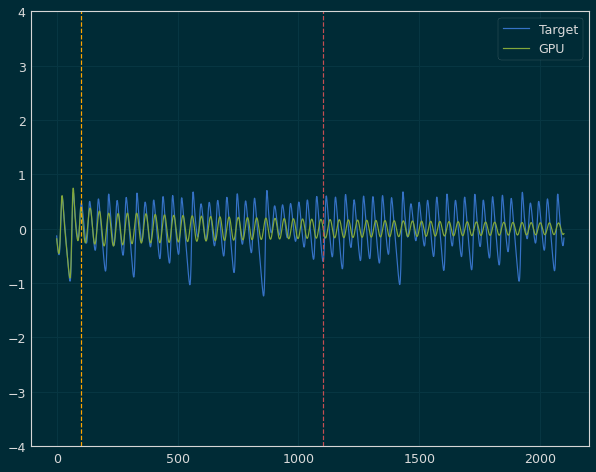

 Iter=48 a=0.026 sr=0.528 amp=0.327  ri=0.584 rr=0.504 loss=0.595392


Iter: 48 #### Diagnostic 0.595392   Time 15.78  Best 0.595 NRMSE 0.153 CD 0.442
Iter: 49 #### Diagnostic 1.132759   Time 10.91  Best 0.595 NRMSE 0.202 CD 0.930
Iter: 50 #### Diagnostic 1000.000000   Time 13.34  Best 0.595 NRMSE 1000.000 CD 1.088
Iter: 51 #### Diagnostic 1000.000000   Time 12.32  Best 0.595 NRMSE 1688106542876272.500 CD 1.003
Iter: 52 #### Diagnostic 1000.000000   Time 11.09  Best 0.595 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1.088098   Time 7.26  Best 0.595 NRMSE 0.185 CD 0.903
Iter: 54 #### Diagnostic 1.106126   Time 9.91  Best 0.595 NRMSE 0.185 CD 0.921
Iter: 55 #### Diagnostic 1.093294   Time 14.07  Best 0.595 NRMSE 0.185 CD 0.908
Iter: 56 #### Diagnostic 1000.000000   Time 8.79  Best 0.595 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000000   Time 9.79  Best 0.595 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 10.88  Best 0.595 NRMSE 1000.000 CD nan
Iter: 59 ####

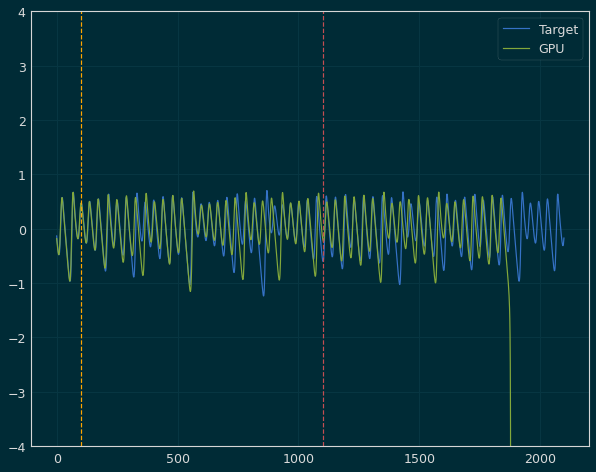

 Iter=9 a=0.613 sr=6.585 amp=0.165  ri=0.637 rr=4.248 loss=0.560196


Iter: 9 #### Diagnostic 0.560196   Time 11.09  Best 0.560 NRMSE 0.154 CD 0.406
Iter: 10 #### Diagnostic 1.162760   Time 12.80  Best 0.560 NRMSE 0.187 CD 0.975
Iter: 11 #### Diagnostic 1000.000000   Time 13.04  Best 0.560 NRMSE 1000.000 CD 0.993
Iter: 12 #### Diagnostic 1000.000000   Time 10.85  Best 0.560 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000000   Time 9.29  Best 0.560 NRMSE 1000.000 CD 1.002
Iter: 14 #### Diagnostic 1000.000000   Time 9.92  Best 0.560 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 14.36  Best 0.560 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 12.63  Best 0.560 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1.308785   Time 12.53  Best 0.560 NRMSE 0.266 CD 1.043
Iter: 18 #### Diagnostic 0.948147   Time 10.73  Best 0.560 NRMSE 0.181 CD 0.767
Iter: 19 #### Diagnostic 1.538897   Time 10.09  Best 0.560 NRMSE 0.536 CD 1.003
Iter: 20 #### Diagnostic 

Iter: 5 #### Diagnostic 1000.000000   Time 9.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000000   Time 11.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1.109211   Time 9.99  Best 1000.000 NRMSE 0.145 CD 0.965
Iter: 8 #### Diagnostic 0.954748   Time 8.41  Best 1000.000 NRMSE 0.181 CD 0.774
Iter: 9 #### Diagnostic 1000.000000   Time 13.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 7.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1.090887   Time 12.38  Best 1000.000 NRMSE 0.204 CD 0.887
Iter: 12 #### Diagnostic 1000.000000   Time 8.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000000   Time 14.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000000   Time 10.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 8.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 13.93  Best 1000.000 N

Iter: 0 #### Diagnostic 1.348985   Time 12.18  Best 1000.000 NRMSE 0.286 CD 1.063
Iter: 1 #### Diagnostic 1000.000000   Time 12.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 11.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 12.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 0.992018   Time 9.19  Best 1000.000 NRMSE 0.182 CD 0.810
Iter: 5 #### Diagnostic 88.250200   Time 11.23  Best 1000.000 NRMSE 87.250 CD 1.000
Iter: 6 #### Diagnostic 1000.000000   Time 11.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 12.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 0.736469   Time 8.33  Best 1000.000 NRMSE 0.167 CD 0.569
Iter: 9 #### Diagnostic 1000.000000   Time 11.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1.533937   Time 9.90  Best 1000.000 NRMSE 0.536 CD 0.998
Iter: 11 #### Diagnostic 1000.000000   Time 9.90  Best 1000.000 NRMSE 1000

Iter: 96 #### Diagnostic 1000.000000   Time 10.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1.540180   Time 9.78  Best 1000.000 NRMSE 0.536 CD 1.004
Iter: 98 #### Diagnostic 1.083887   Time 15.11  Best 1000.000 NRMSE 0.184 CD 0.899
Iter: 99 #### Diagnostic 1.154972   Time 12.55  Best 1000.000 NRMSE 0.191 CD 0.964

Best result = 0.7074088561550038
a = 0.553968284790046
sr = 3.020500917015245
amp = 0.4648572594291303
ri = 0.9555820730468593
rr = 3.6815484738016866
********** Size 900 -- Run 1 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 11.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000000   Time 11.33  Best 1000.000 NRMSE 1000.000 CD 1.075
Iter: 2 #### Diagnostic 1.097744   Time 12.23  Best 1000.000 NRMSE 0.185 CD 0.913
Iter: 3 #### Diagnostic 1000.000000   Time 10.52  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 14.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1.542620   Time 12.5

Iter: 90 #### Diagnostic 1000.000000   Time 13.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1.526583   Time 11.84  Best 1000.000 NRMSE 0.529 CD 0.997
Iter: 92 #### Diagnostic 1.082637   Time 8.43  Best 1000.000 NRMSE 0.185 CD 0.897
Iter: 93 #### Diagnostic 1000.000000   Time 13.42  Best 1000.000 NRMSE 1000.000 CD 0.999
Iter: 94 #### Diagnostic 1.160423   Time 13.62  Best 1000.000 NRMSE 0.193 CD 0.968
Iter: 95 #### Diagnostic 1000.000000   Time 12.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000000   Time 9.27  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1.293679   Time 11.84  Best 1000.000 NRMSE 0.229 CD 1.064
Iter: 98 #### Diagnostic 1.102230   Time 9.95  Best 1000.000 NRMSE 0.252 CD 0.850
Iter: 99 #### Diagnostic 1000.000000   Time 9.30  Best 1000.000 NRMSE 1000.000 CD nan

Best result = 0.6734624248376201
a = 0.7062689486050784
sr = 5.607404004014453
amp = 0.23751506714426798
ri = 0.41807635400958104
rr = 0.89356524844501

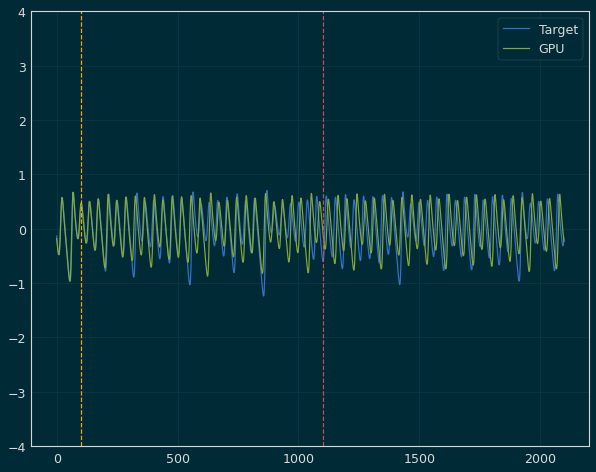

 Iter=4 a=0.307 sr=4.693 amp=0.276  ri=0.455 rr=3.789 loss=0.596128


Iter: 4 #### Diagnostic 0.596128   Time 8.68  Best 0.596 NRMSE 0.167 CD 0.429
Iter: 5 #### Diagnostic 1000.000000   Time 13.39  Best 0.596 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000000   Time 9.94  Best 0.596 NRMSE 1000.000 CD 1.000
Iter: 7 #### Diagnostic 1000.000000   Time 10.10  Best 0.596 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 7.88  Best 0.596 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000000   Time 11.84  Best 0.596 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 10.48  Best 0.596 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1.540583   Time 13.87  Best 0.596 NRMSE 0.536 CD 1.005
Iter: 12 #### Diagnostic 1000.000000   Time 13.72  Best 0.596 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000000   Time 10.94  Best 0.596 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1.075892   Time 11.39  Best 0.596 NRMSE 0.184 CD 0.892
Iter: 15 #### Diagnostic 

Iter: 1 #### Diagnostic 1000.000000   Time 10.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1.531678   Time 9.88  Best 1000.000 NRMSE 0.536 CD 0.996
Iter: 3 #### Diagnostic 1000.000000   Time 13.04  Best 1000.000 NRMSE 1000.000 CD 0.988
Iter: 4 #### Diagnostic 1000.000000   Time 10.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 9.13  Best 1000.000 NRMSE 1000.000 CD 0.995
Iter: 6 #### Diagnostic 1000.000000   Time 8.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 13.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 13.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1.058107   Time 9.59  Best 1000.000 NRMSE 0.235 CD 0.823
Iter: 10 #### Diagnostic 1000.000000   Time 15.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000000   Time 11.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000000   Time 11.00  Best 1000

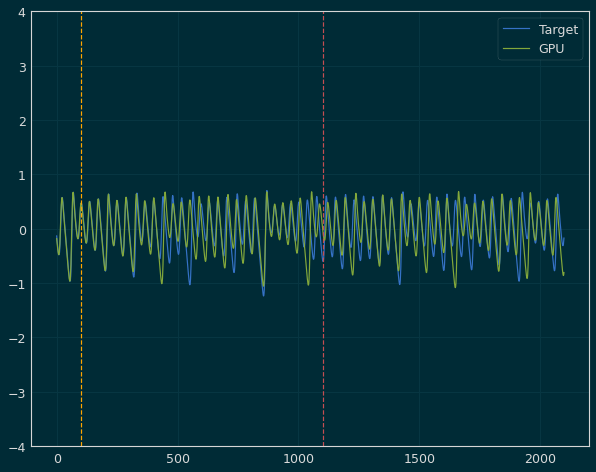

 Iter=26 a=0.520 sr=2.100 amp=0.658  ri=0.652 rr=2.583 loss=0.579663


Iter: 26 #### Diagnostic 0.579663   Time 9.67  Best 0.580 NRMSE 0.163 CD 0.417
Iter: 27 #### Diagnostic 1000.000000   Time 8.08  Best 0.580 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 11.21  Best 0.580 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 0.848357   Time 11.95  Best 0.580 NRMSE 0.178 CD 0.671
Iter: 30 #### Diagnostic 1000.000000   Time 11.12  Best 0.580 NRMSE 452106189864229620678656.000 CD 1.002
Iter: 31 #### Diagnostic 1000.000000   Time 12.76  Best 0.580 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000000   Time 9.62  Best 0.580 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 0.764047   Time 13.25  Best 0.580 NRMSE 0.189 CD 0.575
Iter: 34 #### Diagnostic 1000.000000   Time 9.17  Best 0.580 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000000   Time 12.08  Best 0.580 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1.534192   Time 13.09  Best 0.580 NRMSE 0.536 CD 0.998
Ite

Iter: 20 #### Diagnostic 1000.000000   Time 10.77  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000000   Time 12.35  Best 1000.000 NRMSE 1000.000 CD 0.996
Iter: 22 #### Diagnostic 1000.000000   Time 15.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 11.18  Best 1000.000 NRMSE 3158664923.757 CD 1.007
Iter: 24 #### Diagnostic 1000.000000   Time 11.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 12.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 11.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 9.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 9.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000000   Time 10.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 14.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.00000

Iter: 6 #### Diagnostic 1.544069   Time 10.27  Best 1000.000 NRMSE 0.536 CD 1.008
Iter: 7 #### Diagnostic 1000.000000   Time 13.98  Best 1000.000 NRMSE 1000.000 CD 0.992
Iter: 8 #### Diagnostic 0.740922   Time 11.58  Best 1000.000 NRMSE 0.167 CD 0.574
Iter: 9 #### Diagnostic 1000.000000   Time 12.18  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1.520161   Time 10.20  Best 1000.000 NRMSE 0.524 CD 0.996
Iter: 11 #### Diagnostic 1000.000000   Time 9.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000000   Time 10.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 0.970891   Time 9.94  Best 1000.000 NRMSE 0.188 CD 0.782
Iter: 14 #### Diagnostic 1000.000000   Time 11.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1.053024   Time 12.80  Best 1000.000 NRMSE 0.185 CD 0.868
Iter: 16 #### Diagnostic 1000.000000   Time 13.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 10.89  Best 1000.000 NR

Iter: 0 #### Diagnostic 1000.000000   Time 8.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1.538021   Time 10.11  Best 1000.000 NRMSE 0.536 CD 1.002
Iter: 2 #### Diagnostic 1.098687   Time 11.66  Best 1000.000 NRMSE 0.185 CD 0.914
Iter: 3 #### Diagnostic 1000.000000   Time 7.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 10.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1.542198   Time 11.17  Best 1000.000 NRMSE 0.536 CD 1.006
Iter: 6 #### Diagnostic 1.546086   Time 11.93  Best 1000.000 NRMSE 0.536 CD 1.010
Iter: 7 #### Diagnostic 1.163124   Time 13.18  Best 1000.000 NRMSE 0.195 CD 0.968
Iter: 8 #### Diagnostic 1000.000000   Time 11.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000000   Time 6.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 0.624374   Time 11.36  Best 1000.000 NRMSE 0.173 CD 0.451
Iter: 11 #### Diagnostic 1000.000000   Time 11.39  Best 1000.000 NRMSE 1000.000 

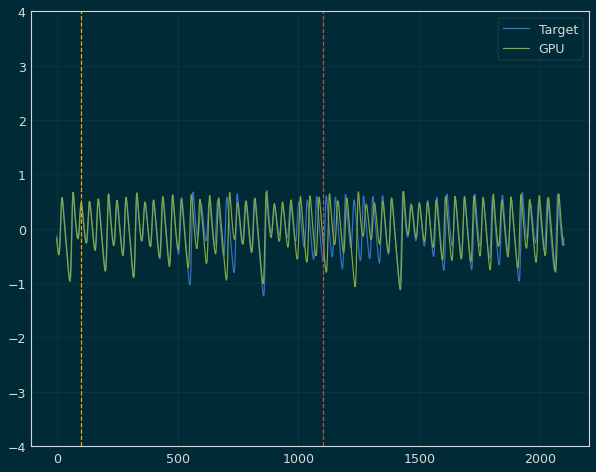

 Iter=54 a=0.460 sr=3.909 amp=0.424  ri=0.677 rr=0.258 loss=0.445951


Iter: 54 #### Diagnostic 0.445951   Time 13.79  Best 0.446 NRMSE 0.143 CD 0.303
Iter: 55 #### Diagnostic 1000.000000   Time 13.55  Best 0.446 NRMSE 1000.000 CD 1.012
Iter: 56 #### Diagnostic 1.478007   Time 11.60  Best 0.446 NRMSE 0.468 CD 1.010
Iter: 57 #### Diagnostic 1.062375   Time 9.92  Best 0.446 NRMSE 0.184 CD 0.878
Iter: 58 #### Diagnostic 1000.000000   Time 6.76  Best 0.446 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1.542467   Time 9.16  Best 0.446 NRMSE 0.536 CD 1.007
Iter: 60 #### Diagnostic 1000.000000   Time 12.33  Best 0.446 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 11.94  Best 0.446 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 14.20  Best 0.446 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1.194402   Time 14.55  Best 0.446 NRMSE 0.219 CD 0.975
Iter: 64 #### Diagnostic 1000.000000   Time 9.09  Best 0.446 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 10

Iter: 49 #### Diagnostic 1.180471   Time 7.89  Best 1000.000 NRMSE 0.207 CD 0.974
Iter: 50 #### Diagnostic 1000.000000   Time 13.98  Best 1000.000 NRMSE 1000.000 CD 0.997
Iter: 51 #### Diagnostic 1000.000000   Time 12.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000000   Time 11.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1.087946   Time 6.50  Best 1000.000 NRMSE 0.185 CD 0.903
Iter: 54 #### Diagnostic 1.103771   Time 9.96  Best 1000.000 NRMSE 0.185 CD 0.919
Iter: 55 #### Diagnostic 1.056544   Time 13.55  Best 1000.000 NRMSE 0.184 CD 0.873
Iter: 56 #### Diagnostic 1000.000000   Time 10.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000000   Time 14.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 10.94  Best 1000.000 NRMSE 1000.000 CD 0.994
Iter: 59 #### Diagnostic 1.043309   Time 13.31  Best 1000.000 NRMSE 0.184 CD 0.860
Iter: 60 #### Diagnostic 1000.000000   Time 12.70  Best 1000.0

Iter: 43 #### Diagnostic 1000.000000   Time 10.62  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000000   Time 13.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 12.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000000   Time 15.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000000   Time 13.80  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1.009626   Time 9.17  Best 1000.000 NRMSE 0.183 CD 0.827
Iter: 49 #### Diagnostic 0.965061   Time 8.14  Best 1000.000 NRMSE 0.182 CD 0.783
Iter: 50 #### Diagnostic 1000.000000   Time 11.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1.541123   Time 9.87  Best 1000.000 NRMSE 0.536 CD 1.005
Iter: 52 #### Diagnostic 1000.000000   Time 10.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000000   Time 9.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000000   Time 9.01  Best 1000

Iter: 35 #### Diagnostic 1000.000000   Time 13.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1.024979   Time 9.43  Best 1000.000 NRMSE 0.183 CD 0.842
Iter: 37 #### Diagnostic 1000.000000   Time 13.74  Best 1000.000 NRMSE 1000.000 CD 0.991
Iter: 38 #### Diagnostic 1000.000000   Time 11.80  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1.200422   Time 9.51  Best 1000.000 NRMSE 0.200 CD 1.000
Iter: 40 #### Diagnostic 1000.000000   Time 11.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000000   Time 12.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000000   Time 10.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1.544066   Time 11.35  Best 1000.000 NRMSE 0.536 CD 1.008
Iter: 44 #### Diagnostic 1.231320   Time 14.58  Best 1000.000 NRMSE 0.228 CD 1.003
Iter: 45 #### Diagnostic 1000.000000   Time 10.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 0.629682   Time 12.98  Best 1000.0

Iter: 22 #### Diagnostic 1.275777   Time 12.49  Best 1000.000 NRMSE 0.306 CD 0.970
Iter: 23 #### Diagnostic 1000.000000   Time 8.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 9.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 12.18  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1.541251   Time 11.19  Best 1000.000 NRMSE 0.536 CD 1.005
Iter: 27 #### Diagnostic 1000.000000   Time 14.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 9.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.565791   Time 12.81  Best 1000.000 NRMSE 0.536 CD 1.030
Iter: 30 #### Diagnostic 0.916334   Time 7.05  Best 1000.000 NRMSE 0.177 CD 0.739
Iter: 31 #### Diagnostic 1000.000000   Time 13.10  Best 1000.000 NRMSE 828179976357.231 CD 0.955
Iter: 32 #### Diagnostic 1.102605   Time 13.56  Best 1000.000 NRMSE 0.187 CD 0.916
Iter: 33 #### Diagnostic 1000.000000   Time 10.98  Best 1

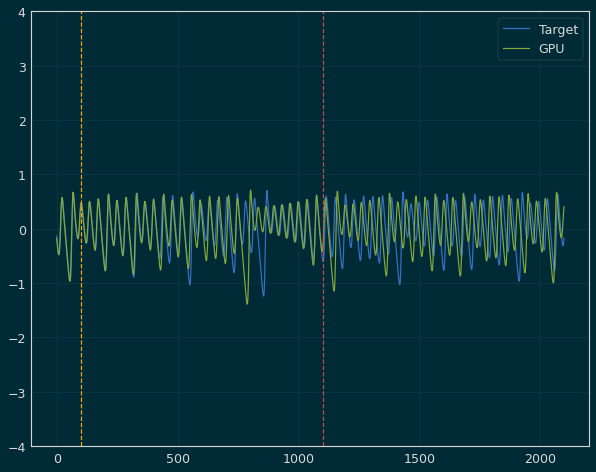

 Iter=73 a=0.401 sr=1.928 amp=0.870  ri=0.939 rr=0.361 loss=0.563978


Iter: 73 #### Diagnostic 0.563978   Time 12.92  Best 0.564 NRMSE 0.150 CD 0.414
Iter: 74 #### Diagnostic 1000.000000   Time 11.81  Best 0.564 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 0.976743   Time 9.30  Best 0.564 NRMSE 0.182 CD 0.795
Iter: 76 #### Diagnostic 1000.000000   Time 11.55  Best 0.564 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1.152136   Time 7.28  Best 0.564 NRMSE 0.186 CD 0.966
Iter: 78 #### Diagnostic 1.164644   Time 10.74  Best 0.564 NRMSE 0.199 CD 0.965
Iter: 79 #### Diagnostic 1000.000000   Time 8.59  Best 0.564 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000000   Time 11.60  Best 0.564 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1000.000000   Time 14.01  Best 0.564 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1000.000000   Time 9.12  Best 0.564 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1.080931   Time 10.45  Best 0.564 NRMSE 0.199 CD 0.882
Iter: 84 #### Diagnostic 1000

Iter: 67 #### Diagnostic 1000.000000   Time 10.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 13.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000000   Time 9.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000000   Time 16.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000000   Time 11.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000000   Time 12.63  Best 1000.000 NRMSE 8003572097506.460 CD 1.002
Iter: 73 #### Diagnostic 1000.000000   Time 10.87  Best 1000.000 NRMSE 1000.000 CD 1.000
Iter: 74 #### Diagnostic 1000.000000   Time 8.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000000   Time 12.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000000   Time 15.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1000.000000   Time 16.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1000.00

Iter: 61 #### Diagnostic 1000.000000   Time 10.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 12.27  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1.057470   Time 12.04  Best 1000.000 NRMSE 0.184 CD 0.874
Iter: 64 #### Diagnostic 1000.000000   Time 11.50  Best 1000.000 NRMSE 1000.000 CD 0.992
Iter: 65 #### Diagnostic 1000.000000   Time 9.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1.298981   Time 9.99  Best 1000.000 NRMSE 0.260 CD 1.039
Iter: 67 #### Diagnostic 1.085290   Time 12.14  Best 1000.000 NRMSE 0.184 CD 0.901
Iter: 68 #### Diagnostic 1000.000000   Time 7.13  Best 1000.000 NRMSE 141040560169904118939254784.000 CD 1.005
Iter: 69 #### Diagnostic 1.130163   Time 11.54  Best 1000.000 NRMSE 0.186 CD 0.944
Iter: 70 #### Diagnostic 1.054550   Time 12.35  Best 1000.000 NRMSE 0.184 CD 0.871
Iter: 71 #### Diagnostic 1000.000000   Time 11.25  Best 1000.000 NRMSE 1000.000 CD 0.989
Iter: 72 #### Diagnostic 1.250040   T

Iter: 55 #### Diagnostic 1000.000000   Time 14.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1.015213   Time 9.77  Best 1000.000 NRMSE 0.182 CD 0.833
Iter: 57 #### Diagnostic 1.046697   Time 11.94  Best 1000.000 NRMSE 0.184 CD 0.863
Iter: 58 #### Diagnostic 1000.000000   Time 10.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000000   Time 11.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000000   Time 8.43  Best 1000.000 NRMSE 1000.000 CD 1.000
Iter: 61 #### Diagnostic 1000.000000   Time 12.40  Best 1000.000 NRMSE 1000.000 CD 1.000
Iter: 62 #### Diagnostic 0.952805   Time 12.21  Best 1000.000 NRMSE 0.181 CD 0.771
Iter: 63 #### Diagnostic 1000.000000   Time 11.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000000   Time 9.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1.089039   Time 10.81  Best 1000.000 NRMSE 0.184 CD 0.905
Iter: 66 #### Diagnostic 1000.000000   Time 13.79  Best 10

Iter: 48 #### Diagnostic 1000.000000   Time 13.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1.174911   Time 9.81  Best 1000.000 NRMSE 0.187 CD 0.988
Iter: 50 #### Diagnostic 1.136591   Time 12.63  Best 1000.000 NRMSE 0.213 CD 0.924
Iter: 51 #### Diagnostic 1.228535   Time 10.60  Best 1000.000 NRMSE 0.193 CD 1.035
Iter: 52 #### Diagnostic 1.254133   Time 10.05  Best 1000.000 NRMSE 0.334 CD 0.920
Iter: 53 #### Diagnostic 1000.000000   Time 12.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000000   Time 8.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000000   Time 14.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000000   Time 12.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000000   Time 11.22  Best 1000.000 NRMSE 1000.000 CD 0.998
Iter: 58 #### Diagnostic 1.101220   Time 8.59  Best 1000.000 NRMSE 0.185 CD 0.916
Iter: 59 #### Diagnostic 1000.000000   Time 10.79  Best 1000.000

Iter: 35 #### Diagnostic 1000.000000   Time 9.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000000   Time 11.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000000   Time 11.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000000   Time 13.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1.241337   Time 12.92  Best 1000.000 NRMSE 0.216 CD 1.026
Iter: 40 #### Diagnostic 1.058405   Time 12.95  Best 1000.000 NRMSE 0.184 CD 0.874
Iter: 41 #### Diagnostic 1.119491   Time 13.43  Best 1000.000 NRMSE 0.185 CD 0.934
Iter: 42 #### Diagnostic 1.111762   Time 15.66  Best 1000.000 NRMSE 0.185 CD 0.927
Iter: 43 #### Diagnostic 1.007238   Time 13.79  Best 1000.000 NRMSE 0.234 CD 0.773
Iter: 44 #### Diagnostic 1000.000000   Time 17.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1.542534   Time 11.65  Best 1000.000 NRMSE 0.536 CD 1.007
Iter: 46 #### Diagnostic 1000.000000   Time 9.96  Best 1000.000 NRMS

Iter: 29 #### Diagnostic 1000.000000   Time 7.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 10.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1.118010   Time 13.12  Best 1000.000 NRMSE 0.185 CD 0.933
Iter: 32 #### Diagnostic 1.163462   Time 8.44  Best 1000.000 NRMSE 0.194 CD 0.969
Iter: 33 #### Diagnostic 1.540788   Time 12.14  Best 1000.000 NRMSE 0.536 CD 1.005
Iter: 34 #### Diagnostic 1.097581   Time 12.72  Best 1000.000 NRMSE 0.184 CD 0.913
Iter: 35 #### Diagnostic 1.063106   Time 10.38  Best 1000.000 NRMSE 0.184 CD 0.879
Iter: 36 #### Diagnostic 1000.000000   Time 13.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000000   Time 11.30  Best 1000.000 NRMSE 1000.000 CD 0.996
Iter: 38 #### Diagnostic 1000.000000   Time 10.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000000   Time 12.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000000   Time 8.29  Best 1000.000

Iter: 23 #### Diagnostic 1.131228   Time 12.40  Best 1000.000 NRMSE 0.219 CD 0.912
Iter: 24 #### Diagnostic 1.541324   Time 10.16  Best 1000.000 NRMSE 0.536 CD 1.006
Iter: 25 #### Diagnostic 1000.000000   Time 10.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 10.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 7.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 14.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.164947   Time 14.03  Best 1000.000 NRMSE 0.222 CD 0.943
Iter: 30 #### Diagnostic 1000.000000   Time 8.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000000   Time 12.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1.317643   Time 11.89  Best 1000.000 NRMSE 0.223 CD 1.095
Iter: 33 #### Diagnostic 1.046651   Time 11.60  Best 1000.000 NRMSE 0.183 CD 0.863
Iter: 34 #### Diagnostic 0.936093   Time 11.17  Best 1000.000 NRM

Iter: 17 #### Diagnostic 1.380913   Time 11.96  Best 1000.000 NRMSE 0.381 CD 1.000
Iter: 18 #### Diagnostic 0.948630   Time 7.40  Best 1000.000 NRMSE 0.181 CD 0.767
Iter: 19 #### Diagnostic 1000.000000   Time 10.87  Best 1000.000 NRMSE 6935486948540432775739604992.000 CD 1.016
Iter: 20 #### Diagnostic 1.138486   Time 9.69  Best 1000.000 NRMSE 0.188 CD 0.950
Iter: 21 #### Diagnostic 1000.000000   Time 7.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 10.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 11.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 12.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 7.67  Best 1000.000 NRMSE 1000.000 CD 0.996
Iter: 26 #### Diagnostic 1000.000000   Time 9.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 11.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1.54285

Iter: 10 #### Diagnostic 1000.000000   Time 10.79  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1.170496   Time 7.31  Best 1000.000 NRMSE 0.208 CD 0.962
Iter: 12 #### Diagnostic 1000.000000   Time 11.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000000   Time 12.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000000   Time 9.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 11.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 8.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 8.32  Best 1000.000 NRMSE 4052730299465072115712.000 CD 1.053
Iter: 18 #### Diagnostic 1000.000000   Time 10.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 12.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 0.979833   Time 9.08  Best 1000.000 NRMSE 0.220 CD 0.760
Iter: 21 #### Diagnostic 1.512986   

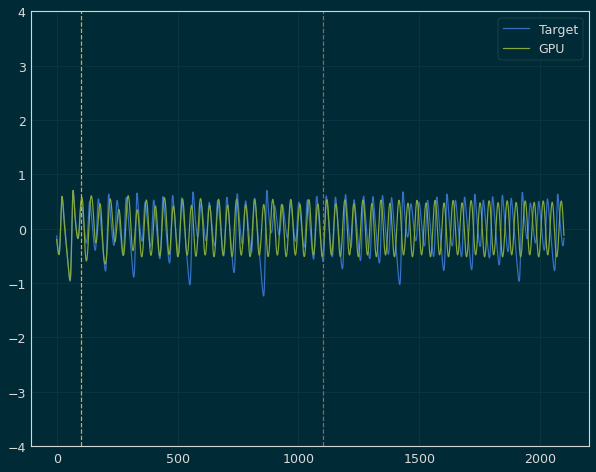

 Iter=46 a=0.035 sr=4.005 amp=0.239  ri=0.625 rr=4.497 loss=0.569719


Iter: 46 #### Diagnostic 0.569719   Time 12.77  Best 0.570 NRMSE 0.156 CD 0.413
Iter: 47 #### Diagnostic 1000.000000   Time 12.18  Best 0.570 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000000   Time 10.45  Best 0.570 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1.178486   Time 12.39  Best 0.570 NRMSE 0.187 CD 0.992
Iter: 50 #### Diagnostic 1.090841   Time 12.69  Best 0.570 NRMSE 0.210 CD 0.881
Iter: 51 #### Diagnostic 1.231077   Time 11.70  Best 0.570 NRMSE 0.194 CD 1.038
Iter: 52 #### Diagnostic 1.268402   Time 9.17  Best 0.570 NRMSE 0.322 CD 0.947
Iter: 53 #### Diagnostic 1000.000000   Time 8.26  Best 0.570 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000000   Time 12.56  Best 0.570 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000000   Time 12.40  Best 0.570 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000000   Time 8.17  Best 0.570 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 100

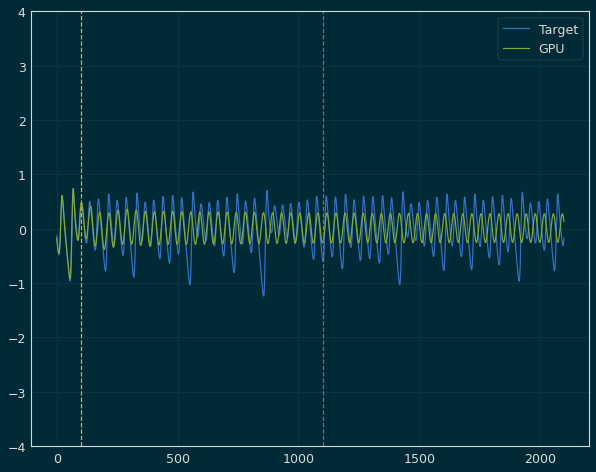

 Iter=30 a=0.037 sr=2.881 amp=0.070  ri=0.724 rr=0.178 loss=0.588532


Iter: 30 #### Diagnostic 0.588532   Time 8.08  Best 0.589 NRMSE 0.144 CD 0.445
Iter: 31 #### Diagnostic 0.777319   Time 8.29  Best 0.589 NRMSE 0.196 CD 0.581
Iter: 32 #### Diagnostic 1.101470   Time 8.30  Best 0.589 NRMSE 0.187 CD 0.915
Iter: 33 #### Diagnostic 1000.000000   Time 11.85  Best 0.589 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000000   Time 10.51  Best 0.589 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000000   Time 7.53  Best 0.589 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000000   Time 6.62  Best 0.589 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000000   Time 8.95  Best 0.589 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000000   Time 11.46  Best 0.589 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000000   Time 11.40  Best 0.589 NRMSE 1000.000 CD 1.001
Iter: 40 #### Diagnostic 1.064637   Time 7.71  Best 0.589 NRMSE 0.184 CD 0.881
Iter: 41 #### Diagnostic 1

Iter: 26 #### Diagnostic 1.535317   Time 11.43  Best 1000.000 NRMSE 0.536 CD 1.000
Iter: 27 #### Diagnostic 1000.000000   Time 10.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1.310712   Time 8.49  Best 1000.000 NRMSE 0.232 CD 1.079
Iter: 29 #### Diagnostic 1000.000000   Time 10.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 11.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1.117564   Time 8.78  Best 1000.000 NRMSE 0.185 CD 0.932
Iter: 32 #### Diagnostic 1.174361   Time 5.40  Best 1000.000 NRMSE 0.195 CD 0.980
Iter: 33 #### Diagnostic 1000.000000   Time 9.49  Best 1000.000 NRMSE 1000.000 CD 0.994
Iter: 34 #### Diagnostic 1.085968   Time 12.17  Best 1000.000 NRMSE 0.184 CD 0.902
Iter: 35 #### Diagnostic 1.071567   Time 11.60  Best 1000.000 NRMSE 0.184 CD 0.888
Iter: 36 #### Diagnostic 1000.000000   Time 12.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000000   Time 8.79  Best 1000.000 NRMSE

Iter: 20 #### Diagnostic 1000.000000   Time 11.42  Best 1000.000 NRMSE 1000.000 CD 1.000
Iter: 21 #### Diagnostic 1.019841   Time 10.70  Best 1000.000 NRMSE 0.183 CD 0.837
Iter: 22 #### Diagnostic 1000.000000   Time 9.49  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1.213102   Time 8.88  Best 1000.000 NRMSE 0.229 CD 0.984
Iter: 24 #### Diagnostic 1.338023   Time 7.88  Best 1000.000 NRMSE 0.330 CD 1.008
Iter: 25 #### Diagnostic 1000.000000   Time 12.77  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 8.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 10.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 10.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.207854   Time 9.46  Best 1000.000 NRMSE 0.207 CD 1.001
Iter: 30 #### Diagnostic 1000.000000   Time 11.01  Best 1000.000 NRMSE 894644055383155802112.000 CD 0.999
Iter: 31 #### Diagnostic 1000.000000   Time

Iter: 13 #### Diagnostic 1.535209   Time 7.61  Best 1000.000 NRMSE 0.536 CD 0.999
Iter: 14 #### Diagnostic 1000.000000   Time 11.53  Best 1000.000 NRMSE 1000.000 CD 0.970
Iter: 15 #### Diagnostic 1000.000000   Time 10.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 10.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1.327496   Time 9.20  Best 1000.000 NRMSE 0.277 CD 1.050
Iter: 18 #### Diagnostic 0.959565   Time 11.12  Best 1000.000 NRMSE 0.182 CD 0.778
Iter: 19 #### Diagnostic 1.538421   Time 9.89  Best 1000.000 NRMSE 0.536 CD 1.003
Iter: 20 #### Diagnostic 1.092188   Time 12.50  Best 1000.000 NRMSE 0.185 CD 0.908
Iter: 21 #### Diagnostic 1000.000000   Time 11.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 0.814116   Time 11.41  Best 1000.000 NRMSE 0.198 CD 0.616
Iter: 23 #### Diagnostic 1000.000000   Time 8.28  Best 1000.000 NRMSE 1000.000 CD 1.001
Iter: 24 #### Diagnostic 1000.000000   Time 8.36  Best 1000.000 NRM

Iter: 7 #### Diagnostic 1.547054   Time 11.36  Best 1000.000 NRMSE 0.536 CD 1.011
Iter: 8 #### Diagnostic 0.937564   Time 7.61  Best 1000.000 NRMSE 0.180 CD 0.757
Iter: 9 #### Diagnostic 1000.000000   Time 8.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 11.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1.260280   Time 9.14  Best 1000.000 NRMSE 0.220 CD 1.041
Iter: 12 #### Diagnostic 1000.000000   Time 12.82  Best 1000.000 NRMSE 1000.000 CD 1.000
Iter: 13 #### Diagnostic 1000.000000   Time 9.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000000   Time 10.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 11.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 12.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 7.24  Best 1000.000 NRMSE 26629346831099078472816918528.000 CD 1.072
Iter: 18 #### Diagnostic 1000.0000

Iter: 0 #### Diagnostic 0.792253   Time 10.25  Best 1000.000 NRMSE 0.202 CD 0.590
Iter: 1 #### Diagnostic 1000.000000   Time 8.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 8.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 11.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1.005608   Time 9.17  Best 1000.000 NRMSE 0.182 CD 0.823
Iter: 5 #### Diagnostic 1000.000000   Time 12.85  Best 1000.000 NRMSE 1000.000 CD 1.000
Iter: 6 #### Diagnostic 1000.000000   Time 13.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 11.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 0.739971   Time 7.88  Best 1000.000 NRMSE 0.167 CD 0.573
Iter: 9 #### Diagnostic 1000.000000   Time 6.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1.509921   Time 9.01  Best 1000.000 NRMSE 0.508 CD 1.002
Iter: 11 #### Diagnostic 1000.000000   Time 9.48  Best 1000.000 NRMSE 100

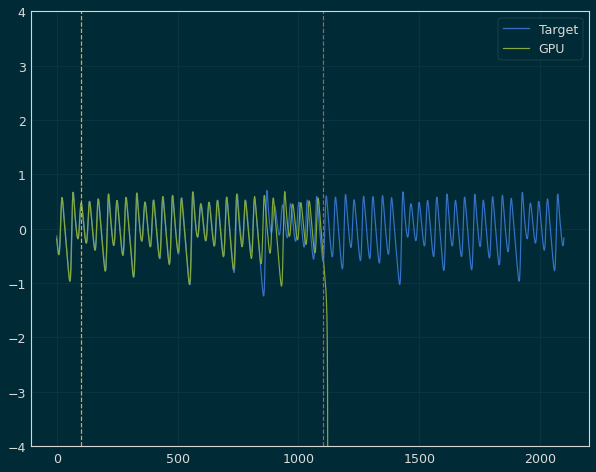

 Iter=90 a=0.992 sr=1.907 amp=0.819  ri=0.907 rr=3.572 loss=0.392727


Iter: 90 #### Diagnostic 0.392727   Time 10.34  Best 0.393 NRMSE 0.128 CD 0.264
Iter: 91 #### Diagnostic 1000.000000   Time 8.23  Best 0.393 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000000   Time 10.51  Best 0.393 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1.028537   Time 10.03  Best 0.393 NRMSE 0.183 CD 0.846
Iter: 94 #### Diagnostic 1.111430   Time 7.88  Best 0.393 NRMSE 0.185 CD 0.927
Iter: 95 #### Diagnostic 1000.000000   Time 12.93  Best 0.393 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000000   Time 7.76  Best 0.393 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 0.395684   Time 6.81  Best 0.393 NRMSE 0.135 CD 0.261
Iter: 98 #### Diagnostic 1.082502   Time 9.40  Best 0.393 NRMSE 0.184 CD 0.898
Iter: 99 #### Diagnostic 1.160504   Time 12.35  Best 0.393 NRMSE 0.194 CD 0.967

Best result = 0.3927265446047673
a = 0.9923620247307877
sr = 1.907415510855206
amp = 0.8189453982100876
ri = 0.906753

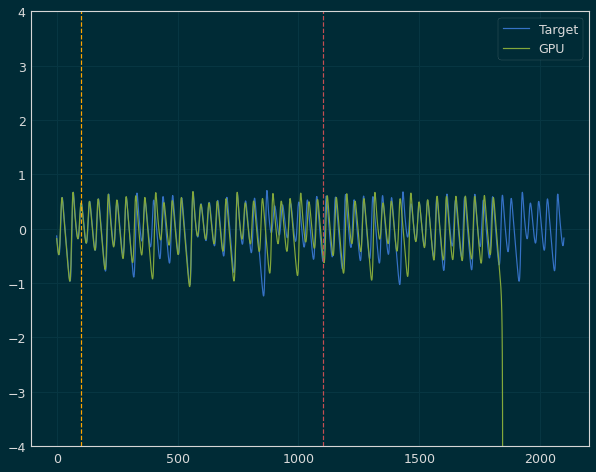

 Iter=77 a=0.270 sr=1.507 amp=0.806  ri=0.989 rr=0.167 loss=0.528813


Iter: 77 #### Diagnostic 0.528813   Time 13.49  Best 0.529 NRMSE 0.150 CD 0.379
Iter: 78 #### Diagnostic 1000.000000   Time 9.87  Best 0.529 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1.532604   Time 10.66  Best 0.529 NRMSE 0.536 CD 0.997
Iter: 80 #### Diagnostic 1000.000000   Time 6.87  Best 0.529 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1.538506   Time 12.72  Best 0.529 NRMSE 0.536 CD 1.003
Iter: 82 #### Diagnostic 1.533487   Time 8.11  Best 0.529 NRMSE 0.536 CD 0.998
Iter: 83 #### Diagnostic 0.952181   Time 8.16  Best 0.529 NRMSE 0.180 CD 0.772
Iter: 84 #### Diagnostic 1000.000000   Time 12.48  Best 0.529 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1.023607   Time 10.10  Best 0.529 NRMSE 0.183 CD 0.841
Iter: 86 #### Diagnostic 1000.000000   Time 9.41  Best 0.529 NRMSE 1000.000 CD 1.000
Iter: 87 #### Diagnostic 1000.000000   Time 7.61  Best 0.529 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000

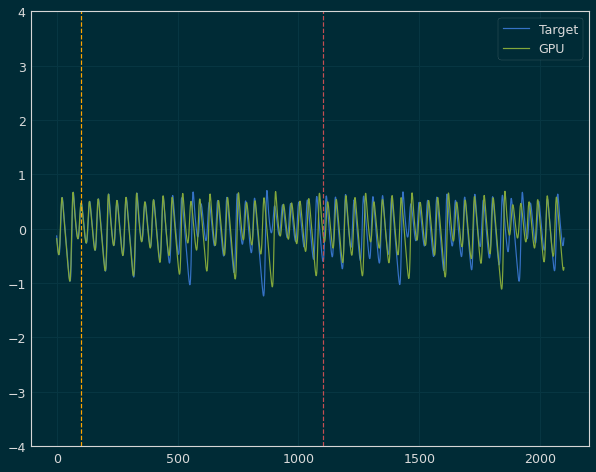

 Iter=34 a=0.720 sr=4.820 amp=0.232  ri=0.444 rr=3.216 loss=0.590714


Iter: 34 #### Diagnostic 0.590714   Time 11.30  Best 0.591 NRMSE 0.160 CD 0.430
Iter: 35 #### Diagnostic 1000.000000   Time 11.76  Best 0.591 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000000   Time 8.96  Best 0.591 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1.116410   Time 6.60  Best 0.591 NRMSE 0.189 CD 0.927
Iter: 38 #### Diagnostic 1000.000000   Time 12.73  Best 0.591 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000000   Time 10.64  Best 0.591 NRMSE 14188181258565.424 CD 1.003
Iter: 40 #### Diagnostic 1.066255   Time 11.37  Best 0.591 NRMSE 0.184 CD 0.882
Iter: 41 #### Diagnostic 1000.000000   Time 8.98  Best 0.591 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000000   Time 7.70  Best 0.591 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1.272852   Time 9.44  Best 0.591 NRMSE 0.203 CD 1.070
Iter: 44 #### Diagnostic 1000.000000   Time 8.72  Best 0.591 NRMSE 1000.000 CD nan
Iter: 45 #### D

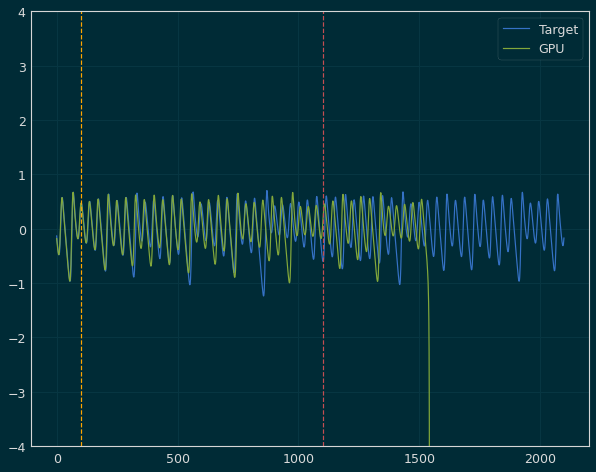

 Iter=97 a=0.456 sr=3.176 amp=0.325  ri=0.475 rr=4.335 loss=0.543679


Iter: 97 #### Diagnostic 0.543679   Time 12.18  Best 0.544 NRMSE 0.151 CD 0.393
Iter: 98 #### Diagnostic 1000.000000   Time 7.90  Best 0.544 NRMSE 33775841351678656.000 CD 0.982
Iter: 99 #### Diagnostic 1.536704   Time 10.88  Best 0.544 NRMSE 0.536 CD 1.001

Best result = 0.543679121418981
a = 0.4564743938461775
sr = 3.175800413434468
amp = 0.32451025744591405
ri = 0.47548188660427276
rr = 4.335174181102914
********** Size 800 -- Run 3 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 9.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000000   Time 10.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 8.74  Best 1000.000 NRMSE 1000.000 CD 1.001
Iter: 3 #### Diagnostic 1.467596   Time 8.09  Best 1000.000 NRMSE 0.468 CD 1.000
Iter: 4 #### Diagnostic 1000.000000   Time 10.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 8.74  Bes

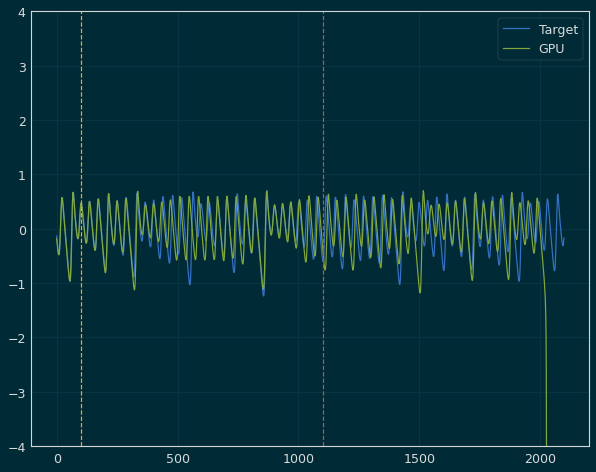

 Iter=26 a=0.520 sr=2.100 amp=0.658  ri=0.652 rr=2.583 loss=0.480497


Iter: 26 #### Diagnostic 0.480497   Time 12.56  Best 0.480 NRMSE 0.150 CD 0.330
Iter: 27 #### Diagnostic 1000.000000   Time 9.35  Best 0.480 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 10.63  Best 0.480 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 0.876245   Time 9.08  Best 0.480 NRMSE 0.178 CD 0.698
Iter: 30 #### Diagnostic 1000.000000   Time 10.66  Best 0.480 NRMSE 38241029631873185880804228595712.000 CD 0.999
Iter: 31 #### Diagnostic 1000.000000   Time 8.55  Best 0.480 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000000   Time 10.99  Best 0.480 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1.082321   Time 10.52  Best 0.480 NRMSE 0.242 CD 0.840
Iter: 34 #### Diagnostic 1000.000000   Time 9.54  Best 0.480 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000000   Time 10.84  Best 0.480 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1.556351   Time 10.26  Best 0.480 NRMSE 0.536 CD 1

Iter: 22 #### Diagnostic 1.542677   Time 10.87  Best 1000.000 NRMSE 0.536 CD 1.007
Iter: 23 #### Diagnostic 1.513774   Time 9.63  Best 1000.000 NRMSE 0.526 CD 0.988
Iter: 24 #### Diagnostic 1000.000000   Time 12.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 10.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 11.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1.193412   Time 11.44  Best 1000.000 NRMSE 0.208 CD 0.985
Iter: 28 #### Diagnostic 1000.000000   Time 8.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000000   Time 9.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 10.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1.541049   Time 8.04  Best 1000.000 NRMSE 0.536 CD 1.005
Iter: 32 #### Diagnostic 1000.000000   Time 11.52  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 0.996928   Time 13.20  Best 1000.000 N

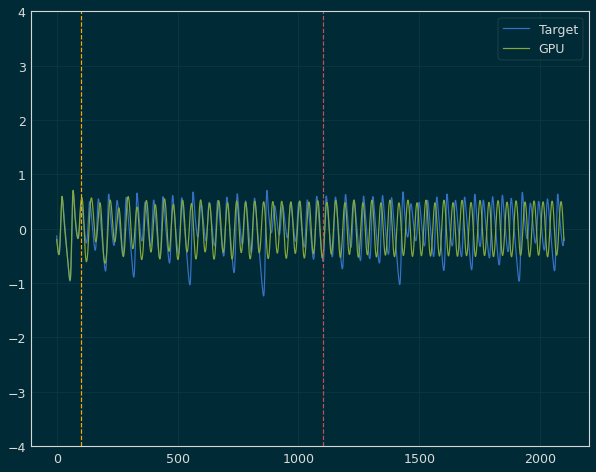

 Iter=46 a=0.035 sr=4.005 amp=0.239  ri=0.625 rr=4.497 loss=0.585784


Iter: 46 #### Diagnostic 0.585784   Time 10.64  Best 0.586 NRMSE 0.157 CD 0.429
Iter: 47 #### Diagnostic 1000.000000   Time 11.28  Best 0.586 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000000   Time 10.83  Best 0.586 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1.170558   Time 10.41  Best 0.586 NRMSE 0.187 CD 0.984
Iter: 50 #### Diagnostic 1.288862   Time 10.17  Best 0.586 NRMSE 0.219 CD 1.070
Iter: 51 #### Diagnostic 1.220307   Time 10.29  Best 0.586 NRMSE 0.193 CD 1.027
Iter: 52 #### Diagnostic 1.358670   Time 9.54  Best 0.586 NRMSE 0.350 CD 1.008
Iter: 53 #### Diagnostic 1000.000000   Time 10.89  Best 0.586 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000000   Time 7.06  Best 0.586 NRMSE 1000.000 CD 1.018
Iter: 55 #### Diagnostic 1000.000000   Time 11.30  Best 0.586 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000000   Time 8.57  Best 0.586 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1

Iter: 35 #### Diagnostic 1000.000000   Time 10.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000000   Time 7.52  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000000   Time 8.16  Best 1000.000 NRMSE 1000.000 CD 0.999
Iter: 38 #### Diagnostic 1000.000000   Time 11.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1.299865   Time 13.40  Best 1000.000 NRMSE 0.276 CD 1.024
Iter: 40 #### Diagnostic 1.064671   Time 10.53  Best 1000.000 NRMSE 0.184 CD 0.881
Iter: 41 #### Diagnostic 1.113084   Time 7.61  Best 1000.000 NRMSE 0.185 CD 0.928
Iter: 42 #### Diagnostic 1.106298   Time 12.44  Best 1000.000 NRMSE 0.185 CD 0.921
Iter: 43 #### Diagnostic 1.283762   Time 11.86  Best 1000.000 NRMSE 0.258 CD 1.025
Iter: 44 #### Diagnostic 1000.000000   Time 10.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 10.24  Best 1000.000 NRMSE 54950703384447.750 CD 0.989
Iter: 46 #### Diagnostic 1000.000000   Time 10.74  B

Iter: 29 #### Diagnostic 1000.000000   Time 12.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 10.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1.118030   Time 9.08  Best 1000.000 NRMSE 0.185 CD 0.933
Iter: 32 #### Diagnostic 1.190753   Time 5.74  Best 1000.000 NRMSE 0.195 CD 0.996
Iter: 33 #### Diagnostic 1000.000000   Time 10.55  Best 1000.000 NRMSE 1000.000 CD 1.002
Iter: 34 #### Diagnostic 1.096355   Time 10.29  Best 1000.000 NRMSE 0.184 CD 0.912
Iter: 35 #### Diagnostic 1.073659   Time 10.36  Best 1000.000 NRMSE 0.184 CD 0.890
Iter: 36 #### Diagnostic 1000.000000   Time 7.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000000   Time 8.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1.541412   Time 8.44  Best 1000.000 NRMSE 0.536 CD 1.006
Iter: 39 #### Diagnostic 1000.000000   Time 9.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000000   Time 10.03  Best 1000.000 NR

Iter: 23 #### Diagnostic 1.130697   Time 9.27  Best 1000.000 NRMSE 0.219 CD 0.911
Iter: 24 #### Diagnostic 1.257038   Time 10.06  Best 1000.000 NRMSE 0.263 CD 0.994
Iter: 25 #### Diagnostic 0.735218   Time 13.56  Best 1000.000 NRMSE 0.192 CD 0.544
Iter: 26 #### Diagnostic 1000.000000   Time 11.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 12.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 10.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.095877   Time 9.26  Best 1000.000 NRMSE 0.207 CD 0.889
Iter: 30 #### Diagnostic 1000.000000   Time 10.62  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000000   Time 8.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1.284175   Time 12.64  Best 1000.000 NRMSE 0.218 CD 1.066
Iter: 33 #### Diagnostic 1.050181   Time 13.35  Best 1000.000 NRMSE 0.184 CD 0.867
Iter: 34 #### Diagnostic 1000.000000   Time 7.16  Best 1000.000 NRMSE 

Iter: 17 #### Diagnostic 1.487762   Time 9.28  Best 1000.000 NRMSE 0.474 CD 1.014
Iter: 18 #### Diagnostic 0.973959   Time 11.38  Best 1000.000 NRMSE 0.182 CD 0.792
Iter: 19 #### Diagnostic 1000.000000   Time 10.17  Best 1000.000 NRMSE 1000.000 CD 0.994
Iter: 20 #### Diagnostic 1.118717   Time 12.40  Best 1000.000 NRMSE 0.186 CD 0.933
Iter: 21 #### Diagnostic 1000.000000   Time 9.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 10.17  Best 1000.000 NRMSE 1000.000 CD 1.017
Iter: 23 #### Diagnostic 1000.000000   Time 11.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1.241562   Time 9.17  Best 1000.000 NRMSE 0.242 CD 1.000
Iter: 25 #### Diagnostic 1.544222   Time 9.24  Best 1000.000 NRMSE 0.536 CD 1.008
Iter: 26 #### Diagnostic 0.840650   Time 10.10  Best 1000.000 NRMSE 0.197 CD 0.644
Iter: 27 #### Diagnostic 1000.000000   Time 7.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 9.95  Best 1000.000 NRMS

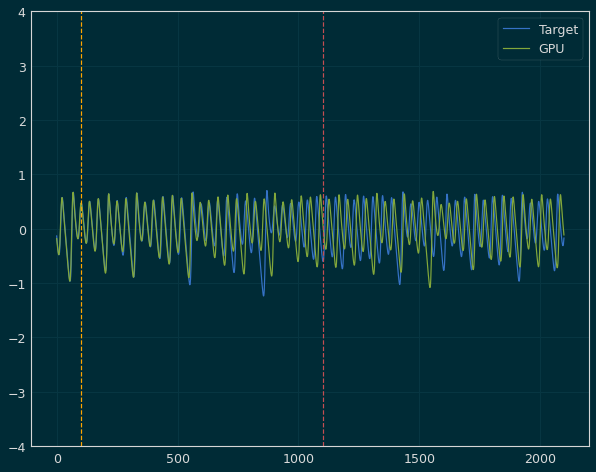

 Iter=69 a=0.107 sr=1.357 amp=0.951  ri=0.828 rr=4.343 loss=0.574769


Iter: 69 #### Diagnostic 0.574769   Time 11.37  Best 0.575 NRMSE 0.162 CD 0.413
Iter: 70 #### Diagnostic 1000.000000   Time 9.99  Best 0.575 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1.369973   Time 8.54  Best 0.575 NRMSE 0.359 CD 1.011
Iter: 72 #### Diagnostic 1000.000000   Time 10.80  Best 0.575 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000000   Time 12.06  Best 0.575 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000000   Time 11.78  Best 0.575 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000000   Time 11.84  Best 0.575 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000000   Time 10.26  Best 0.575 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1.048520   Time 9.07  Best 0.575 NRMSE 0.183 CD 0.865
Iter: 78 #### Diagnostic 1.166404   Time 8.08  Best 0.575 NRMSE 0.198 CD 0.968
Iter: 79 #### Diagnostic 1000.000000   Time 6.47  Best 0.575 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1

Iter: 63 #### Diagnostic 1000.000000   Time 14.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000000   Time 14.49  Best 1000.000 NRMSE 1000.000 CD 1.016
Iter: 65 #### Diagnostic 1.095008   Time 14.51  Best 1000.000 NRMSE 0.185 CD 0.910
Iter: 66 #### Diagnostic 1000.000000   Time 7.59  Best 1000.000 NRMSE 1000.000 CD 0.992
Iter: 67 #### Diagnostic 1000.000000   Time 10.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 9.93  Best 1000.000 NRMSE 1000.000 CD 0.922
Iter: 69 #### Diagnostic 1000.000000   Time 11.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000000   Time 10.24  Best 1000.000 NRMSE 1000.000 CD 1.000
Iter: 71 #### Diagnostic 1000.000000   Time 9.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000000   Time 11.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1.233700   Time 8.19  Best 1000.000 NRMSE 0.225 CD 1.009
Iter: 74 #### Diagnostic 1000.000000   Time 11.

Iter: 51 #### Diagnostic 1000.000000   Time 8.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000000   Time 8.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000000   Time 9.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1.162624   Time 8.93  Best 1000.000 NRMSE 0.186 CD 0.977
Iter: 55 #### Diagnostic 1.256098   Time 10.68  Best 1000.000 NRMSE 0.226 CD 1.030
Iter: 56 #### Diagnostic 1.530681   Time 6.58  Best 1000.000 NRMSE 0.536 CD 0.995
Iter: 57 #### Diagnostic 1000.000000   Time 9.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 10.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000000   Time 11.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000000   Time 11.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 8.63  Best 1000.000 NRMSE 10464.001 CD 0.992
Iter: 62 #### Diagnostic 1000.000000   Time 15.28  Best 100

Iter: 45 #### Diagnostic 1.314701   Time 10.95  Best 1000.000 NRMSE 0.241 CD 1.074
Iter: 46 #### Diagnostic 0.992972   Time 10.02  Best 1000.000 NRMSE 0.182 CD 0.811
Iter: 47 #### Diagnostic 1000.000000   Time 10.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 0.981730   Time 6.79  Best 1000.000 NRMSE 0.182 CD 0.800
Iter: 49 #### Diagnostic 1.089015   Time 8.43  Best 1000.000 NRMSE 0.195 CD 0.894
Iter: 50 #### Diagnostic 1.269100   Time 8.33  Best 1000.000 NRMSE 0.222 CD 1.047
Iter: 51 #### Diagnostic 1000.000000   Time 10.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1.020851   Time 9.89  Best 1000.000 NRMSE 0.182 CD 0.838
Iter: 53 #### Diagnostic 1000.000000   Time 10.06  Best 1000.000 NRMSE 1000.000 CD 1.152
Iter: 54 #### Diagnostic 0.820720   Time 8.06  Best 1000.000 NRMSE 0.204 CD 0.617
Iter: 55 #### Diagnostic 1.549378   Time 8.64  Best 1000.000 NRMSE 0.536 CD 1.014
Iter: 56 #### Diagnostic 1000.000000   Time 9.81  Best 1000.000 NRMSE 235481837

Iter: 39 #### Diagnostic 1000.000000   Time 7.60  Best 1000.000 NRMSE 2006052161064.541 CD 0.998
Iter: 40 #### Diagnostic 1.067106   Time 7.79  Best 1000.000 NRMSE 0.184 CD 0.883
Iter: 41 #### Diagnostic 1000.000000   Time 8.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000000   Time 8.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1.268651   Time 8.59  Best 1000.000 NRMSE 0.202 CD 1.067
Iter: 44 #### Diagnostic 1000.000000   Time 7.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 7.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000000   Time 7.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1.102538   Time 10.12  Best 1000.000 NRMSE 0.185 CD 0.918
Iter: 48 #### Diagnostic 0.909015   Time 11.02  Best 1000.000 NRMSE 0.186 CD 0.723
Iter: 49 #### Diagnostic 1.217752   Time 11.12  Best 1000.000 NRMSE 0.202 CD 1.015
Iter: 50 #### Diagnostic 1000.000000   Time 9.28  Best 1000.

Iter: 33 #### Diagnostic 0.673297   Time 11.10  Best 1000.000 NRMSE 0.179 CD 0.494
Iter: 34 #### Diagnostic 1000.000000   Time 10.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000000   Time 11.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1.564040   Time 12.79  Best 1000.000 NRMSE 0.536 CD 1.028
Iter: 37 #### Diagnostic 1.092831   Time 7.61  Best 1000.000 NRMSE 0.185 CD 0.908
Iter: 38 #### Diagnostic 1.092740   Time 8.22  Best 1000.000 NRMSE 0.190 CD 0.903
Iter: 39 #### Diagnostic 1.070788   Time 11.54  Best 1000.000 NRMSE 0.184 CD 0.887
Iter: 40 #### Diagnostic 1.114607   Time 9.47  Best 1000.000 NRMSE 0.185 CD 0.929
Iter: 41 #### Diagnostic 1000.000000   Time 8.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000000   Time 9.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1000.000000   Time 11.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000000   Time 11.19  Best 1000.000 NRMSE 1

Iter: 27 #### Diagnostic 1000.000000   Time 12.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 8.80  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.545282   Time 9.01  Best 1000.000 NRMSE 0.536 CD 1.009
Iter: 30 #### Diagnostic 1000.000000   Time 7.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000000   Time 9.34  Best 1000.000 NRMSE 1000.000 CD 0.994
Iter: 32 #### Diagnostic 1000.000000   Time 12.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 1.001963   Time 11.85  Best 1000.000 NRMSE 0.182 CD 0.820
Iter: 34 #### Diagnostic 1.075054   Time 10.50  Best 1000.000 NRMSE 0.184 CD 0.891
Iter: 35 #### Diagnostic 1000.000000   Time 13.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1.035821   Time 10.22  Best 1000.000 NRMSE 0.183 CD 0.853
Iter: 37 #### Diagnostic 1000.000000   Time 8.64  Best 1000.000 NRMSE 1000.000 CD 1.003
Iter: 38 #### Diagnostic 1000.000000   Time 9.78  Best 1000.

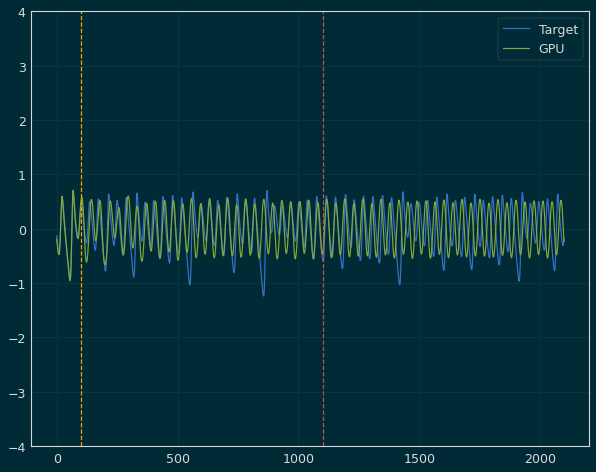

 Iter=46 a=0.035 sr=4.005 amp=0.239  ri=0.625 rr=4.497 loss=0.599700


Iter: 46 #### Diagnostic 0.599700   Time 8.31  Best 0.600 NRMSE 0.161 CD 0.439
Iter: 47 #### Diagnostic 1000.000000   Time 9.42  Best 0.600 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000000   Time 10.85  Best 0.600 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1.165700   Time 10.73  Best 0.600 NRMSE 0.186 CD 0.979
Iter: 50 #### Diagnostic 1.237945   Time 10.73  Best 0.600 NRMSE 0.214 CD 1.024
Iter: 51 #### Diagnostic 1.227915   Time 7.93  Best 0.600 NRMSE 0.193 CD 1.035
Iter: 52 #### Diagnostic 1.246941   Time 10.08  Best 0.600 NRMSE 0.333 CD 0.914
Iter: 53 #### Diagnostic 1000.000000   Time 13.19  Best 0.600 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000000   Time 7.85  Best 0.600 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000000   Time 9.14  Best 0.600 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1.542917   Time 7.36  Best 0.600 NRMSE 0.536 CD 1.007
Iter: 57 #### Diagnostic 1000.00000

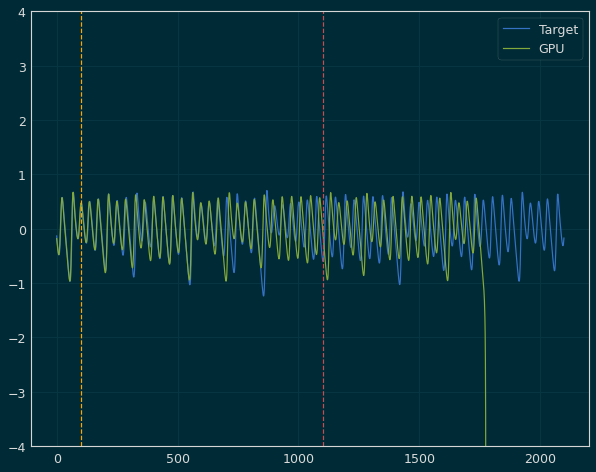

 Iter=90 a=0.073 sr=3.242 amp=0.359  ri=0.643 rr=3.085 loss=0.576962


Iter: 90 #### Diagnostic 0.576962   Time 9.23  Best 0.577 NRMSE 0.164 CD 0.413
Iter: 91 #### Diagnostic 1000.000000   Time 12.06  Best 0.577 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1.086407   Time 14.24  Best 0.577 NRMSE 0.197 CD 0.889
Iter: 93 #### Diagnostic 1.174414   Time 10.83  Best 0.577 NRMSE 0.207 CD 0.968
Iter: 94 #### Diagnostic 1000.000000   Time 8.19  Best 0.577 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1.087904   Time 7.31  Best 0.577 NRMSE 0.185 CD 0.903
Iter: 96 #### Diagnostic 1000.000000   Time 7.95  Best 0.577 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000000   Time 9.99  Best 0.577 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1000.000000   Time 9.86  Best 0.577 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1.012519   Time 13.33  Best 0.577 NRMSE 0.183 CD 0.830

Best result = 0.5769616784345302
a = 0.07312120242550901
sr = 3.2415665546836987
amp = 0.3587093778449947
ri = 0.6

Iter: 77 #### Diagnostic 1.141074   Time 6.11  Best 1000.000 NRMSE 0.186 CD 0.955
Iter: 78 #### Diagnostic 1.152362   Time 12.09  Best 1000.000 NRMSE 0.193 CD 0.959
Iter: 79 #### Diagnostic 1000.000000   Time 8.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000000   Time 8.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 0.623530   Time 7.20  Best 1000.000 NRMSE 0.173 CD 0.450
Iter: 82 #### Diagnostic 1000.000000   Time 11.25  Best 1000.000 NRMSE 17855589315845956601311288885248.000 CD 0.993
Iter: 83 #### Diagnostic 1.078885   Time 10.70  Best 1000.000 NRMSE 0.205 CD 0.874
Iter: 84 #### Diagnostic 0.616784   Time 9.71  Best 1000.000 NRMSE 0.176 CD 0.441
Iter: 85 #### Diagnostic 1.534006   Time 10.56  Best 1000.000 NRMSE 0.536 CD 0.998
Iter: 86 #### Diagnostic 1000.000000   Time 9.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1000.000000   Time 10.21  Best 1000.000 NRMSE 1000.000 CD 1.000
Iter: 88 #### Diagnostic 1000.000000   Ti

Iter: 71 #### Diagnostic 1.515764   Time 9.80  Best 1000.000 NRMSE 0.508 CD 1.008
Iter: 72 #### Diagnostic 1000.000000   Time 7.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000000   Time 9.51  Best 1000.000 NRMSE 1000.000 CD 0.992
Iter: 74 #### Diagnostic 1000.000000   Time 7.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000000   Time 13.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000000   Time 11.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 0.786338   Time 11.83  Best 1000.000 NRMSE 0.195 CD 0.591
Iter: 78 #### Diagnostic 1000.000000   Time 12.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1000.000000   Time 11.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000000   Time 10.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1.535114   Time 9.40  Best 1000.000 NRMSE 0.536 CD 0.999
Iter: 82 #### Diagnostic 1000.000000   Time 8.18  Best 100

Iter: 65 #### Diagnostic 1000.000000   Time 9.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1.304720   Time 10.91  Best 1000.000 NRMSE 0.271 CD 1.034
Iter: 67 #### Diagnostic 1.087680   Time 9.43  Best 1000.000 NRMSE 0.184 CD 0.903
Iter: 68 #### Diagnostic 1000.000000   Time 8.95  Best 1000.000 NRMSE 748753051848864820942974392205312.000 CD 0.996
Iter: 69 #### Diagnostic 1.156692   Time 9.75  Best 1000.000 NRMSE 0.187 CD 0.970
Iter: 70 #### Diagnostic 1.061823   Time 11.30  Best 1000.000 NRMSE 0.184 CD 0.878
Iter: 71 #### Diagnostic 1000.000000   Time 8.75  Best 1000.000 NRMSE 1000.000 CD 1.003
Iter: 72 #### Diagnostic 1.172935   Time 7.53  Best 1000.000 NRMSE 0.203 CD 0.970
Iter: 73 #### Diagnostic 1000.000000   Time 8.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000000   Time 9.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000000   Time 10.68  Best 1000.000 NRMSE 228710042571032344917530640384.000 CD 1.013
Iter: 76 #

Iter: 58 #### Diagnostic 1000.000000   Time 10.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000000   Time 8.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1.483397   Time 9.58  Best 1000.000 NRMSE 0.498 CD 0.985
Iter: 61 #### Diagnostic 1.540503   Time 6.90  Best 1000.000 NRMSE 0.536 CD 1.005
Iter: 62 #### Diagnostic 0.961914   Time 9.09  Best 1000.000 NRMSE 0.182 CD 0.780
Iter: 63 #### Diagnostic 1000.000000   Time 8.78  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000000   Time 10.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1.089584   Time 10.23  Best 1000.000 NRMSE 0.184 CD 0.905
Iter: 66 #### Diagnostic 1000.000000   Time 9.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 11.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 9.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1.537233   Time 7.41  Best 1000.000 NRMSE

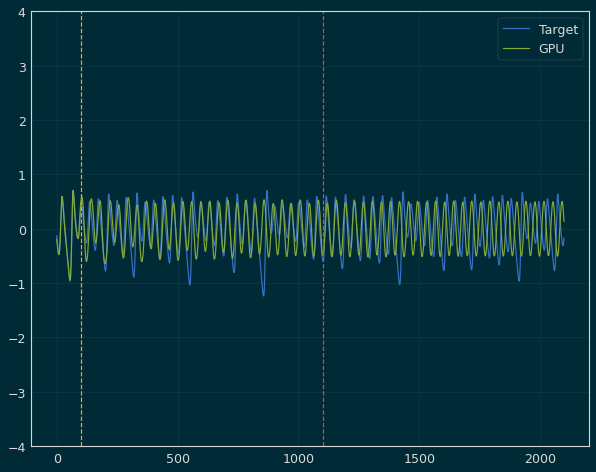

 Iter=46 a=0.035 sr=4.005 amp=0.239  ri=0.625 rr=4.497 loss=0.588835


Iter: 46 #### Diagnostic 0.588835   Time 8.35  Best 0.589 NRMSE 0.160 CD 0.429
Iter: 47 #### Diagnostic 1000.000000   Time 9.48  Best 0.589 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000000   Time 9.64  Best 0.589 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1.170914   Time 7.24  Best 0.589 NRMSE 0.187 CD 0.984
Iter: 50 #### Diagnostic 1.099518   Time 8.87  Best 0.589 NRMSE 0.207 CD 0.892
Iter: 51 #### Diagnostic 1.214872   Time 7.22  Best 0.589 NRMSE 0.193 CD 1.022
Iter: 52 #### Diagnostic 1.253913   Time 7.92  Best 0.589 NRMSE 0.320 CD 0.934
Iter: 53 #### Diagnostic 1000.000000   Time 10.06  Best 0.589 NRMSE 1000.000 CD 0.986
Iter: 54 #### Diagnostic 1000.000000   Time 10.78  Best 0.589 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000000   Time 8.93  Best 0.589 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1.544879   Time 8.74  Best 0.589 NRMSE 0.536 CD 1.009
Iter: 57 #### Diagnostic 1.540358   

Iter: 34 #### Diagnostic 1000.000000   Time 9.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1.188775   Time 11.24  Best 1000.000 NRMSE 0.232 CD 0.956
Iter: 36 #### Diagnostic 1000.000000   Time 9.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1.543614   Time 8.09  Best 1000.000 NRMSE 0.536 CD 1.008
Iter: 38 #### Diagnostic 1000.000000   Time 9.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 0.653155   Time 9.06  Best 1000.000 NRMSE 0.170 CD 0.483
Iter: 40 #### Diagnostic 1.065617   Time 10.77  Best 1000.000 NRMSE 0.184 CD 0.881
Iter: 41 #### Diagnostic 1.119564   Time 10.93  Best 1000.000 NRMSE 0.185 CD 0.934
Iter: 42 #### Diagnostic 1.104493   Time 6.38  Best 1000.000 NRMSE 0.185 CD 0.920
Iter: 43 #### Diagnostic 1000.000000   Time 8.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000000   Time 8.16  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1.545997   Time 10.45  Best 1000.000 NRMSE 0.536 C

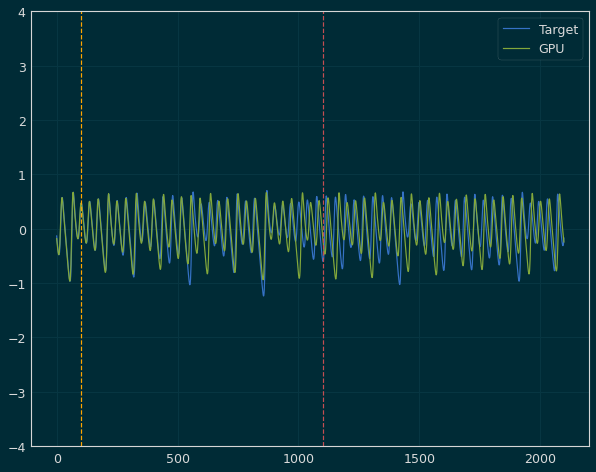

 Iter=91 a=0.272 sr=1.374 amp=0.774  ri=0.901 rr=4.851 loss=0.478613


Iter: 91 #### Diagnostic 0.478613   Time 10.92  Best 0.479 NRMSE 0.149 CD 0.329
Iter: 92 #### Diagnostic 1000.000000   Time 9.76  Best 0.479 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1.008917   Time 6.42  Best 0.479 NRMSE 0.182 CD 0.827
Iter: 94 #### Diagnostic 1.112366   Time 4.92  Best 0.479 NRMSE 0.185 CD 0.927
Iter: 95 #### Diagnostic 1.544253   Time 10.24  Best 0.479 NRMSE 0.536 CD 1.008
Iter: 96 #### Diagnostic 1000.000000   Time 6.75  Best 0.479 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1.541461   Time 10.08  Best 0.479 NRMSE 0.536 CD 1.006
Iter: 98 #### Diagnostic 1.088066   Time 10.91  Best 0.479 NRMSE 0.185 CD 0.904
Iter: 99 #### Diagnostic 1.169216   Time 8.90  Best 0.479 NRMSE 0.199 CD 0.970

Best result = 0.4786130289999826
a = 0.27230973147805204
sr = 1.3740994519649334
amp = 0.7743398010973204
ri = 0.9009430571306739
rr = 4.851313897654532
********** Size 700 -- Run 1 ***********
Iter: 0 ###

Iter: 85 #### Diagnostic 1.023315   Time 10.81  Best 1000.000 NRMSE 0.183 CD 0.841
Iter: 86 #### Diagnostic 1.536842   Time 7.64  Best 1000.000 NRMSE 0.536 CD 1.001
Iter: 87 #### Diagnostic 1000.000000   Time 8.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000000   Time 7.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1000.000000   Time 8.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1000.000000   Time 8.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1.527505   Time 7.61  Best 1000.000 NRMSE 0.529 CD 0.998
Iter: 92 #### Diagnostic 1.069375   Time 8.34  Best 1000.000 NRMSE 0.185 CD 0.885
Iter: 93 #### Diagnostic 1000.000000   Time 9.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1.199848   Time 8.92  Best 1000.000 NRMSE 0.194 CD 1.006
Iter: 95 #### Diagnostic 1000.000000   Time 8.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000000   Time 8.63  Best 1000.000 NRMSE 100

Iter: 79 #### Diagnostic 1000.000000   Time 9.52  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1.050915   Time 6.79  Best 1000.000 NRMSE 0.184 CD 0.867
Iter: 81 #### Diagnostic 1000.000000   Time 8.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1.095936   Time 9.30  Best 1000.000 NRMSE 0.188 CD 0.908
Iter: 83 #### Diagnostic 1.543611   Time 8.04  Best 1000.000 NRMSE 0.536 CD 1.008
Iter: 84 #### Diagnostic 1000.000000   Time 8.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1.109663   Time 7.12  Best 1000.000 NRMSE 0.185 CD 0.924
Iter: 86 #### Diagnostic 1000.000000   Time 7.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1000.000000   Time 8.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000000   Time 7.16  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1000.000000   Time 9.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1000.000000   Time 7.16  Best 1000.000 NRMSE 

Iter: 73 #### Diagnostic 1000.000000   Time 10.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000000   Time 9.16  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000000   Time 9.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000000   Time 9.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1.056402   Time 9.93  Best 1000.000 NRMSE 0.184 CD 0.873
Iter: 78 #### Diagnostic 1.211553   Time 10.13  Best 1000.000 NRMSE 0.205 CD 1.006
Iter: 79 #### Diagnostic 1000.000000   Time 8.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1.175604   Time 7.32  Best 1000.000 NRMSE 0.189 CD 0.986
Iter: 81 #### Diagnostic 1000.000000   Time 8.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 0.985051   Time 9.16  Best 1000.000 NRMSE 0.182 CD 0.803
Iter: 83 #### Diagnostic 1000.000000   Time 10.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1000.000000   Time 9.37  Best 1000.000 NRM

Iter: 67 #### Diagnostic 1000.000000   Time 8.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 7.49  Best 1000.000 NRMSE 1000.000 CD 1.001
Iter: 69 #### Diagnostic 1000.000000   Time 9.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000000   Time 6.73  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000000   Time 8.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000000   Time 9.26  Best 1000.000 NRMSE 958800957.737 CD 0.988
Iter: 73 #### Diagnostic 1.157850   Time 6.75  Best 1000.000 NRMSE 0.201 CD 0.957
Iter: 74 #### Diagnostic 1000.000000   Time 10.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000000   Time 9.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000000   Time 8.94  Best 1000.000 NRMSE 1000.000 CD 0.995
Iter: 77 #### Diagnostic 1.157923   Time 8.84  Best 1000.000 NRMSE 0.189 CD 0.969
Iter: 78 #### Diagnostic 1000.000000   Time 6.51  

Iter: 54 #### Diagnostic 1.163479   Time 7.70  Best 1000.000 NRMSE 0.186 CD 0.977
Iter: 55 #### Diagnostic 1.262023   Time 10.62  Best 1000.000 NRMSE 0.226 CD 1.036
Iter: 56 #### Diagnostic 1000.000000   Time 9.12  Best 1000.000 NRMSE 1000.000 CD 0.918
Iter: 57 #### Diagnostic 1000.000000   Time 7.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 8.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 0.718684   Time 10.66  Best 1000.000 NRMSE 0.188 CD 0.531
Iter: 60 #### Diagnostic 1000.000000   Time 9.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 0.783039   Time 8.75  Best 1000.000 NRMSE 0.192 CD 0.591
Iter: 62 #### Diagnostic 1000.000000   Time 9.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000000   Time 9.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000000   Time 9.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1.087742   Time 8.80  Best 1000.000 NRMSE

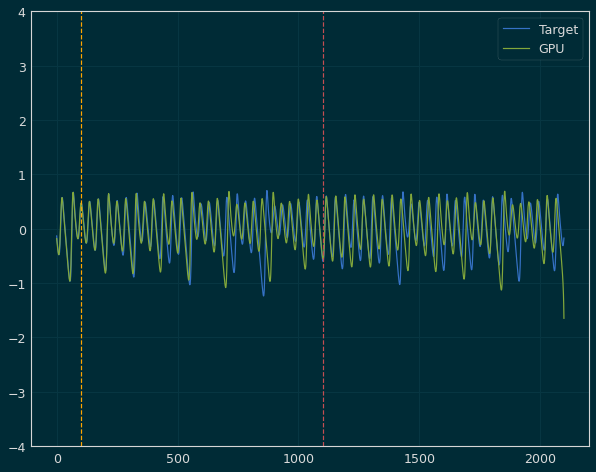

 Iter=71 a=0.438 sr=7.860 amp=0.226  ri=0.823 rr=2.775 loss=0.557981


Iter: 71 #### Diagnostic 0.557981   Time 10.62  Best 0.558 NRMSE 0.153 CD 0.405
Iter: 72 #### Diagnostic 1000.000000   Time 10.99  Best 0.558 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 0.602910   Time 8.12  Best 0.558 NRMSE 0.167 CD 0.436
Iter: 74 #### Diagnostic 1000.000000   Time 7.04  Best 0.558 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 0.931456   Time 8.15  Best 0.558 NRMSE 0.180 CD 0.751
Iter: 76 #### Diagnostic 1000.000000   Time 7.34  Best 0.558 NRMSE 4478429779939693056.000 CD 0.996
Iter: 77 #### Diagnostic 1.132679   Time 5.66  Best 0.558 NRMSE 0.186 CD 0.947
Iter: 78 #### Diagnostic 1.157574   Time 8.02  Best 0.558 NRMSE 0.195 CD 0.963
Iter: 79 #### Diagnostic 1000.000000   Time 9.47  Best 0.558 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000000   Time 7.82  Best 0.558 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1000.000000   Time 9.32  Best 0.558 NRMSE 1000.000 CD nan
Iter: 82 #### Dia

Iter: 66 #### Diagnostic 1000.000000   Time 9.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 10.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 7.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000000   Time 7.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000000   Time 7.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1.444118   Time 8.70  Best 1000.000 NRMSE 0.454 CD 0.990
Iter: 72 #### Diagnostic 1000.000000   Time 11.55  Best 1000.000 NRMSE 11123579780798869504.000 CD 1.009
Iter: 73 #### Diagnostic 1000.000000   Time 8.31  Best 1000.000 NRMSE 1000.000 CD 0.993
Iter: 74 #### Diagnostic 1000.000000   Time 5.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000000   Time 7.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000000   Time 6.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1000.000000

Iter: 60 #### Diagnostic 1000.000000   Time 8.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 7.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 7.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1.060962   Time 7.97  Best 1000.000 NRMSE 0.184 CD 0.877
Iter: 64 #### Diagnostic 1.543912   Time 10.99  Best 1000.000 NRMSE 0.536 CD 1.008
Iter: 65 #### Diagnostic 1000.000000   Time 9.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1.353210   Time 7.87  Best 1000.000 NRMSE 0.256 CD 1.097
Iter: 67 #### Diagnostic 1.065280   Time 6.62  Best 1000.000 NRMSE 0.184 CD 0.882
Iter: 68 #### Diagnostic 1000.000000   Time 11.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1.224119   Time 9.14  Best 1000.000 NRMSE 0.199 CD 1.026
Iter: 70 #### Diagnostic 1.057069   Time 8.33  Best 1000.000 NRMSE 0.184 CD 0.873
Iter: 71 #### Diagnostic 1.534487   Time 8.50  Best 1000.000 NRMSE 0.536 CD 

Iter: 54 #### Diagnostic 1000.000000   Time 10.93  Best 1000.000 NRMSE 1000.000 CD 1.001
Iter: 55 #### Diagnostic 1000.000000   Time 7.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1.018924   Time 8.62  Best 1000.000 NRMSE 0.182 CD 0.837
Iter: 57 #### Diagnostic 1.062941   Time 8.67  Best 1000.000 NRMSE 0.184 CD 0.879
Iter: 58 #### Diagnostic 1000.000000   Time 9.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000000   Time 8.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1.494111   Time 7.04  Best 1000.000 NRMSE 0.467 CD 1.027
Iter: 61 #### Diagnostic 1.539275   Time 8.37  Best 1000.000 NRMSE 0.536 CD 1.003
Iter: 62 #### Diagnostic 0.989286   Time 7.43  Best 1000.000 NRMSE 0.182 CD 0.807
Iter: 63 #### Diagnostic 1000.000000   Time 7.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000000   Time 9.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1.091263   Time 10.04  Best 1000.000 NRMSE 0.1

Iter: 48 #### Diagnostic 1000.000000   Time 7.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1.163594   Time 8.65  Best 1000.000 NRMSE 0.186 CD 0.977
Iter: 50 #### Diagnostic 1.280681   Time 9.91  Best 1000.000 NRMSE 0.205 CD 1.075
Iter: 51 #### Diagnostic 1.223417   Time 9.02  Best 1000.000 NRMSE 0.192 CD 1.031
Iter: 52 #### Diagnostic 1.209624   Time 8.47  Best 1000.000 NRMSE 0.324 CD 0.886
Iter: 53 #### Diagnostic 1000.000000   Time 7.79  Best 1000.000 NRMSE 1000.000 CD 0.990
Iter: 54 #### Diagnostic 1.539824   Time 10.60  Best 1000.000 NRMSE 0.536 CD 1.004
Iter: 55 #### Diagnostic 1000.000000   Time 7.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000000   Time 7.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000000   Time 8.16  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1.101029   Time 7.38  Best 1000.000 NRMSE 0.185 CD 0.916
Iter: 59 #### Diagnostic 1.542943   Time 7.32  Best 1000.000 NRMSE 0.536 CD

Iter: 36 #### Diagnostic 1000.000000   Time 9.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1.543125   Time 8.40  Best 1000.000 NRMSE 0.536 CD 1.007
Iter: 38 #### Diagnostic 1000.000000   Time 9.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1.495133   Time 8.68  Best 1000.000 NRMSE 0.475 CD 1.020
Iter: 40 #### Diagnostic 1.066556   Time 9.92  Best 1000.000 NRMSE 0.184 CD 0.882
Iter: 41 #### Diagnostic 1.121457   Time 10.14  Best 1000.000 NRMSE 0.185 CD 0.936
Iter: 42 #### Diagnostic 1.103875   Time 9.83  Best 1000.000 NRMSE 0.185 CD 0.919
Iter: 43 #### Diagnostic 1000.000000   Time 6.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000000   Time 9.77  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1.497217   Time 8.49  Best 1000.000 NRMSE 0.475 CD 1.023
Iter: 46 #### Diagnostic 1000.000000   Time 9.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000000   Time 8.75  Best 1000.000 NRMSE 1000.00

Iter: 31 #### Diagnostic 1.118027   Time 8.66  Best 1000.000 NRMSE 0.185 CD 0.933
Iter: 32 #### Diagnostic 1.168766   Time 5.23  Best 1000.000 NRMSE 0.195 CD 0.974
Iter: 33 #### Diagnostic 1000.000000   Time 7.29  Best 1000.000 NRMSE 1000.000 CD 0.997
Iter: 34 #### Diagnostic 1.072590   Time 9.65  Best 1000.000 NRMSE 0.184 CD 0.889
Iter: 35 #### Diagnostic 1.071349   Time 9.45  Best 1000.000 NRMSE 0.184 CD 0.887
Iter: 36 #### Diagnostic 1000.000000   Time 7.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000000   Time 7.62  Best 1000.000 NRMSE 1000.000 CD 0.987
Iter: 38 #### Diagnostic 1000.000000   Time 7.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000000   Time 9.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000000   Time 8.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1.543016   Time 7.72  Best 1000.000 NRMSE 0.536 CD 1.007
Iter: 42 #### Diagnostic 1000.000000   Time 7.82  Best 1000.000 NRMSE 

Iter: 25 #### Diagnostic 1.624663   Time 8.78  Best 1000.000 NRMSE 0.637 CD 0.988
Iter: 26 #### Diagnostic 1000.000000   Time 7.49  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 8.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 9.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.244958   Time 8.25  Best 1000.000 NRMSE 0.206 CD 1.039
Iter: 30 #### Diagnostic 1000.000000   Time 7.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000000   Time 8.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1.177714   Time 7.45  Best 1000.000 NRMSE 0.212 CD 0.966
Iter: 33 #### Diagnostic 1.025410   Time 7.42  Best 1000.000 NRMSE 0.183 CD 0.842
Iter: 34 #### Diagnostic 0.729308   Time 6.40  Best 1000.000 NRMSE 0.188 CD 0.541
Iter: 35 #### Diagnostic 1000.000000   Time 6.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000000   Time 9.84  Best 1000.000 NRMSE 1000

Iter: 19 #### Diagnostic 1000.000000   Time 9.32  Best 1000.000 NRMSE 1000.000 CD 0.996
Iter: 20 #### Diagnostic 1.095455   Time 9.92  Best 1000.000 NRMSE 0.185 CD 0.911
Iter: 21 #### Diagnostic 1000.000000   Time 6.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 7.76  Best 1000.000 NRMSE 1000.000 CD 1.058
Iter: 23 #### Diagnostic 1000.000000   Time 6.57  Best 1000.000 NRMSE 1000.000 CD 1.000
Iter: 24 #### Diagnostic 1000.000000   Time 9.49  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 9.09  Best 1000.000 NRMSE 1000.000 CD 1.001
Iter: 26 #### Diagnostic 0.727596   Time 9.32  Best 1000.000 NRMSE 0.187 CD 0.541
Iter: 27 #### Diagnostic 1000.000000   Time 8.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 7.88  Best 1000.000 NRMSE 1000.000 CD 1.000
Iter: 29 #### Diagnostic 0.866411   Time 8.26  Best 1000.000 NRMSE 0.178 CD 0.688
Iter: 30 #### Diagnostic 1.546103   Time 8.24  Best 1000

Iter: 14 #### Diagnostic 1000.000000   Time 8.76  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 7.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 7.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 7.27  Best 1000.000 NRMSE 179979300716962075014505858859008.000 CD 0.981
Iter: 18 #### Diagnostic 1000.000000   Time 6.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 8.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000000   Time 8.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000000   Time 8.59  Best 1000.000 NRMSE 1000.000 CD 0.998
Iter: 22 #### Diagnostic 1000.000000   Time 11.18  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 9.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 7.16  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagno

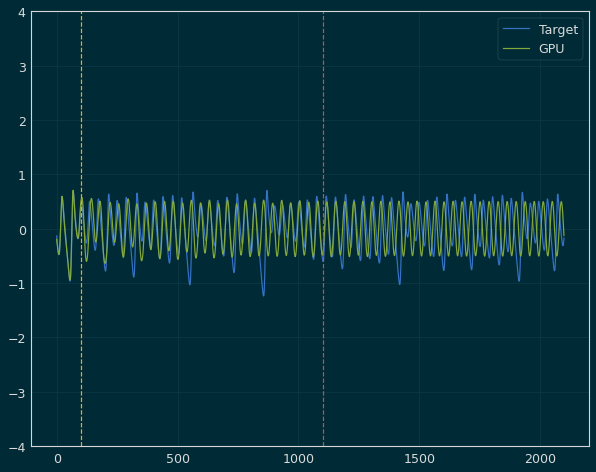

 Iter=46 a=0.035 sr=4.005 amp=0.239  ri=0.625 rr=4.497 loss=0.597581


Iter: 46 #### Diagnostic 0.597581   Time 10.30  Best 0.598 NRMSE 0.158 CD 0.439
Iter: 47 #### Diagnostic 1000.000000   Time 9.41  Best 0.598 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000000   Time 8.88  Best 0.598 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1.171495   Time 7.04  Best 0.598 NRMSE 0.187 CD 0.985
Iter: 50 #### Diagnostic 1.113004   Time 10.99  Best 0.598 NRMSE 0.202 CD 0.911
Iter: 51 #### Diagnostic 1.203820   Time 9.23  Best 0.598 NRMSE 0.193 CD 1.011
Iter: 52 #### Diagnostic 1.211499   Time 9.02  Best 0.598 NRMSE 0.321 CD 0.891
Iter: 53 #### Diagnostic 1000.000000   Time 10.41  Best 0.598 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000000   Time 7.82  Best 0.598 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000000   Time 9.56  Best 0.598 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000000   Time 7.70  Best 0.598 NRMSE 1130483157991635550208.000 CD 1.006
Iter: 57 ####

Iter: 34 #### Diagnostic 1000.000000   Time 7.28  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000000   Time 7.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000000   Time 10.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000000   Time 9.87  Best 1000.000 NRMSE 4243687315465616705110147072.000 CD 1.054
Iter: 38 #### Diagnostic 1000.000000   Time 9.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000000   Time 9.06  Best 1000.000 NRMSE 1000.000 CD 1.005
Iter: 40 #### Diagnostic 1.059254   Time 6.29  Best 1000.000 NRMSE 0.184 CD 0.875
Iter: 41 #### Diagnostic 1.113913   Time 6.37  Best 1000.000 NRMSE 0.185 CD 0.929
Iter: 42 #### Diagnostic 1.103829   Time 7.14  Best 1000.000 NRMSE 0.185 CD 0.919
Iter: 43 #### Diagnostic 1000.000000   Time 7.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000000   Time 8.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000 

Iter: 28 #### Diagnostic 21.533821   Time 7.07  Best 1000.000 NRMSE 20.541 CD 0.993
Iter: 29 #### Diagnostic 1000.000000   Time 8.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 8.62  Best 1000.000 NRMSE 1000.000 CD 0.992
Iter: 31 #### Diagnostic 1.118069   Time 8.45  Best 1000.000 NRMSE 0.185 CD 0.933
Iter: 32 #### Diagnostic 1.173150   Time 5.45  Best 1000.000 NRMSE 0.195 CD 0.978
Iter: 33 #### Diagnostic 1000.000000   Time 8.53  Best 1000.000 NRMSE 12726633673355262.000 CD 0.992
Iter: 34 #### Diagnostic 1.081400   Time 6.68  Best 1000.000 NRMSE 0.184 CD 0.897
Iter: 35 #### Diagnostic 1.063414   Time 7.99  Best 1000.000 NRMSE 0.184 CD 0.880
Iter: 36 #### Diagnostic 1000.000000   Time 8.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000000   Time 8.29  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000000   Time 8.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000000   Time 7.73  Best 

Iter: 22 #### Diagnostic 1000.000000   Time 6.79  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1.206035   Time 6.31  Best 1000.000 NRMSE 0.223 CD 0.983
Iter: 24 #### Diagnostic 1.162747   Time 10.54  Best 1000.000 NRMSE 0.215 CD 0.948
Iter: 25 #### Diagnostic 0.841891   Time 11.08  Best 1000.000 NRMSE 0.198 CD 0.643
Iter: 26 #### Diagnostic 1000.000000   Time 8.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 7.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 8.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.235640   Time 8.51  Best 1000.000 NRMSE 0.235 CD 1.001
Iter: 30 #### Diagnostic 1000.000000   Time 9.63  Best 1000.000 NRMSE 9144776444587354094499711156224.000 CD 0.993
Iter: 31 #### Diagnostic 1000.000000   Time 8.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1.181888   Time 6.85  Best 1000.000 NRMSE 0.212 CD 0.969
Iter: 33 #### Diagnostic 0.998373   Time 8.

Iter: 16 #### Diagnostic 1000.000000   Time 8.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 0.604010   Time 11.06  Best 1000.000 NRMSE 0.167 CD 0.437
Iter: 18 #### Diagnostic 0.997073   Time 8.14  Best 1000.000 NRMSE 0.183 CD 0.814
Iter: 19 #### Diagnostic 1.540455   Time 10.25  Best 1000.000 NRMSE 0.536 CD 1.005
Iter: 20 #### Diagnostic 1.080033   Time 8.37  Best 1000.000 NRMSE 0.184 CD 0.896
Iter: 21 #### Diagnostic 1000.000000   Time 8.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 0.707268   Time 8.85  Best 1000.000 NRMSE 0.183 CD 0.524
Iter: 23 #### Diagnostic 1000.000000   Time 7.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 6.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 7.46  Best 1000.000 NRMSE 176796996392440836342727835648.000 CD 0.992
Iter: 26 #### Diagnostic 0.894084   Time 9.05  Best 1000.000 NRMSE 0.195 CD 0.699
Iter: 27 #### Diagnostic 1000.000000   Time 9.73

Iter: 10 #### Diagnostic 1000.000000   Time 9.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1.243601   Time 8.37  Best 1000.000 NRMSE 0.209 CD 1.035
Iter: 12 #### Diagnostic 1000.000000   Time 10.28  Best 1000.000 NRMSE 1000.000 CD 0.992
Iter: 13 #### Diagnostic 1000.000000   Time 8.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000000   Time 10.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 7.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 10.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 8.27  Best 1000.000 NRMSE 3407849141473775303262208.000 CD 0.952
Iter: 18 #### Diagnostic 1000.000000   Time 6.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 6.71  Best 1000.000 NRMSE 233360648622838.094 CD 0.990
Iter: 20 #### Diagnostic 1000.000000   Time 7.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Dia

Iter: 1 #### Diagnostic 1000.000000   Time 8.57  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 8.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 8.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 0.997571   Time 6.64  Best 1000.000 NRMSE 0.182 CD 0.815
Iter: 5 #### Diagnostic 1.539023   Time 7.92  Best 1000.000 NRMSE 0.536 CD 1.003
Iter: 6 #### Diagnostic 1000.000000   Time 8.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 7.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 0.747641   Time 8.90  Best 1000.000 NRMSE 0.168 CD 0.580
Iter: 9 #### Diagnostic 1000.000000   Time 7.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1.536696   Time 7.35  Best 1000.000 NRMSE 0.536 CD 1.001
Iter: 11 #### Diagnostic 1000.000000   Time 7.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000000   Time 8.58  Best 1000.000 NRMSE 1000.000 

Iter: 98 #### Diagnostic 1.076221   Time 7.10  Best 1000.000 NRMSE 0.184 CD 0.892
Iter: 99 #### Diagnostic 1.167279   Time 8.43  Best 1000.000 NRMSE 0.198 CD 0.970

Best result = 0.6535178465468681
a = 0.03714899719480398
sr = 2.8805199282091567
amp = 0.07049883500355729
ri = 0.7238811678690714
rr = 0.17771174677320598
********** Size 700 -- Run 1 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 9.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000000   Time 8.29  Best 1000.000 NRMSE 1000.000 CD 1.103
Iter: 2 #### Diagnostic 1.094384   Time 11.05  Best 1000.000 NRMSE 0.185 CD 0.910
Iter: 3 #### Diagnostic 1000.000000   Time 7.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1.069164   Time 6.94  Best 1000.000 NRMSE 0.235 CD 0.834
Iter: 5 #### Diagnostic 1000.000000   Time 7.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000000   Time 9.70  Best 1000.000 NRMSE 1000.000 CD 1.000
Iter: 7 #### Diagnostic 1.149807   Time 7.76  

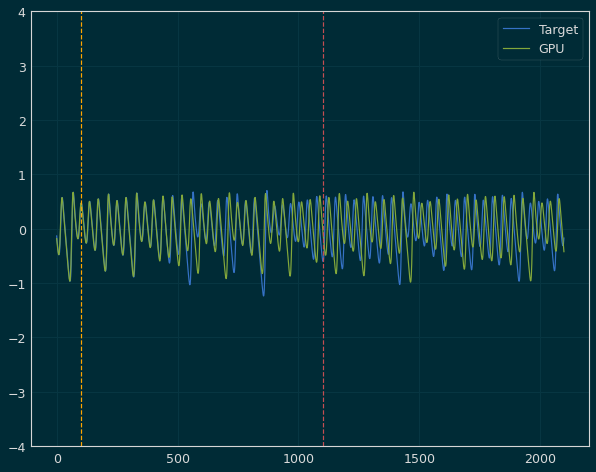

 Iter=54 a=0.460 sr=3.909 amp=0.424  ri=0.677 rr=0.258 loss=0.596987


Iter: 54 #### Diagnostic 0.596987   Time 8.86  Best 0.597 NRMSE 0.166 CD 0.431
Iter: 55 #### Diagnostic 1000.000000   Time 9.55  Best 0.597 NRMSE 1000.000 CD 0.994
Iter: 56 #### Diagnostic 1000.000000   Time 6.52  Best 0.597 NRMSE 35830667461305105907712.000 CD 1.008
Iter: 57 #### Diagnostic 1.064193   Time 6.78  Best 0.597 NRMSE 0.184 CD 0.880
Iter: 58 #### Diagnostic 1000.000000   Time 7.99  Best 0.597 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1.542433   Time 8.84  Best 0.597 NRMSE 0.536 CD 1.007
Iter: 60 #### Diagnostic 1000.000000   Time 8.81  Best 0.597 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 0.629547   Time 9.82  Best 0.597 NRMSE 0.169 CD 0.461
Iter: 62 #### Diagnostic 1.384414   Time 8.55  Best 0.597 NRMSE 0.244 CD 1.140
Iter: 63 #### Diagnostic 1.248993   Time 9.81  Best 0.597 NRMSE 0.228 CD 1.021
Iter: 64 #### Diagnostic 1000.000000   Time 7.68  Best 0.597 NRMSE 1000.000 CD nan
Iter: 65 #### Dia

Iter: 49 #### Diagnostic 1.177387   Time 6.16  Best 1000.000 NRMSE 0.195 CD 0.982
Iter: 50 #### Diagnostic 1000.000000   Time 6.27  Best 1000.000 NRMSE 1000.000 CD 0.998
Iter: 51 #### Diagnostic 1.546863   Time 7.07  Best 1000.000 NRMSE 0.536 CD 1.011
Iter: 52 #### Diagnostic 1000.000000   Time 8.13  Best 1000.000 NRMSE 1000.000 CD 1.002
Iter: 53 #### Diagnostic 1.079940   Time 6.55  Best 1000.000 NRMSE 0.184 CD 0.895
Iter: 54 #### Diagnostic 1.106292   Time 6.66  Best 1000.000 NRMSE 0.185 CD 0.921
Iter: 55 #### Diagnostic 1.057691   Time 6.94  Best 1000.000 NRMSE 0.184 CD 0.874
Iter: 56 #### Diagnostic 1000.000000   Time 6.41  Best 1000.000 NRMSE 1025513.320 CD 1.061
Iter: 57 #### Diagnostic 1000.000000   Time 10.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 9.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1.050786   Time 6.42  Best 1000.000 NRMSE 0.184 CD 0.867
Iter: 60 #### Diagnostic 1000.000000   Time 7.08  Best 1000.000 NRMS

Iter: 43 #### Diagnostic 1000.000000   Time 9.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000000   Time 8.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 7.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000000   Time 8.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000000   Time 8.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1.011533   Time 9.49  Best 1000.000 NRMSE 0.183 CD 0.829
Iter: 49 #### Diagnostic 0.999720   Time 6.96  Best 1000.000 NRMSE 0.183 CD 0.817
Iter: 50 #### Diagnostic 1000.000000   Time 10.77  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000000   Time 7.46  Best 1000.000 NRMSE 1000.000 CD 0.997
Iter: 52 #### Diagnostic 1000.000000   Time 9.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000000   Time 7.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000000   Time 7.16  Best 1000

Iter: 37 #### Diagnostic 1.543536   Time 10.65  Best 1000.000 NRMSE 0.536 CD 1.008
Iter: 38 #### Diagnostic 1000.000000   Time 9.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1.058604   Time 9.70  Best 1000.000 NRMSE 0.184 CD 0.875
Iter: 40 #### Diagnostic 1.544486   Time 6.18  Best 1000.000 NRMSE 0.536 CD 1.009
Iter: 41 #### Diagnostic 1000.000000   Time 8.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000000   Time 8.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1000.000000   Time 9.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1.154530   Time 9.50  Best 1000.000 NRMSE 0.218 CD 0.936
Iter: 45 #### Diagnostic 1000.000000   Time 8.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 0.632885   Time 9.32  Best 1000.000 NRMSE 0.164 CD 0.469
Iter: 47 #### Diagnostic 180.059843   Time 8.56  Best 1000.000 NRMSE 179.049 CD 1.011
Iter: 48 #### Diagnostic 1000.000000   Time 9.08  Best 1000.000 NRMSE 100

Iter: 25 #### Diagnostic 1000.000000   Time 7.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1.548540   Time 7.77  Best 1000.000 NRMSE 0.536 CD 1.013
Iter: 27 #### Diagnostic 1000.000000   Time 7.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 8.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000000   Time 6.95  Best 1000.000 NRMSE 1000.000 CD 0.973
Iter: 30 #### Diagnostic 0.705562   Time 9.52  Best 1000.000 NRMSE 0.156 CD 0.549
Iter: 31 #### Diagnostic 0.630150   Time 8.13  Best 1000.000 NRMSE 0.159 CD 0.471
Iter: 32 #### Diagnostic 1.096466   Time 8.15  Best 1000.000 NRMSE 0.187 CD 0.910
Iter: 33 #### Diagnostic 1000.000000   Time 7.01  Best 1000.000 NRMSE 1000.000 CD 0.994
Iter: 34 #### Diagnostic 1000.000000   Time 7.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1.231774   Time 8.71  Best 1000.000 NRMSE 0.237 CD 0.995
Iter: 36 #### Diagnostic 0.772762   Time 6.31  Best 1000.000 NRMSE 0.1

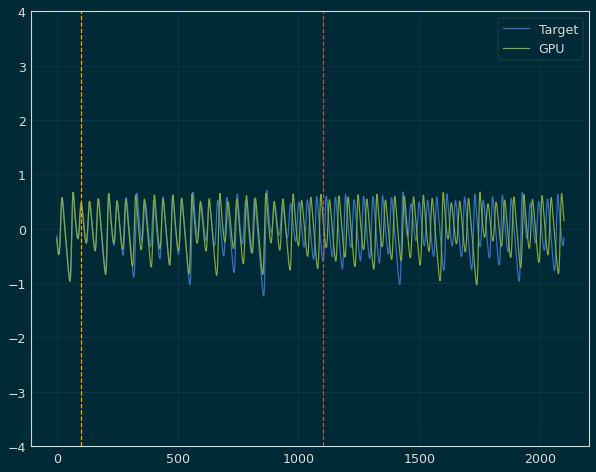

 Iter=60 a=0.415 sr=5.336 amp=0.264  ri=0.572 rr=3.962 loss=0.575814


Iter: 60 #### Diagnostic 0.575814   Time 8.79  Best 0.576 NRMSE 0.167 CD 0.409
Iter: 61 #### Diagnostic 0.766152   Time 7.50  Best 0.576 NRMSE 0.192 CD 0.574
Iter: 62 #### Diagnostic 1000.000000   Time 8.79  Best 0.576 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000000   Time 6.79  Best 0.576 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000000   Time 8.20  Best 0.576 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1.084284   Time 9.87  Best 0.576 NRMSE 0.184 CD 0.900
Iter: 66 #### Diagnostic 1.180967   Time 9.21  Best 0.576 NRMSE 0.209 CD 0.972
Iter: 67 #### Diagnostic 1000.000000   Time 6.92  Best 0.576 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 9.90  Best 0.576 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000000   Time 7.64  Best 0.576 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000000   Time 9.08  Best 0.576 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1.12852

Iter: 55 #### Diagnostic 1000.000000   Time 11.52  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000000   Time 7.63  Best 1000.000 NRMSE 1000.000 CD 0.997
Iter: 57 #### Diagnostic 1.073184   Time 9.47  Best 1000.000 NRMSE 0.184 CD 0.889
Iter: 58 #### Diagnostic 1000.000000   Time 7.80  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1.543757   Time 6.52  Best 1000.000 NRMSE 0.536 CD 1.008
Iter: 60 #### Diagnostic 1000.000000   Time 7.27  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 8.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 7.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1.191391   Time 8.14  Best 1000.000 NRMSE 0.216 CD 0.975
Iter: 64 #### Diagnostic 1000.000000   Time 7.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000000   Time 12.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000000   Time 11.58  Best 1000.0

Iter: 49 #### Diagnostic 1.195902   Time 11.52  Best 1000.000 NRMSE 0.196 CD 1.000
Iter: 50 #### Diagnostic 1000.000000   Time 7.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1.542386   Time 9.27  Best 1000.000 NRMSE 0.536 CD 1.007
Iter: 52 #### Diagnostic 1.535801   Time 8.60  Best 1000.000 NRMSE 0.536 CD 1.000
Iter: 53 #### Diagnostic 1.070355   Time 6.45  Best 1000.000 NRMSE 0.184 CD 0.886
Iter: 54 #### Diagnostic 1.109480   Time 9.21  Best 1000.000 NRMSE 0.185 CD 0.924
Iter: 55 #### Diagnostic 1.066374   Time 10.16  Best 1000.000 NRMSE 0.184 CD 0.883
Iter: 56 #### Diagnostic 1000.000000   Time 7.28  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000000   Time 7.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 9.24  Best 1000.000 NRMSE 2537334251648673.000 CD 1.002
Iter: 59 #### Diagnostic 1.050793   Time 8.04  Best 1000.000 NRMSE 0.184 CD 0.867
Iter: 60 #### Diagnostic 1000.000000   Time 10.05  Best 1000.000 N

Iter: 44 #### Diagnostic 1000.000000   Time 10.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 9.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000000   Time 9.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000000   Time 10.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1.014968   Time 7.46  Best 1000.000 NRMSE 0.183 CD 0.832
Iter: 49 #### Diagnostic 0.977890   Time 9.58  Best 1000.000 NRMSE 0.182 CD 0.796
Iter: 50 #### Diagnostic 1000.000000   Time 9.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000000   Time 10.54  Best 1000.000 NRMSE 1000.000 CD 1.000
Iter: 52 #### Diagnostic 1000.000000   Time 10.52  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000000   Time 8.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000000   Time 9.88  Best 1000.000 NRMSE 1000.000 CD 1.000
Iter: 55 #### Diagnostic 1.528301   Time 8.99  Best 10

Iter: 39 #### Diagnostic 1.096675   Time 9.86  Best 1000.000 NRMSE 0.185 CD 0.912
Iter: 40 #### Diagnostic 1000.000000   Time 7.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000000   Time 7.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000000   Time 6.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1000.000000   Time 7.80  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000000   Time 7.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 8.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 0.608965   Time 9.89  Best 1000.000 NRMSE 0.159 CD 0.450
Iter: 47 #### Diagnostic 117.263387   Time 8.72  Best 1000.000 NRMSE 116.252 CD 1.012
Iter: 48 #### Diagnostic 1000.000000   Time 6.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1.163384   Time 9.11  Best 1000.000 NRMSE 0.186 CD 0.977
Iter: 50 #### Diagnostic 1.175726   Time 7.60  Best 1000.000 NRMSE

Iter: 27 #### Diagnostic 1000.000000   Time 6.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 8.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.564031   Time 8.00  Best 1000.000 NRMSE 0.536 CD 1.028


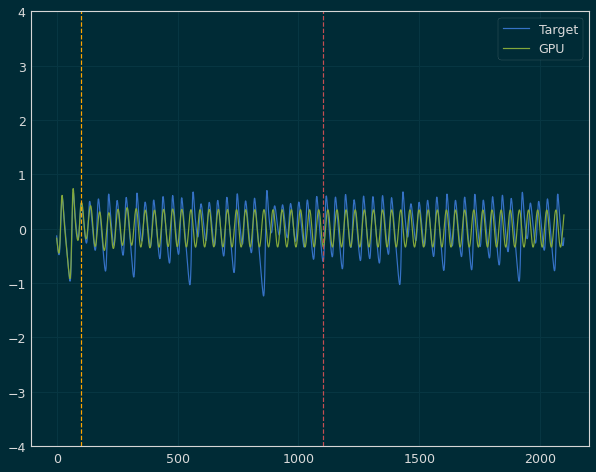

 Iter=30 a=0.037 sr=2.881 amp=0.070  ri=0.724 rr=0.178 loss=0.580085


Iter: 30 #### Diagnostic 0.580085   Time 7.85  Best 0.580 NRMSE 0.143 CD 0.437
Iter: 31 #### Diagnostic 1000.000000   Time 7.48  Best 0.580 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1.097681   Time 6.46  Best 0.580 NRMSE 0.187 CD 0.911
Iter: 33 #### Diagnostic 1000.000000   Time 7.12  Best 0.580 NRMSE 1000.000 CD 0.992
Iter: 34 #### Diagnostic 1000.000000   Time 6.76  Best 0.580 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1.151628   Time 5.98  Best 0.580 NRMSE 0.228 CD 0.923
Iter: 36 #### Diagnostic 0.730075   Time 8.59  Best 0.580 NRMSE 0.181 CD 0.549
Iter: 37 #### Diagnostic 1.566429   Time 10.75  Best 0.580 NRMSE 0.536 CD 1.031
Iter: 38 #### Diagnostic 1000.000000   Time 7.94  Best 0.580 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1.537353   Time 7.79  Best 0.580 NRMSE 0.536 CD 1.002
Iter: 40 #### Diagnostic 1.076085   Time 7.61  Best 0.580 NRMSE 0.184 CD 0.892
Iter: 41 #### Diagnostic 1.121210   Time 

Iter: 26 #### Diagnostic 1.538504   Time 7.76  Best 1000.000 NRMSE 0.536 CD 1.003
Iter: 27 #### Diagnostic 1000.000000   Time 8.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1.262341   Time 8.09  Best 1000.000 NRMSE 0.232 CD 1.030
Iter: 29 #### Diagnostic 1000.000000   Time 7.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 6.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1.117691   Time 6.93  Best 1000.000 NRMSE 0.185 CD 0.932
Iter: 32 #### Diagnostic 1.194396   Time 7.14  Best 1000.000 NRMSE 0.196 CD 0.999
Iter: 33 #### Diagnostic 1.541141   Time 6.78  Best 1000.000 NRMSE 0.536 CD 1.005
Iter: 34 #### Diagnostic 1.085986   Time 7.26  Best 1000.000 NRMSE 0.184 CD 0.902
Iter: 35 #### Diagnostic 1.040278   Time 6.02  Best 1000.000 NRMSE 0.183 CD 0.857
Iter: 36 #### Diagnostic 1000.000000   Time 5.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1.537276   Time 6.93  Best 1000.000 NRMSE 0.536 CD 1.001


Iter: 20 #### Diagnostic 1.270203   Time 8.51  Best 1000.000 NRMSE 0.282 CD 0.988
Iter: 21 #### Diagnostic 1.017984   Time 7.21  Best 1000.000 NRMSE 0.183 CD 0.835
Iter: 22 #### Diagnostic 1000.000000   Time 7.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1.201637   Time 7.87  Best 1000.000 NRMSE 0.222 CD 0.980
Iter: 24 #### Diagnostic 1.354143   Time 8.82  Best 1000.000 NRMSE 0.360 CD 0.994
Iter: 25 #### Diagnostic 1000.000000   Time 9.27  Best 1000.000 NRMSE 16537920568778258550838263808.000 CD 1.001
Iter: 26 #### Diagnostic 1000.000000   Time 6.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 7.57  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 7.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.117647   Time 6.00  Best 1000.000 NRMSE 0.185 CD 0.933
Iter: 30 #### Diagnostic 1000.000000   Time 7.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000000   Time 8.6

Iter: 15 #### Diagnostic 1000.000000   Time 6.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 6.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1.499845   Time 7.58  Best 1000.000 NRMSE 0.475 CD 1.025
Iter: 18 #### Diagnostic 0.970899   Time 8.74  Best 1000.000 NRMSE 0.182 CD 0.789
Iter: 19 #### Diagnostic 1.543408   Time 9.66  Best 1000.000 NRMSE 0.536 CD 1.008
Iter: 20 #### Diagnostic 1.067605   Time 8.32  Best 1000.000 NRMSE 0.184 CD 0.884
Iter: 21 #### Diagnostic 1000.000000   Time 6.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 7.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 6.64  Best 1000.000 NRMSE 1000.000 CD 1.002
Iter: 24 #### Diagnostic 1000.000000   Time 6.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 5.95  Best 1000.000 NRMSE 1000.000 CD 1.002
Iter: 26 #### Diagnostic 1000.000000   Time 7.86  Best 1000.000 NR

Iter: 9 #### Diagnostic 1000.000000   Time 10.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 9.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1.190055   Time 7.34  Best 1000.000 NRMSE 0.209 CD 0.981
Iter: 12 #### Diagnostic 1000.000000   Time 8.43  Best 1000.000 NRMSE 1000.000 CD 1.008
Iter: 13 #### Diagnostic 1000.000000   Time 6.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000000   Time 7.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 7.77  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 10.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 7.56  Best 1000.000 NRMSE 1206679566952210688.000 CD 1.001
Iter: 18 #### Diagnostic 1000.000000   Time 7.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 6.27  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000000  

Iter: 0 #### Diagnostic 1000.000000   Time 6.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000000   Time 9.78  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 9.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 10.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1.001249   Time 8.62  Best 1000.000 NRMSE 0.182 CD 0.819
Iter: 5 #### Diagnostic 1.513825   Time 8.10  Best 1000.000 NRMSE 0.508 CD 1.006
Iter: 6 #### Diagnostic 1000.000000   Time 9.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 7.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 0.742092   Time 8.93  Best 1000.000 NRMSE 0.168 CD 0.575
Iter: 9 #### Diagnostic 1000.000000   Time 7.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1.380037   Time 8.44  Best 1000.000 NRMSE 0.379 CD 1.001
Iter: 11 #### Diagnostic 1000.000000   Time 9.26  Best 1000.000 NRMSE 1000.000 

Iter: 96 #### Diagnostic 1000.000000   Time 7.79  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 0.845675   Time 7.00  Best 1000.000 NRMSE 0.231 CD 0.615
Iter: 98 #### Diagnostic 1.077269   Time 6.19  Best 1000.000 NRMSE 0.184 CD 0.893
Iter: 99 #### Diagnostic 1.180421   Time 8.38  Best 1000.000 NRMSE 0.206 CD 0.974

Best result = 0.6663851265627063
a = 0.03714899719480398
sr = 2.8805199282091567
amp = 0.07049883500355729
ri = 0.7238811678690714
rr = 0.17771174677320598
********** Size 600 -- Run 1 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 8.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000000   Time 7.62  Best 1000.000 NRMSE 1000.000 CD 1.074
Iter: 2 #### Diagnostic 1.092188   Time 8.51  Best 1000.000 NRMSE 0.185 CD 0.908
Iter: 3 #### Diagnostic 1000.000000   Time 8.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1.160165   Time 7.85  Best 1000.000 NRMSE 0.237 CD 0.923
Iter: 5 #### Diagnostic 1000.000000   Time 11.02  B

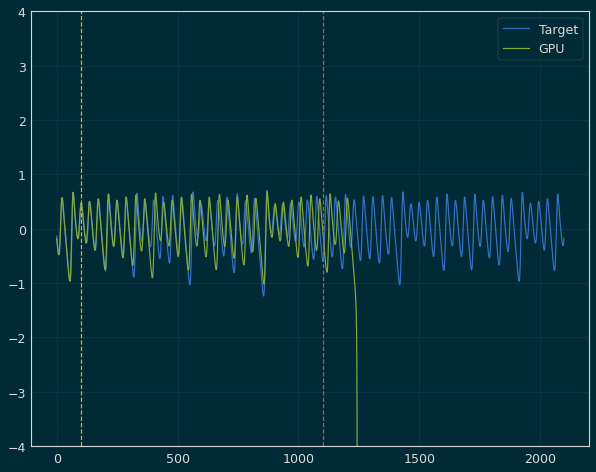

 Iter=51 a=0.634 sr=4.842 amp=0.318  ri=0.551 rr=3.175 loss=0.549164


Iter: 51 #### Diagnostic 0.549164   Time 11.35  Best 0.549 NRMSE 0.164 CD 0.385
Iter: 52 #### Diagnostic 1.019188   Time 10.25  Best 0.549 NRMSE 0.182 CD 0.837
Iter: 53 #### Diagnostic 1.549928   Time 8.31  Best 0.549 NRMSE 0.536 CD 1.014
Iter: 54 #### Diagnostic 0.835159   Time 7.40  Best 0.549 NRMSE 0.200 CD 0.635
Iter: 55 #### Diagnostic 1000.000000   Time 7.02  Best 0.549 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 0.688711   Time 6.63  Best 0.549 NRMSE 0.182 CD 0.506
Iter: 57 #### Diagnostic 1.069097   Time 7.03  Best 0.549 NRMSE 0.184 CD 0.885
Iter: 58 #### Diagnostic 1000.000000   Time 11.16  Best 0.549 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1.538782   Time 6.39  Best 0.549 NRMSE 0.536 CD 1.003
Iter: 60 #### Diagnostic 1000.000000   Time 7.90  Best 0.549 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 10.34  Best 0.549 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 0.630720   Time

Iter: 47 #### Diagnostic 1.100587   Time 9.16  Best 1000.000 NRMSE 0.185 CD 0.916
Iter: 48 #### Diagnostic 0.883724   Time 7.53  Best 1000.000 NRMSE 0.183 CD 0.701
Iter: 49 #### Diagnostic 1.160474   Time 6.38  Best 1000.000 NRMSE 0.194 CD 0.967
Iter: 50 #### Diagnostic 1000.000000   Time 6.51  Best 1000.000 NRMSE 1000.000 CD 0.890
Iter: 51 #### Diagnostic 1000.000000   Time 9.33  Best 1000.000 NRMSE 1000.000 CD 0.999
Iter: 52 #### Diagnostic 1000.000000   Time 6.52  Best 1000.000 NRMSE 1000.000 CD 1.011
Iter: 53 #### Diagnostic 1.079384   Time 5.11  Best 1000.000 NRMSE 0.184 CD 0.895
Iter: 54 #### Diagnostic 1.110046   Time 7.47  Best 1000.000 NRMSE 0.185 CD 0.925
Iter: 55 #### Diagnostic 1.058995   Time 7.46  Best 1000.000 NRMSE 0.184 CD 0.875
Iter: 56 #### Diagnostic 1.515351   Time 7.71  Best 1000.000 NRMSE 0.524 CD 0.991
Iter: 57 #### Diagnostic 1000.000000   Time 6.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 7.18  Best 1000.000 NRMSE 1000.0

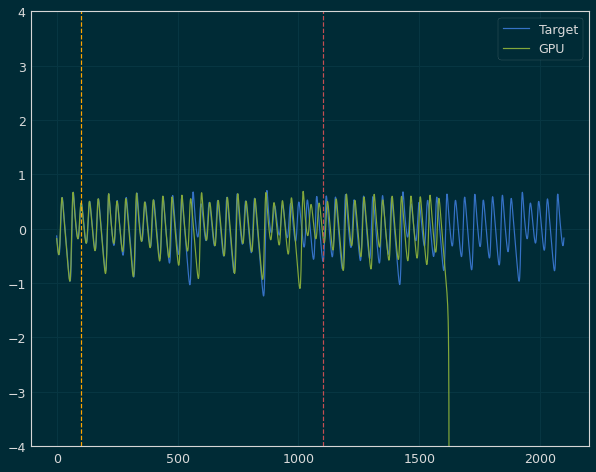

 Iter=98 a=0.942 sr=2.260 amp=0.845  ri=0.493 rr=1.346 loss=0.483442


Iter: 98 #### Diagnostic 0.483442   Time 10.52  Best 0.483 NRMSE 0.145 CD 0.339
Iter: 99 #### Diagnostic 1000.000000   Time 6.93  Best 0.483 NRMSE 1000.000 CD 0.993

Best result = 0.4834423445887176
a = 0.9419040546852837
sr = 2.260013080674692
amp = 0.8449686557423696
ri = 0.4930049382843008
rr = 1.3456149318661197
********** Size 600 -- Run 3 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 8.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000000   Time 7.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1.532505   Time 7.60  Best 1000.000 NRMSE 0.536 CD 0.997
Iter: 3 #### Diagnostic 1.538016   Time 8.88  Best 1000.000 NRMSE 0.536 CD 1.002
Iter: 4 #### Diagnostic 1000.000000   Time 6.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 8.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000000   Time 8.67  Best 1000.000 NRMSE

Iter: 92 #### Diagnostic 0.854988   Time 6.84  Best 1000.000 NRMSE 0.178 CD 0.677
Iter: 93 #### Diagnostic 1.525836   Time 5.87  Best 1000.000 NRMSE 0.527 CD 0.999
Iter: 94 #### Diagnostic 1.542628   Time 6.24  Best 1000.000 NRMSE 0.536 CD 1.007
Iter: 95 #### Diagnostic 1000.000000   Time 9.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000000   Time 7.43  Best 1000.000 NRMSE 2740225801970557952.000 CD 0.992
Iter: 97 #### Diagnostic 1.535594   Time 8.86  Best 1000.000 NRMSE 0.536 CD 1.000
Iter: 98 #### Diagnostic 1000.000000   Time 8.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1.224057   Time 7.42  Best 1000.000 NRMSE 0.227 CD 0.997

Best result = 0.6741673653267388
a = 0.5795082648070864
sr = 2.097080403471926
amp = 0.6902599015021201
ri = 0.6490461832792918
rr = 4.377195045650328
********** Size 600 -- Run 4 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 7.30  Best 1000.000 NRMSE 413245996943.278 CD 0.992
Iter: 1 #### Diagnostic 100

Iter: 86 #### Diagnostic 1000.000000   Time 7.27  Best 1000.000 NRMSE 1000.000 CD 1.000
Iter: 87 #### Diagnostic 1.540353   Time 7.95  Best 1000.000 NRMSE 0.536 CD 1.005
Iter: 88 #### Diagnostic 1000.000000   Time 6.20  Best 1000.000 NRMSE 4259186471685898229995372196527079424.000 CD 1.000
Iter: 89 #### Diagnostic 1000.000000   Time 7.45  Best 1000.000 NRMSE 1000.000 CD 0.987
Iter: 90 #### Diagnostic 1.512177   Time 8.50  Best 1000.000 NRMSE 0.508 CD 1.004
Iter: 91 #### Diagnostic 1000.000000   Time 7.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1.222257   Time 8.74  Best 1000.000 NRMSE 0.209 CD 1.013
Iter: 93 #### Diagnostic 1.223159   Time 7.14  Best 1000.000 NRMSE 0.209 CD 1.014
Iter: 94 #### Diagnostic 1.216774   Time 9.09  Best 1000.000 NRMSE 0.226 CD 0.991
Iter: 95 #### Diagnostic 1.068197   Time 9.43  Best 1000.000 NRMSE 0.184 CD 0.884
Iter: 96 #### Diagnostic 1000.000000   Time 8.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000000   

Iter: 74 #### Diagnostic 1000.000000   Time 7.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 0.948056   Time 7.10  Best 1000.000 NRMSE 0.181 CD 0.767
Iter: 76 #### Diagnostic 1000.000000   Time 7.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1.110471   Time 6.11  Best 1000.000 NRMSE 0.185 CD 0.925
Iter: 78 #### Diagnostic 1.194929   Time 6.62  Best 1000.000 NRMSE 0.195 CD 1.000
Iter: 79 #### Diagnostic 1000.000000   Time 6.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000000   Time 6.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 0.786546   Time 5.66  Best 1000.000 NRMSE 0.193 CD 0.594
Iter: 82 #### Diagnostic 1000.000000   Time 7.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1.209798   Time 7.49  Best 1000.000 NRMSE 0.206 CD 1.004
Iter: 84 #### Diagnostic 1000.000000   Time 7.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.000000   Time 7.21  Best 1000.000 NRMSE 1000

Iter: 69 #### Diagnostic 1000.000000   Time 7.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000000   Time 7.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000000   Time 6.39  Best 1000.000 NRMSE 1000.000 CD 1.046
Iter: 72 #### Diagnostic 1.516195   Time 5.68  Best 1000.000 NRMSE 0.519 CD 0.998
Iter: 73 #### Diagnostic 1000.000000   Time 10.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000000   Time 5.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000000   Time 6.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000000   Time 7.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1000.000000   Time 8.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1000.000000   Time 6.79  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1000.000000   Time 7.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000000   Time 7.54  Best 

Iter: 63 #### Diagnostic 1.063710   Time 8.28  Best 1000.000 NRMSE 0.184 CD 0.880
Iter: 64 #### Diagnostic 1000.000000   Time 10.48  Best 1000.000 NRMSE 1000.000 CD 0.995
Iter: 65 #### Diagnostic 1000.000000   Time 7.19  Best 1000.000 NRMSE 1000.000 CD 1.027
Iter: 66 #### Diagnostic 1.314102   Time 6.38  Best 1000.000 NRMSE 0.273 CD 1.042
Iter: 67 #### Diagnostic 1.056655   Time 7.20  Best 1000.000 NRMSE 0.183 CD 0.873
Iter: 68 #### Diagnostic 0.787473   Time 7.85  Best 1000.000 NRMSE 0.193 CD 0.595
Iter: 69 #### Diagnostic 1.131127   Time 5.68  Best 1000.000 NRMSE 0.187 CD 0.944
Iter: 70 #### Diagnostic 1.065937   Time 6.49  Best 1000.000 NRMSE 0.184 CD 0.882
Iter: 71 #### Diagnostic 1.539072   Time 8.60  Best 1000.000 NRMSE 0.536 CD 1.003
Iter: 72 #### Diagnostic 1.121669   Time 8.45  Best 1000.000 NRMSE 0.185 CD 0.936
Iter: 73 #### Diagnostic 1000.000000   Time 9.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000000   Time 8.13  Best 1000.000 NRMSE 1000.000 CD

Iter: 58 #### Diagnostic 1000.000000   Time 6.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000000   Time 7.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000000   Time 7.87  Best 1000.000 NRMSE 1000.000 CD 1.000
Iter: 61 #### Diagnostic 1000.000000   Time 7.64  Best 1000.000 NRMSE 1000.000 CD 1.000
Iter: 62 #### Diagnostic 1.010169   Time 5.98  Best 1000.000 NRMSE 0.183 CD 0.827
Iter: 63 #### Diagnostic 1000.000000   Time 7.79  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1.143215   Time 6.89  Best 1000.000 NRMSE 0.193 CD 0.950
Iter: 65 #### Diagnostic 1.091602   Time 7.10  Best 1000.000 NRMSE 0.184 CD 0.907
Iter: 66 #### Diagnostic 1000.000000   Time 7.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 5.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 6.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1.399797   Time 9.13  Best 1000.000 N

Iter: 52 #### Diagnostic 1.210418   Time 8.95  Best 1000.000 NRMSE 0.323 CD 0.888
Iter: 53 #### Diagnostic 1000.000000   Time 7.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000000   Time 6.41  Best 1000.000 NRMSE 1000.000 CD 0.989
Iter: 55 #### Diagnostic 1000.000000   Time 6.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000000   Time 7.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1.541862   Time 7.57  Best 1000.000 NRMSE 0.536 CD 1.006
Iter: 58 #### Diagnostic 1.097998   Time 6.24  Best 1000.000 NRMSE 0.185 CD 0.913
Iter: 59 #### Diagnostic 1000.000000   Time 8.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000000   Time 6.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 7.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 9.48  Best 1000.000 NRMSE 1000.000 CD 1.011
Iter: 63 #### Diagnostic 1000.000000   Time 9.86  Best 1000.00

Iter: 43 #### Diagnostic 1000.000000   Time 8.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000000   Time 7.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 7.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000000   Time 6.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000000   Time 7.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1.452080   Time 7.53  Best 1000.000 NRMSE 0.406 CD 1.046
Iter: 49 #### Diagnostic 1000.000000   Time 8.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000000   Time 6.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000000   Time 7.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000000   Time 6.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000000   Time 7.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1.161198   Time 7.62  Best 1000.0

Iter: 38 #### Diagnostic 1000.000000   Time 6.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000000   Time 7.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000000   Time 9.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000000   Time 7.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000000   Time 5.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 0.761433   Time 8.05  Best 1000.000 NRMSE 0.196 CD 0.565
Iter: 44 #### Diagnostic 1.109516   Time 5.94  Best 1000.000 NRMSE 0.185 CD 0.924
Iter: 45 #### Diagnostic 1.269100   Time 6.63  Best 1000.000 NRMSE 0.235 CD 1.034
Iter: 46 #### Diagnostic 0.984941   Time 6.84  Best 1000.000 NRMSE 0.182 CD 0.803
Iter: 47 #### Diagnostic 1000.000000   Time 7.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 0.991183   Time 7.22  Best 1000.000 NRMSE 0.182 CD 0.809
Iter: 49 #### Diagnostic 1.081603   Time 8.43  Best 1000.000 NRMSE 0.194 C

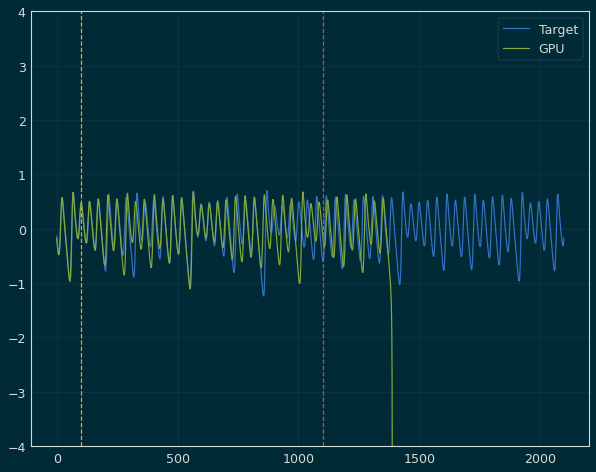

 Iter=26 a=0.860 sr=1.748 amp=0.825  ri=0.998 rr=4.956 loss=0.592821


Iter: 26 #### Diagnostic 0.592821   Time 8.40  Best 0.593 NRMSE 0.165 CD 0.428
Iter: 27 #### Diagnostic 1000.000000   Time 7.57  Best 0.593 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 6.15  Best 0.593 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.088593   Time 8.94  Best 0.593 NRMSE 0.189 CD 0.899
Iter: 30 #### Diagnostic 0.618416   Time 6.33  Best 0.593 NRMSE 0.167 CD 0.452
Iter: 31 #### Diagnostic 1000.000000   Time 7.62  Best 0.593 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1.184867   Time 6.98  Best 0.593 NRMSE 0.209 CD 0.976
Iter: 33 #### Diagnostic 1.054394   Time 6.16  Best 0.593 NRMSE 0.184 CD 0.871
Iter: 34 #### Diagnostic 0.988791   Time 6.58  Best 0.593 NRMSE 0.241 CD 0.748
Iter: 35 #### Diagnostic 1000.000000   Time 8.18  Best 0.593 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1000.000000   Time 6.18  Best 0.593 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1.105251   Time

Iter: 21 #### Diagnostic 1000.000000   Time 9.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 8.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 7.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 5.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1.538731   Time 7.69  Best 1000.000 NRMSE 0.536 CD 1.003
Iter: 26 #### Diagnostic 1000.000000   Time 6.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 6.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1.548130   Time 7.04  Best 1000.000 NRMSE 0.536 CD 1.012
Iter: 29 #### Diagnostic 0.865948   Time 8.34  Best 1000.000 NRMSE 0.178 CD 0.688
Iter: 30 #### Diagnostic 1000.000000   Time 9.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000000   Time 8.18  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000000   Time 7.31  Best 1000.000 NR

Iter: 16 #### Diagnostic 1000.000000   Time 7.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 7.12  Best 1000.000 NRMSE 7461239904196178.000 CD 1.004
Iter: 18 #### Diagnostic 1000.000000   Time 9.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 10.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000000   Time 6.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 0.655819   Time 6.63  Best 1000.000 NRMSE 0.177 CD 0.479
Iter: 22 #### Diagnostic 1.145450   Time 6.85  Best 1000.000 NRMSE 0.228 CD 0.918
Iter: 23 #### Diagnostic 1000.000000   Time 7.27  Best 1000.000 NRMSE 2185373.635 CD 0.999
Iter: 24 #### Diagnostic 1000.000000   Time 7.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 8.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 9.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Tim

Iter: 3 #### Diagnostic 1000.000000   Time 6.14  Best 1000.000 NRMSE 1000.000 CD 0.993
Iter: 4 #### Diagnostic 0.990763   Time 8.03  Best 1000.000 NRMSE 0.182 CD 0.809
Iter: 5 #### Diagnostic 1.537534   Time 7.43  Best 1000.000 NRMSE 0.536 CD 1.002
Iter: 6 #### Diagnostic 1000.000000   Time 8.28  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 7.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 0.733468   Time 7.35  Best 1000.000 NRMSE 0.167 CD 0.567
Iter: 9 #### Diagnostic 1000.000000   Time 5.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1.536361   Time 6.21  Best 1000.000 NRMSE 0.536 CD 1.001
Iter: 11 #### Diagnostic 1000.000000   Time 8.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000000   Time 5.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1.120274   Time 6.62  Best 1000.000 NRMSE 0.195 CD 0.925
Iter: 14 #### Diagnostic 1000.000000   Time 8.91  Best 1000.000 NRMSE 1000.000 


Best result = 0.6338724599953018
a = 0.38878474230831206
sr = 1.9365249460791096
amp = 0.7391254678325002
ri = 0.3777917366795458
rr = 1.1242607356111456
********** Size 500 -- Run 1 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 6.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000000   Time 6.50  Best 1000.000 NRMSE 1000.000 CD 1.004
Iter: 2 #### Diagnostic 1.092985   Time 5.65  Best 1000.000 NRMSE 0.185 CD 0.908
Iter: 3 #### Diagnostic 1000.000000   Time 5.76  Best 1000.000 NRMSE 1000.000 CD nan


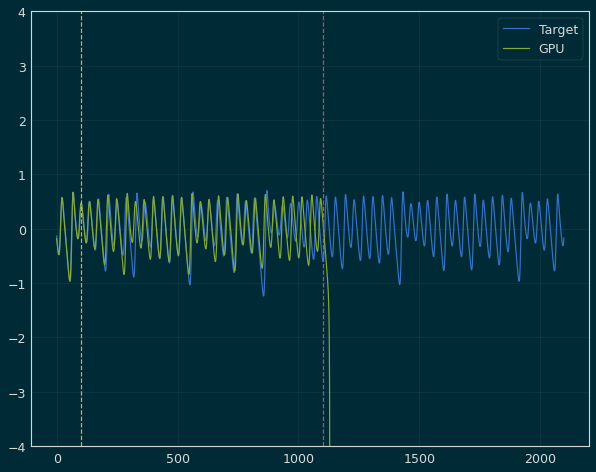

 Iter=4 a=0.240 sr=6.874 amp=0.203  ri=0.727 rr=1.822 loss=0.587044


Iter: 4 #### Diagnostic 0.587044   Time 6.55  Best 0.587 NRMSE 0.169 CD 0.418
Iter: 5 #### Diagnostic 1000.000000   Time 6.25  Best 0.587 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000000   Time 7.01  Best 0.587 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1.166977   Time 5.15  Best 0.587 NRMSE 0.198 CD 0.969
Iter: 8 #### Diagnostic 1000.000000   Time 7.89  Best 0.587 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000000   Time 6.88  Best 0.587 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 0.868927   Time 6.36  Best 0.587 NRMSE 0.203 CD 0.666
Iter: 11 #### Diagnostic 1000.000000   Time 5.71  Best 0.587 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 0.864548   Time 7.55  Best 0.587 NRMSE 0.178 CD 0.686
Iter: 13 #### Diagnostic 1000.000000   Time 6.79  Best 0.587 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1.059449   Time 7.85  Best 0.587 NRMSE 0.184 CD 0.876
Iter: 15 #### Diagnostic 1000.000000   Time

Iter: 1 #### Diagnostic 1.272504   Time 6.14  Best 1000.000 NRMSE 0.196 CD 1.077
Iter: 2 #### Diagnostic 1000.000000   Time 8.78  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 9.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 7.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 0.744762   Time 6.08  Best 1000.000 NRMSE 0.183 CD 0.562
Iter: 6 #### Diagnostic 1000.000000   Time 6.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 6.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 6.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000000   Time 9.78  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 8.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1.541656   Time 7.71  Best 1000.000 NRMSE 0.536 CD 1.006
Iter: 12 #### Diagnostic 1000.000000   Time 6.43  Best 1000.000 NRMSE 1000.

Iter: 99 #### Diagnostic 1000.000000   Time 5.96  Best 1000.000 NRMSE 1000.000 CD 1.000

Best result = 0.6266112667382892
a = 0.4564743938461775
sr = 3.175800413434468
amp = 0.32451025744591405
ri = 0.47548188660427276
rr = 4.335174181102914
********** Size 500 -- Run 3 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 8.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000000   Time 7.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 6.59  Best 1000.000 NRMSE 1000.000 CD 1.003
Iter: 3 #### Diagnostic 1000.000000   Time 8.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 8.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 6.61  Best 1000.000 NRMSE 1000.000 CD 0.991
Iter: 6 #### Diagnostic 1000.000000   Time 7.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 6.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.0000

Iter: 94 #### Diagnostic 1000.000000   Time 7.18  Best 1000.000 NRMSE 33539294.726 CD 1.002
Iter: 95 #### Diagnostic 1000.000000   Time 7.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000000   Time 7.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1.550291   Time 7.87  Best 1000.000 NRMSE 0.536 CD 1.014
Iter: 98 #### Diagnostic 1000.000000   Time 6.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1000.000000   Time 6.91  Best 1000.000 NRMSE 1000.000 CD nan

Best result = 0.6463043021479271
a = 0.6132659723049235
sr = 6.585078423370891
amp = 0.16472060427825666
ri = 0.6372483628426137
rr = 4.247679513487259
********** Size 500 -- Run 4 ***********
Iter: 0 #### Diagnostic 267.604886   Time 9.59  Best 1000.000 NRMSE 266.595 CD 1.010
Iter: 1 #### Diagnostic 1000.000000   Time 6.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 7.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 0.815812 

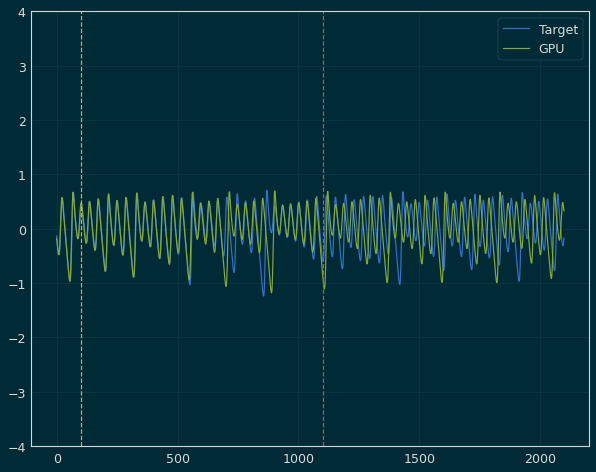

 Iter=22 a=0.795 sr=4.888 amp=0.469  ri=0.888 rr=0.607 loss=0.472575


Iter: 22 #### Diagnostic 0.472575   Time 8.06  Best 0.473 NRMSE 0.132 CD 0.340
Iter: 23 #### Diagnostic 1.513696   Time 6.29  Best 0.473 NRMSE 0.525 CD 0.988
Iter: 24 #### Diagnostic 0.816573   Time 5.95  Best 0.473 NRMSE 0.205 CD 0.611
Iter: 25 #### Diagnostic 1000.000000   Time 8.32  Best 0.473 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 7.65  Best 0.473 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1.500009   Time 6.66  Best 0.473 NRMSE 0.498 CD 1.002
Iter: 28 #### Diagnostic 1000.000000   Time 6.08  Best 0.473 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000000   Time 6.20  Best 0.473 NRMSE 1000.000 CD 0.994
Iter: 30 #### Diagnostic 1000.000000   Time 6.67  Best 0.473 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000000   Time 5.54  Best 0.473 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1000.000000   Time 5.68  Best 0.473 NRMSE 1000.000 CD nan
Iter: 33 #### Diagnostic 0.991

Iter: 12 #### Diagnostic 1000.000000   Time 6.80  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1.157064   Time 7.58  Best 1000.000 NRMSE 0.197 CD 0.960
Iter: 14 #### Diagnostic 1000.000000   Time 6.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1.051923   Time 7.45  Best 1000.000 NRMSE 0.185 CD 0.866
Iter: 16 #### Diagnostic 1.164244   Time 6.88  Best 1000.000 NRMSE 0.258 CD 0.907
Iter: 17 #### Diagnostic 1000.000000   Time 5.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000000   Time 6.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1.063058   Time 6.05  Best 1000.000 NRMSE 0.184 CD 0.879
Iter: 20 #### Diagnostic 1000.000000   Time 8.13  Best 1000.000 NRMSE 1000.000 CD 1.006
Iter: 21 #### Diagnostic 1.016947   Time 6.29  Best 1000.000 NRMSE 0.194 CD 0.823
Iter: 22 #### Diagnostic 1000.000000   Time 6.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 6.45  Best 1000.000 NRMSE 10

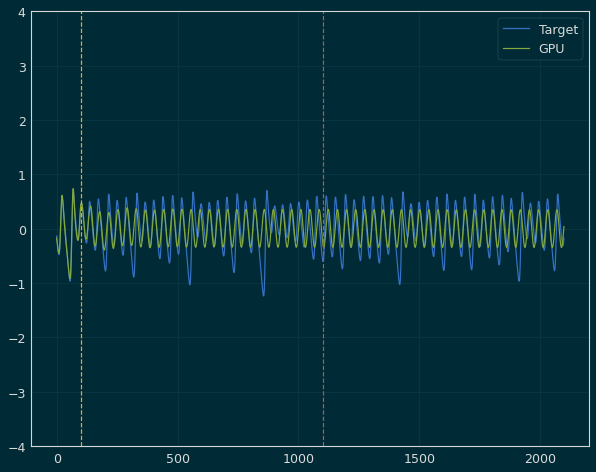

 Iter=30 a=0.037 sr=2.881 amp=0.070  ri=0.724 rr=0.178 loss=0.574324


Iter: 30 #### Diagnostic 0.574324   Time 6.43  Best 0.574 NRMSE 0.143 CD 0.432
Iter: 31 #### Diagnostic 1000.000000   Time 7.30  Best 0.574 NRMSE 1000.000 CD 0.993
Iter: 32 #### Diagnostic 1.095172   Time 6.76  Best 0.574 NRMSE 0.187 CD 0.908
Iter: 33 #### Diagnostic 1000.000000   Time 6.99  Best 0.574 NRMSE 1000.000 CD 0.999
Iter: 34 #### Diagnostic 1000.000000   Time 7.83  Best 0.574 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 0.898453   Time 5.09  Best 0.574 NRMSE 0.194 CD 0.704
Iter: 36 #### Diagnostic 1000.000000   Time 7.65  Best 0.574 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1.353667   Time 6.33  Best 0.574 NRMSE 0.288 CD 1.065
Iter: 38 #### Diagnostic 1000.000000   Time 6.91  Best 0.574 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1.537747   Time 6.68  Best 0.574 NRMSE 0.536 CD 1.002
Iter: 40 #### Diagnostic 1.072493   Time 9.51  Best 0.574 NRMSE 0.184 CD 0.888
Iter: 41 #### Diagnostic 1.109455   

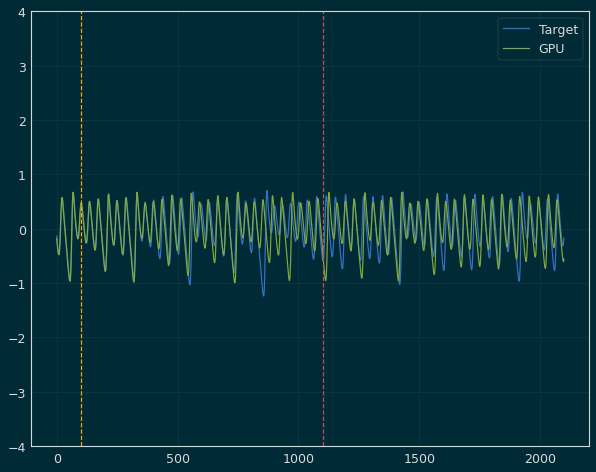

 Iter=25 a=0.712 sr=3.122 amp=0.537  ri=0.439 rr=0.095 loss=0.548586


Iter: 25 #### Diagnostic 0.548586   Time 5.96  Best 0.549 NRMSE 0.157 CD 0.392
Iter: 26 #### Diagnostic 1000.000000   Time 6.08  Best 0.549 NRMSE 1000.000 CD 0.997
Iter: 27 #### Diagnostic 1000.000000   Time 6.16  Best 0.549 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 6.462808   Time 7.75  Best 0.549 NRMSE 5.537 CD 0.926
Iter: 29 #### Diagnostic 1000.000000   Time 7.63  Best 0.549 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 6.66  Best 0.549 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1.117967   Time 7.74  Best 0.549 NRMSE 0.185 CD 0.933
Iter: 32 #### Diagnostic 1.205628   Time 5.14  Best 0.549 NRMSE 0.196 CD 1.009
Iter: 33 #### Diagnostic 1000.000000   Time 6.40  Best 0.549 NRMSE 1000.000 CD 0.995
Iter: 34 #### Diagnostic 1.074583   Time 5.44  Best 0.549 NRMSE 0.184 CD 0.891
Iter: 35 #### Diagnostic 1.044605   Time 7.17  Best 0.549 NRMSE 0.183 CD 0.861
Iter: 36 #### Diagnostic 0.743212   

Iter: 21 #### Diagnostic 1.008645   Time 7.37  Best 1000.000 NRMSE 0.183 CD 0.826
Iter: 22 #### Diagnostic 1000.000000   Time 7.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1.235568   Time 7.12  Best 1000.000 NRMSE 0.225 CD 1.010
Iter: 24 #### Diagnostic 0.795505   Time 5.88  Best 1000.000 NRMSE 0.200 CD 0.595
Iter: 25 #### Diagnostic 1000.000000   Time 6.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 0.774425   Time 8.46  Best 1000.000 NRMSE 0.183 CD 0.591
Iter: 27 #### Diagnostic 1000.000000   Time 6.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 7.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.160564   Time 6.67  Best 1000.000 NRMSE 0.192 CD 0.969
Iter: 30 #### Diagnostic 1.294103   Time 6.23  Best 1000.000 NRMSE 0.267 CD 1.027
Iter: 31 #### Diagnostic 1000.000000   Time 7.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1.208577   Time 5.49  Best 1000.000 NRMSE 0.219 CD 0.

Iter: 16 #### Diagnostic 1000.000000   Time 7.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 6.50  Best 1000.000 NRMSE 1000.000 CD 1.004
Iter: 18 #### Diagnostic 0.960336   Time 7.05  Best 1000.000 NRMSE 0.181 CD 0.779
Iter: 19 #### Diagnostic 1.538332   Time 6.97  Best 1000.000 NRMSE 0.536 CD 1.003
Iter: 20 #### Diagnostic 1.056528   Time 8.03  Best 1000.000 NRMSE 0.184 CD 0.873
Iter: 21 #### Diagnostic 1000.000000   Time 7.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 0.952727   Time 5.94  Best 1000.000 NRMSE 0.230 CD 0.723
Iter: 23 #### Diagnostic 1000.000000   Time 6.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 6.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 6.14  Best 1000.000 NRMSE 1000.000 CD 0.992
Iter: 26 #### Diagnostic 1000.000000   Time 5.73  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 7.74  Best 1000.000 NR

Iter: 10 #### Diagnostic 1000.000000   Time 7.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1.159397   Time 5.65  Best 1000.000 NRMSE 0.189 CD 0.971
Iter: 12 #### Diagnostic 1000.000000   Time 6.34  Best 1000.000 NRMSE 1000.000 CD 0.997
Iter: 13 #### Diagnostic 1000.000000   Time 6.49  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000000   Time 5.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 7.27  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 6.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1.543190   Time 7.86  Best 1000.000 NRMSE 0.536 CD 1.007
Iter: 18 #### Diagnostic 0.764596   Time 6.44  Best 1000.000 NRMSE 0.187 CD 0.578
Iter: 19 #### Diagnostic 1000.000000   Time 6.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000000   Time 7.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000000   Time 6.28  Best 1000.000 

Iter: 0 #### Diagnostic 1.505288   Time 6.74  Best 1000.000 NRMSE 0.507 CD 0.998
Iter: 1 #### Diagnostic 1000.000000   Time 8.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 6.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 6.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 0.994338   Time 6.99  Best 1000.000 NRMSE 0.182 CD 0.812
Iter: 5 #### Diagnostic 1.541099   Time 7.55  Best 1000.000 NRMSE 0.536 CD 1.005
Iter: 6 #### Diagnostic 1000.000000   Time 7.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 7.62  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 0.757066   Time 5.96  Best 1000.000 NRMSE 0.169 CD 0.588
Iter: 9 #### Diagnostic 1000.000000   Time 6.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1.538116   Time 7.09  Best 1000.000 NRMSE 0.536 CD 1.002
Iter: 11 #### Diagnostic 1000.000000   Time 6.76  Best 1000.000 NRMSE 1000.000 CD na

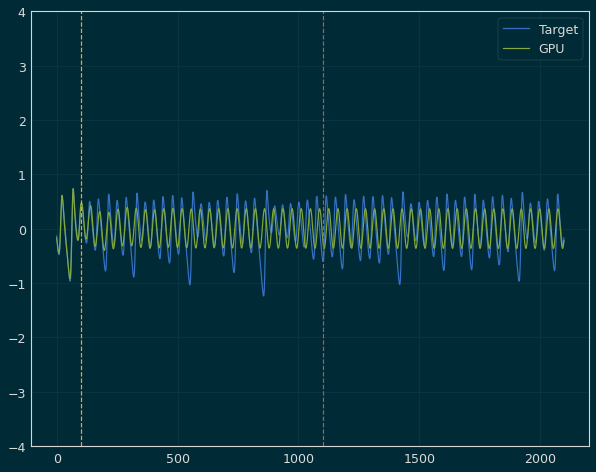

 Iter=30 a=0.037 sr=2.881 amp=0.070  ri=0.724 rr=0.178 loss=0.580239


Iter: 30 #### Diagnostic 0.580239   Time 6.06  Best 0.580 NRMSE 0.145 CD 0.435
Iter: 31 #### Diagnostic 1000.000000   Time 6.62  Best 0.580 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1.094348   Time 5.85  Best 0.580 NRMSE 0.187 CD 0.908
Iter: 33 #### Diagnostic 1.544108   Time 7.92  Best 0.580 NRMSE 0.536 CD 1.008
Iter: 34 #### Diagnostic 1000.000000   Time 7.29  Best 0.580 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1.083901   Time 6.91  Best 0.580 NRMSE 0.222 CD 0.862
Iter: 36 #### Diagnostic 1000.000000   Time 6.34  Best 0.580 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000000   Time 6.45  Best 0.580 NRMSE 9385659662964682752.000 CD 0.993
Iter: 38 #### Diagnostic 1000.000000   Time 6.37  Best 0.580 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000000   Time 6.04  Best 0.580 NRMSE 1000.000 CD 0.991
Iter: 40 #### Diagnostic 1.075039   Time 5.34  Best 0.580 NRMSE 0.184 CD 0.891
Iter: 41 #### Dia

Iter: 26 #### Diagnostic 0.829888   Time 5.96  Best 1000.000 NRMSE 0.199 CD 0.631
Iter: 27 #### Diagnostic 1000.000000   Time 5.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 3.999807   Time 7.28  Best 1000.000 NRMSE 2.954 CD 1.046
Iter: 29 #### Diagnostic 1000.000000   Time 6.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 7.62  Best 1000.000 NRMSE 1000.000 CD 0.994
Iter: 31 #### Diagnostic 1.117832   Time 7.52  Best 1000.000 NRMSE 0.185 CD 0.932
Iter: 32 #### Diagnostic 1.212002   Time 4.84  Best 1000.000 NRMSE 0.196 CD 1.016
Iter: 33 #### Diagnostic 1000.000000   Time 6.11  Best 1000.000 NRMSE 1000.000 CD 0.945
Iter: 34 #### Diagnostic 1.069904   Time 5.78  Best 1000.000 NRMSE 0.184 CD 0.886
Iter: 35 #### Diagnostic 1.035518   Time 6.19  Best 1000.000 NRMSE 0.183 CD 0.852
Iter: 36 #### Diagnostic 1000.000000   Time 6.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000000   Time 6.40  Best 1000.000 NRMSE 1000

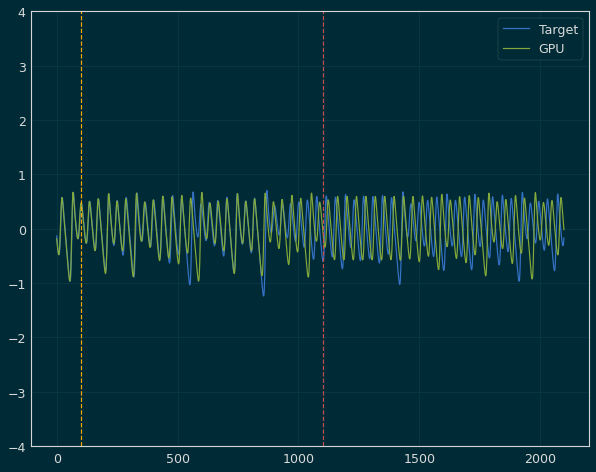

 Iter=98 a=0.515 sr=7.864 amp=0.185  ri=0.612 rr=2.905 loss=0.523678


Iter: 98 #### Diagnostic 0.523678   Time 6.88  Best 0.524 NRMSE 0.153 CD 0.370
Iter: 99 #### Diagnostic 1000.000000   Time 7.15  Best 0.524 NRMSE 1000.000 CD nan

Best result = 0.5236780560180443
a = 0.5152334579154145
sr = 7.863670612092308
amp = 0.18453003659579334
ri = 0.6123976126380598
rr = 2.9052400059584182
********** Size 500 -- Run 2 ***********
Iter: 0 #### Diagnostic 1.185167   Time 9.02  Best 1000.000 NRMSE 0.228 CD 0.957
Iter: 1 #### Diagnostic 1.288350   Time 7.93  Best 1000.000 NRMSE 0.197 CD 1.091
Iter: 2 #### Diagnostic 1000.000000   Time 6.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 7.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 7.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 0.681892   Time 5.43  Best 1000.000 NRMSE 0.175 CD 0.507
Iter: 6 #### Diagnostic 1000.000000   Time 6.94  Best 1000.000 NRMSE 1000.

Iter: 91 #### Diagnostic 1000.000000   Time 7.87  Best 1000.000 NRMSE 1000.000 CD 1.055
Iter: 92 #### Diagnostic 1000.000000   Time 6.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000000   Time 6.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1000.000000   Time 7.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1.528699   Time 6.95  Best 1000.000 NRMSE 0.531 CD 0.997
Iter: 96 #### Diagnostic 1000.000000   Time 7.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000000   Time 6.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1.545266   Time 6.27  Best 1000.000 NRMSE 0.536 CD 1.009
Iter: 99 #### Diagnostic 1.548460   Time 6.37  Best 1000.000 NRMSE 0.536 CD 1.013

Best result = 0.6653081879176536
a = 0.8439433068742357
sr = 3.914840734649073
amp = 0.5405794804932257
ri = 0.8263019473886593
rr = 2.6085000962337856
********** Size 500 -- Run 3 ***********
Iter: 0 #### Diagnostic 1000.000000   Time

Iter: 85 #### Diagnostic 1000.000000   Time 6.05  Best 1000.000 NRMSE 1000.000 CD 1.017
Iter: 86 #### Diagnostic 1000.000000   Time 6.56  Best 1000.000 NRMSE 6546.468 CD 1.011
Iter: 87 #### Diagnostic 0.810931   Time 7.34  Best 1000.000 NRMSE 0.175 CD 0.635
Iter: 88 #### Diagnostic 1000.000000   Time 6.96  Best 1000.000 NRMSE 1000.000 CD 1.000
Iter: 89 #### Diagnostic 1.073089   Time 5.50  Best 1000.000 NRMSE 0.184 CD 0.889
Iter: 90 #### Diagnostic 1000.000000   Time 6.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1.150064   Time 7.16  Best 1000.000 NRMSE 0.186 CD 0.964
Iter: 92 #### Diagnostic 0.922812   Time 5.37  Best 1000.000 NRMSE 0.180 CD 0.743
Iter: 93 #### Diagnostic 1000.000000   Time 5.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1000.000000   Time 7.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1000.000000   Time 8.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1.543889   Time 6.61  Best 1000.000 NRM

Iter: 79 #### Diagnostic 1000.000000   Time 8.90  Best 1000.000 NRMSE 1335.111 CD 1.005
Iter: 80 #### Diagnostic 1.073558   Time 6.62  Best 1000.000 NRMSE 0.183 CD 0.890
Iter: 81 #### Diagnostic 1000.000000   Time 5.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1000.000000   Time 5.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1000.000000   Time 8.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1.078480   Time 7.21  Best 1000.000 NRMSE 0.184 CD 0.894
Iter: 85 #### Diagnostic 1000.000000   Time 6.57  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1000.000000   Time 6.87  Best 1000.000 NRMSE 1000.000 CD 1.000
Iter: 87 #### Diagnostic 1000.000000   Time 8.62  Best 1000.000 NRMSE 1000.000 CD 0.992
Iter: 88 #### Diagnostic 1000.000000   Time 6.85  Best 1000.000 NRMSE 64651448053881499976222171304296448.000 CD 0.962
Iter: 89 #### Diagnostic 1.543195   Time 6.68  Best 1000.000 NRMSE 0.536 CD 1.007
Iter: 90 #### Diagnostic 0.

Iter: 66 #### Diagnostic 1.196627   Time 6.18  Best 1000.000 NRMSE 0.214 CD 0.982
Iter: 67 #### Diagnostic 1000.000000   Time 6.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 7.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1.135365   Time 6.22  Best 1000.000 NRMSE 0.200 CD 0.936
Iter: 70 #### Diagnostic 1000.000000   Time 7.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000000   Time 5.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000000   Time 7.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000000   Time 5.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000000   Time 7.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 0.906901   Time 6.91  Best 1000.000 NRMSE 0.180 CD 0.727
Iter: 76 #### Diagnostic 1000.000000   Time 8.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1.116613   Time 5.11  Best 1000.000 NRMSE

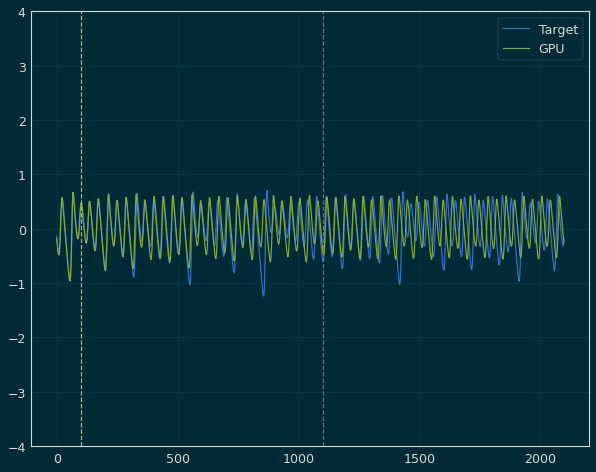

 Iter=91 a=0.272 sr=1.374 amp=0.774  ri=0.901 rr=4.851 loss=0.432897


Iter: 91 #### Diagnostic 0.432897   Time 6.65  Best 0.433 NRMSE 0.133 CD 0.299
Iter: 92 #### Diagnostic 1000.000000   Time 7.61  Best 0.433 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1.009611   Time 8.06  Best 0.433 NRMSE 0.182 CD 0.827
Iter: 94 #### Diagnostic 1.115325   Time 6.26  Best 0.433 NRMSE 0.185 CD 0.930
Iter: 95 #### Diagnostic 1000.000000   Time 8.25  Best 0.433 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000000   Time 7.32  Best 0.433 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000000   Time 8.03  Best 0.433 NRMSE 1000.000 CD 0.993
Iter: 98 #### Diagnostic 1.075429   Time 7.39  Best 0.433 NRMSE 0.184 CD 0.891
Iter: 99 #### Diagnostic 1.194997   Time 9.21  Best 0.433 NRMSE 0.217 CD 0.978

Best result = 0.43289700252864005
a = 0.27230973147805204
sr = 1.3740994519649334
amp = 0.7743398010973204
ri = 0.9009430571306739
rr = 4.851313897654532
********** Size 500 -- Run 1 ***********
Iter

Iter: 85 #### Diagnostic 1.020769   Time 7.14  Best 1000.000 NRMSE 0.183 CD 0.838
Iter: 86 #### Diagnostic 1000.000000   Time 5.79  Best 1000.000 NRMSE 1000.000 CD 0.980
Iter: 87 #### Diagnostic 1000.000000   Time 6.77  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000000   Time 6.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1000.000000   Time 6.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 936.125252   Time 7.85  Best 1000.000 NRMSE 935.127 CD 0.998
Iter: 91 #### Diagnostic 1000.000000   Time 7.93  Best 1000.000 NRMSE 23223.779 CD 1.003
Iter: 92 #### Diagnostic 1.082936   Time 8.67  Best 1000.000 NRMSE 0.185 CD 0.898
Iter: 93 #### Diagnostic 1000.000000   Time 6.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1.262877   Time 6.38  Best 1000.000 NRMSE 0.197 CD 1.066
Iter: 95 #### Diagnostic 1000.000000   Time 7.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000000   Time 7.32  Best 1000.0

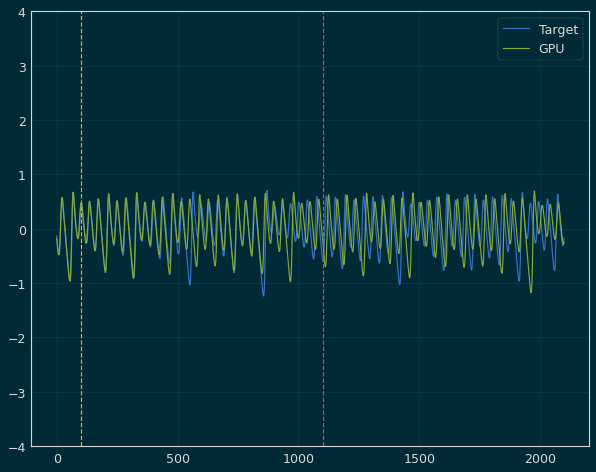

 Iter=20 a=0.234 sr=1.624 amp=0.958  ri=0.766 rr=0.942 loss=0.526228


Iter: 20 #### Diagnostic 0.526228   Time 6.87  Best 0.526 NRMSE 0.154 CD 0.372
Iter: 21 #### Diagnostic 1.022417   Time 6.25  Best 0.526 NRMSE 0.183 CD 0.839
Iter: 22 #### Diagnostic 1000.000000   Time 6.22  Best 0.526 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1.204432   Time 5.91  Best 0.526 NRMSE 0.226 CD 0.978
Iter: 24 #### Diagnostic 0.593735   Time 6.45  Best 0.526 NRMSE 0.163 CD 0.431
Iter: 25 #### Diagnostic 1000.000000   Time 7.31  Best 0.526 NRMSE 114971.287 CD 0.994
Iter: 26 #### Diagnostic 1000.000000   Time 7.11  Best 0.526 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 7.05  Best 0.526 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 6.53  Best 0.526 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.096529   Time 6.65  Best 0.526 NRMSE 0.185 CD 0.912
Iter: 30 #### Diagnostic 1000.000000   Time 6.76  Best 0.526 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.00

Iter: 16 #### Diagnostic 1000.000000   Time 6.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 5.81  Best 1000.000 NRMSE 1000.000 CD 0.996
Iter: 18 #### Diagnostic 0.985347   Time 6.95  Best 1000.000 NRMSE 0.182 CD 0.804
Iter: 19 #### Diagnostic 1000.000000   Time 6.86  Best 1000.000 NRMSE 1000.000 CD 1.001
Iter: 20 #### Diagnostic 1.055309   Time 5.13  Best 1000.000 NRMSE 0.184 CD 0.872
Iter: 21 #### Diagnostic 1000.000000   Time 6.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 7.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 7.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 5.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 6.98  Best 1000.000 NRMSE 1000.000 CD 0.992
Iter: 26 #### Diagnostic 1000.000000   Time 7.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 7.64  Best 1

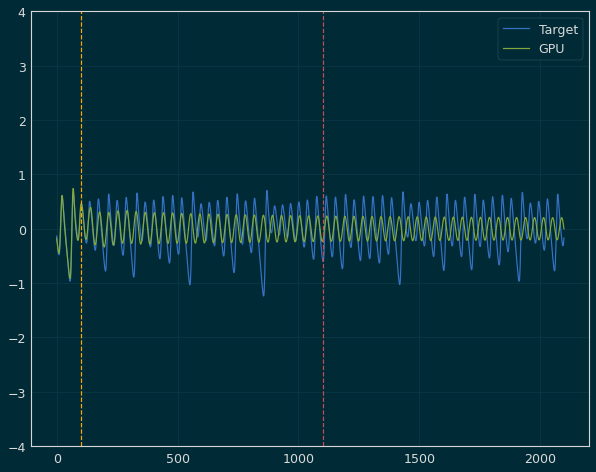

 Iter=38 a=0.032 sr=4.977 amp=0.059  ri=0.764 rr=1.435 loss=0.593866


Iter: 38 #### Diagnostic 0.593866   Time 8.93  Best 0.594 NRMSE 0.145 CD 0.449
Iter: 39 #### Diagnostic 1.075433   Time 7.10  Best 0.594 NRMSE 0.184 CD 0.891
Iter: 40 #### Diagnostic 1.099282   Time 5.33  Best 0.594 NRMSE 0.185 CD 0.914
Iter: 41 #### Diagnostic 1000.000000   Time 5.66  Best 0.594 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000000   Time 5.62  Best 0.594 NRMSE 1000.000 CD 1.005
Iter: 43 #### Diagnostic 1000.000000   Time 6.26  Best 0.594 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000000   Time 7.06  Best 0.594 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1.545177   Time 8.46  Best 0.594 NRMSE 0.536 CD 1.009
Iter: 46 #### Diagnostic 1000.000000   Time 6.12  Best 0.594 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000000   Time 7.44  Best 0.594 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1.020044   Time 6.88  Best 0.594 NRMSE 0.183 CD 0.837
Iter: 49 #### Diagnostic 1.023969 

Iter: 34 #### Diagnostic 1.067851   Time 6.52  Best 1000.000 NRMSE 0.184 CD 0.884
Iter: 35 #### Diagnostic 1000.000000   Time 9.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1.023432   Time 5.08  Best 1000.000 NRMSE 0.183 CD 0.841
Iter: 37 #### Diagnostic 1.543920   Time 8.06  Best 1000.000 NRMSE 0.536 CD 1.008
Iter: 38 #### Diagnostic 1000.000000   Time 7.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1.081379   Time 10.49  Best 1000.000 NRMSE 0.184 CD 0.897
Iter: 40 #### Diagnostic 1000.000000   Time 7.29  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000000   Time 7.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1.255285   Time 9.18  Best 1000.000 NRMSE 0.233 CD 1.022
Iter: 43 #### Diagnostic 1000.000000   Time 8.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000000   Time 5.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1.162229   Time 5.03  Best 1000.000 NRMSE 0.206 

Iter: 22 #### Diagnostic 1000.000000   Time 7.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 5.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 6.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 5.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 5.95  Best 1000.000 NRMSE 1000.000 CD 1.002
Iter: 27 #### Diagnostic 1000.000000   Time 9.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 8.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.565322   Time 6.81  Best 1000.000 NRMSE 0.536 CD 1.030
Iter: 30 #### Diagnostic 0.718891   Time 7.20  Best 1000.000 NRMSE 0.158 CD 0.561
Iter: 31 #### Diagnostic 1000.000000   Time 8.44  Best 1000.000 NRMSE 1000.000 CD 0.993
Iter: 32 #### Diagnostic 1.095114   Time 6.46  Best 1000.000 NRMSE 0.187 CD 0.908
Iter: 33 #### Diagnostic 1000.000000   Time 10.37  Best 1000.0

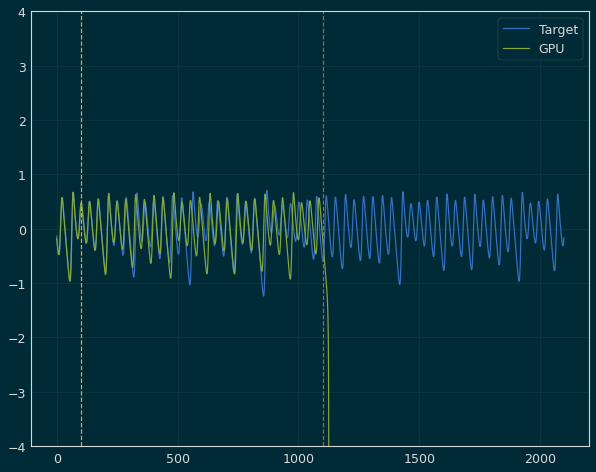

 Iter=48 a=0.617 sr=2.324 amp=0.888  ri=0.868 rr=1.440 loss=0.599166


Iter: 48 #### Diagnostic 0.599166   Time 7.97  Best 0.599 NRMSE 0.167 CD 0.432
Iter: 49 #### Diagnostic 1000.000000   Time 8.19  Best 0.599 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000000   Time 8.21  Best 0.599 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000000   Time 6.95  Best 0.599 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000000   Time 6.95  Best 0.599 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000000   Time 7.37  Best 0.599 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1.162211   Time 9.66  Best 0.599 NRMSE 0.186 CD 0.976
Iter: 55 #### Diagnostic 1.244545   Time 5.85  Best 0.599 NRMSE 0.223 CD 1.022
Iter: 56 #### Diagnostic 1.541460   Time 7.49  Best 0.599 NRMSE 0.536 CD 1.006
Iter: 57 #### Diagnostic 1000.000000   Time 6.27  Best 0.599 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 0.774062   Time 8.34  Best 0.599 NRMSE 0.201 CD 0.573
Iter: 59 #### Diagnostic 1000.000000

Iter: 44 #### Diagnostic 1.110618   Time 6.06  Best 1000.000 NRMSE 0.185 CD 0.926
Iter: 45 #### Diagnostic 1.276635   Time 7.32  Best 1000.000 NRMSE 0.236 CD 1.040
Iter: 46 #### Diagnostic 0.986559   Time 7.27  Best 1000.000 NRMSE 0.182 CD 0.804
Iter: 47 #### Diagnostic 1000.000000   Time 7.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 0.977386   Time 7.87  Best 1000.000 NRMSE 0.182 CD 0.795
Iter: 49 #### Diagnostic 1.079235   Time 7.79  Best 1000.000 NRMSE 0.195 CD 0.884
Iter: 50 #### Diagnostic 1.093615   Time 6.22  Best 1000.000 NRMSE 0.203 CD 0.891
Iter: 51 #### Diagnostic 1000.000000   Time 7.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1.014065   Time 7.36  Best 1000.000 NRMSE 0.182 CD 0.832
Iter: 53 #### Diagnostic 1000.000000   Time 6.82  Best 1000.000 NRMSE 1000.000 CD 1.102
Iter: 54 #### Diagnostic 0.668800   Time 5.89  Best 1000.000 NRMSE 0.175 CD 0.494
Iter: 55 #### Diagnostic 1000.000000   Time 8.48  Best 1000.000 NRMSE 1000.000 CD na

Iter: 39 #### Diagnostic 1.494777   Time 9.58  Best 1000.000 NRMSE 0.475 CD 1.020
Iter: 40 #### Diagnostic 1.077786   Time 6.38  Best 1000.000 NRMSE 0.184 CD 0.894
Iter: 41 #### Diagnostic 1000.000000   Time 7.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1.538944   Time 7.09  Best 1000.000 NRMSE 0.536 CD 1.003
Iter: 43 #### Diagnostic 1.265484   Time 7.02  Best 1000.000 NRMSE 0.203 CD 1.063
Iter: 44 #### Diagnostic 1000.000000   Time 7.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 6.67  Best 1000.000 NRMSE 4527516383440940772098048.000 CD 1.009
Iter: 46 #### Diagnostic 1000.000000   Time 6.57  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1.099627   Time 5.68  Best 1000.000 NRMSE 0.185 CD 0.915
Iter: 48 #### Diagnostic 1.107428   Time 5.91  Best 1000.000 NRMSE 0.211 CD 0.897
Iter: 49 #### Diagnostic 1.133326   Time 7.52  Best 1000.000 NRMSE 0.186 CD 0.947
Iter: 50 #### Diagnostic 1000.000000   Time 6.33  Best 1000

Iter: 33 #### Diagnostic 0.879833   Time 6.57  Best 1000.000 NRMSE 0.210 CD 0.670
Iter: 34 #### Diagnostic 1000.000000   Time 7.80  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000000   Time 6.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1.535801   Time 7.30  Best 1000.000 NRMSE 0.536 CD 1.000
Iter: 37 #### Diagnostic 1.095918   Time 6.80  Best 1000.000 NRMSE 0.185 CD 0.911
Iter: 38 #### Diagnostic 0.747037   Time 7.32  Best 1000.000 NRMSE 0.161 CD 0.586
Iter: 39 #### Diagnostic 1.073892   Time 8.37  Best 1000.000 NRMSE 0.184 CD 0.890
Iter: 40 #### Diagnostic 1.100269   Time 6.48  Best 1000.000 NRMSE 0.185 CD 0.915
Iter: 41 #### Diagnostic 1000.000000   Time 6.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000000   Time 5.34  Best 1000.000 NRMSE 1000.000 CD 1.015
Iter: 43 #### Diagnostic 1000.000000   Time 6.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000000   Time 6.20  Best 1000.000 NRMSE 1000.0

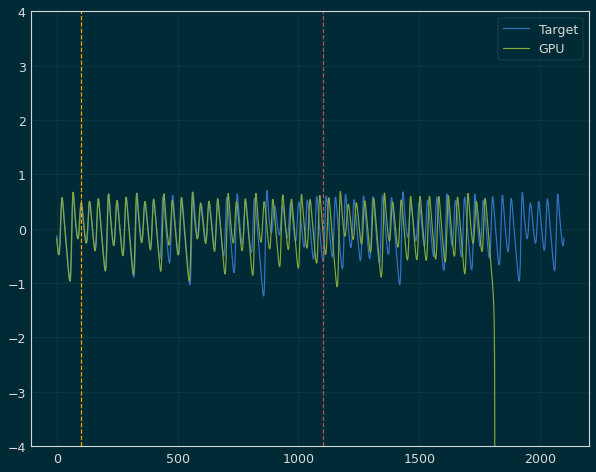

 Iter=7 a=0.311 sr=1.937 amp=0.811  ri=0.970 rr=3.990 loss=0.571105


Iter: 7 #### Diagnostic 0.571105   Time 6.14  Best 0.571 NRMSE 0.161 CD 0.410
Iter: 8 #### Diagnostic 0.899822   Time 7.28  Best 0.571 NRMSE 0.179 CD 0.721
Iter: 9 #### Diagnostic 1000.000000   Time 6.52  Best 0.571 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 8.31  Best 0.571 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1.228287   Time 8.52  Best 0.571 NRMSE 0.212 CD 1.016
Iter: 12 #### Diagnostic 1000.000000   Time 7.28  Best 0.571 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000000   Time 7.53  Best 0.571 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000000   Time 8.31  Best 0.571 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 8.72  Best 0.571 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 5.34  Best 0.571 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 5.95  Best 0.571 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.00

Iter: 0 #### Diagnostic 1.308706   Time 5.96  Best 1000.000 NRMSE 0.270 CD 1.039
Iter: 1 #### Diagnostic 1000.000000   Time 6.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 6.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 6.09  Best 1000.000 NRMSE 1000.000 CD 1.001
Iter: 4 #### Diagnostic 1.021755   Time 9.28  Best 1000.000 NRMSE 0.183 CD 0.839
Iter: 5 #### Diagnostic 1.486106   Time 8.42  Best 1000.000 NRMSE 0.487 CD 0.999
Iter: 6 #### Diagnostic 1000.000000   Time 6.29  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 5.88  Best 1000.000 NRMSE 1000.000 CD 0.993
Iter: 8 #### Diagnostic 0.776655   Time 5.50  Best 1000.000 NRMSE 0.171 CD 0.606
Iter: 9 #### Diagnostic 1000.000000   Time 5.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1.509773   Time 7.27  Best 1000.000 NRMSE 0.508 CD 1.002
Iter: 11 #### Diagnostic 1000.000000   Time 8.08  Best 1000.000 NRMSE 1000.000 C

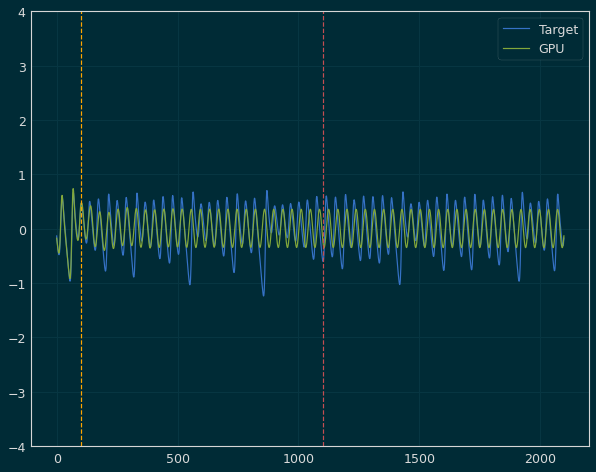

 Iter=30 a=0.037 sr=2.881 amp=0.070  ri=0.724 rr=0.178 loss=0.570619


Iter: 30 #### Diagnostic 0.570619   Time 7.99  Best 0.571 NRMSE 0.143 CD 0.427
Iter: 31 #### Diagnostic 1000.000000   Time 5.49  Best 0.571 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1.091913   Time 5.89  Best 0.571 NRMSE 0.187 CD 0.905
Iter: 33 #### Diagnostic 1000.000000   Time 5.89  Best 0.571 NRMSE 1000.000 CD 1.033
Iter: 34 #### Diagnostic 1000.000000   Time 8.31  Best 0.571 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1.417391   Time 5.13  Best 0.571 NRMSE 0.261 CD 1.157
Iter: 36 #### Diagnostic 1000.000000   Time 6.73  Best 0.571 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1.254039   Time 5.54  Best 0.571 NRMSE 0.246 CD 1.008
Iter: 38 #### Diagnostic 1000.000000   Time 6.67  Best 0.571 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000000   Time 7.25  Best 0.571 NRMSE 1000.000 CD 0.989
Iter: 40 #### Diagnostic 1.081225   Time 5.49  Best 0.571 NRMSE 0.184 CD 0.897
Iter: 41 #### Diagnostic 1.10800

Iter: 26 #### Diagnostic 1000.000000   Time 7.40  Best 1000.000 NRMSE 1000.000 CD 0.997
Iter: 27 #### Diagnostic 1000.000000   Time 5.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 6.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000000   Time 7.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 6.29  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1.117924   Time 5.27  Best 1000.000 NRMSE 0.185 CD 0.932
Iter: 32 #### Diagnostic 1.213616   Time 5.73  Best 1000.000 NRMSE 0.196 CD 1.017
Iter: 33 #### Diagnostic 1.539082   Time 4.94  Best 1000.000 NRMSE 0.536 CD 1.003
Iter: 34 #### Diagnostic 1.061874   Time 5.60  Best 1000.000 NRMSE 0.183 CD 0.878
Iter: 35 #### Diagnostic 1.051022   Time 7.89  Best 1000.000 NRMSE 0.184 CD 0.867
Iter: 36 #### Diagnostic 1000.000000   Time 6.49  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000000   Time 6.79  Best 1000.000 NRMSE 10

Iter: 21 #### Diagnostic 1.031332   Time 4.90  Best 1000.000 NRMSE 0.183 CD 0.848
Iter: 22 #### Diagnostic 1000.000000   Time 5.71  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1.169799   Time 5.84  Best 1000.000 NRMSE 0.220 CD 0.950
Iter: 24 #### Diagnostic 1000.000000   Time 7.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 5.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 5.27  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 6.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 4.78  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000000   Time 5.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 5.48  Best 1000.000 NRMSE 1000.000 CD 1.023
Iter: 31 #### Diagnostic 1000.000000   Time 5.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1.201067   Time 6.17  Best 1000.000

Iter: 15 #### Diagnostic 1000.000000   Time 5.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 5.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1.445321   Time 5.98  Best 1000.000 NRMSE 0.453 CD 0.992
Iter: 18 #### Diagnostic 0.971005   Time 6.51  Best 1000.000 NRMSE 0.181 CD 0.790
Iter: 19 #### Diagnostic 1000.000000   Time 6.06  Best 1000.000 NRMSE 1000.000 CD 1.088
Iter: 20 #### Diagnostic 1.062670   Time 5.50  Best 1000.000 NRMSE 0.184 CD 0.879
Iter: 21 #### Diagnostic 1000.000000   Time 6.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 5.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 5.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 5.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1.542262   Time 5.76  Best 1000.000 NRMSE 0.536 CD 1.006
Iter: 26 #### Diagnostic 0.620747   Time 6.72  Best 1000.000 NRMSE 0

Iter: 9 #### Diagnostic 1000.000000   Time 6.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 5.73  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1.143454   Time 7.26  Best 1000.000 NRMSE 0.198 CD 0.945
Iter: 12 #### Diagnostic 1000.000000   Time 5.22  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000000   Time 5.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000000   Time 7.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 7.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 7.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 6.02  Best 1000.000 NRMSE 419136920836813842890620928.000 CD 0.801
Iter: 18 #### Diagnostic 1000.000000   Time 5.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 5.03  Best 1000.000 NRMSE 4270537366734947.500 CD 0.994
Iter: 20 #### Diagno

Iter: 0 #### Diagnostic 0.848643   Time 6.33  Best 1000.000 NRMSE 0.199 CD 0.650
Iter: 1 #### Diagnostic 1000.000000   Time 8.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 5.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1.542927   Time 5.61  Best 1000.000 NRMSE 0.536 CD 1.007
Iter: 4 #### Diagnostic 1.022353   Time 5.62  Best 1000.000 NRMSE 0.183 CD 0.840
Iter: 5 #### Diagnostic 1.537537   Time 7.19  Best 1000.000 NRMSE 0.536 CD 1.002
Iter: 6 #### Diagnostic 1000.000000   Time 4.93  Best 1000.000 NRMSE 1000.000 CD 0.995
Iter: 7 #### Diagnostic 1000.000000   Time 5.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 0.749896   Time 6.11  Best 1000.000 NRMSE 0.168 CD 0.581
Iter: 9 #### Diagnostic 1000.000000   Time 7.92  Best 1000.000 NRMSE 1000.000 CD 0.972
Iter: 10 #### Diagnostic 1.536567   Time 7.83  Best 1000.000 NRMSE 0.536 CD 1.001
Iter: 11 #### Diagnostic 1000.000000   Time 6.09  Best 1000.000 NRMSE 1000.000 CD na

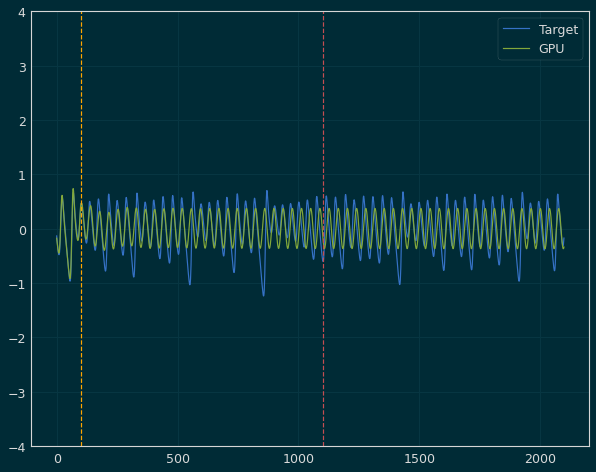

 Iter=30 a=0.037 sr=2.881 amp=0.070  ri=0.724 rr=0.178 loss=0.589353


Iter: 30 #### Diagnostic 0.589353   Time 6.04  Best 0.589 NRMSE 0.147 CD 0.443
Iter: 31 #### Diagnostic 1000.000000   Time 7.33  Best 0.589 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1.092942   Time 5.85  Best 0.589 NRMSE 0.187 CD 0.906
Iter: 33 #### Diagnostic 1000.000000   Time 7.62  Best 0.589 NRMSE 1000.000 CD 0.994
Iter: 34 #### Diagnostic 1000.000000   Time 6.36  Best 0.589 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1.425877   Time 6.02  Best 0.589 NRMSE 0.246 CD 1.180
Iter: 36 #### Diagnostic 1000.000000   Time 5.34  Best 0.589 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000000   Time 5.92  Best 0.589 NRMSE 783927069567925120286064640.000 CD 1.000
Iter: 38 #### Diagnostic 1000.000000   Time 8.37  Best 0.589 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1.534747   Time 7.82  Best 0.589 NRMSE 0.536 CD 0.999
Iter: 40 #### Diagnostic 1.078639   Time 5.39  Best 0.589 NRMSE 0.184 CD 0.894
Iter: 41 

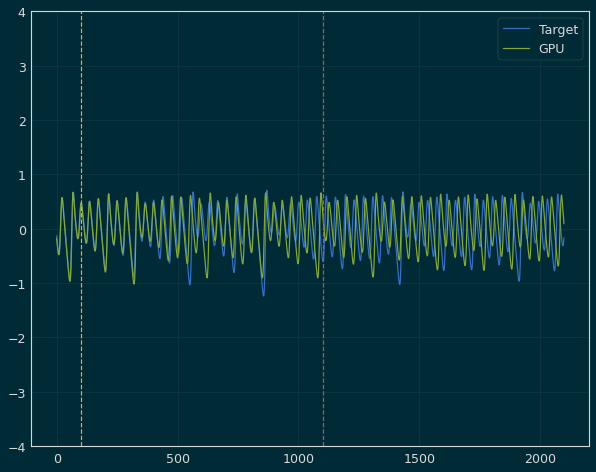

 Iter=25 a=0.712 sr=3.122 amp=0.537  ri=0.439 rr=0.095 loss=0.588846


Iter: 25 #### Diagnostic 0.588846   Time 5.81  Best 0.589 NRMSE 0.168 CD 0.421
Iter: 26 #### Diagnostic 0.830600   Time 5.08  Best 0.589 NRMSE 0.206 CD 0.625
Iter: 27 #### Diagnostic 1000.000000   Time 6.27  Best 0.589 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1.374362   Time 4.91  Best 0.589 NRMSE 0.359 CD 1.016
Iter: 29 #### Diagnostic 1000.000000   Time 5.31  Best 0.589 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 6.15  Best 0.589 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1.117803   Time 5.80  Best 0.589 NRMSE 0.185 CD 0.932
Iter: 32 #### Diagnostic 1.227596   Time 4.86  Best 0.589 NRMSE 0.197 CD 1.031
Iter: 33 #### Diagnostic 1.584773   Time 5.60  Best 0.589 NRMSE 0.536 CD 1.049
Iter: 34 #### Diagnostic 1.085826   Time 8.18  Best 0.589 NRMSE 0.184 CD 0.902
Iter: 35 #### Diagnostic 1.082029   Time 6.14  Best 0.589 NRMSE 0.184 CD 0.898
Iter: 36 #### Diagnostic 0.964652   Time 5.13  B

Iter: 21 #### Diagnostic 1.039156   Time 6.06  Best 1000.000 NRMSE 0.183 CD 0.856
Iter: 22 #### Diagnostic 1000.000000   Time 5.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1.214843   Time 5.79  Best 1000.000 NRMSE 0.227 CD 0.987
Iter: 24 #### Diagnostic 1.541643   Time 8.15  Best 1000.000 NRMSE 0.536 CD 1.006
Iter: 25 #### Diagnostic 1000.000000   Time 5.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 6.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 7.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 6.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.117591   Time 6.25  Best 1000.000 NRMSE 0.185 CD 0.933
Iter: 30 #### Diagnostic 1000.000000   Time 7.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000000   Time 8.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1.187464   Time 6.28  Best 1000.000 NRMSE 0.2

Iter: 16 #### Diagnostic 1000.000000   Time 6.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1.500163   Time 6.03  Best 1000.000 NRMSE 0.475 CD 1.025
Iter: 18 #### Diagnostic 0.965253   Time 6.70  Best 1000.000 NRMSE 0.181 CD 0.784
Iter: 19 #### Diagnostic 1000.000000   Time 5.52  Best 1000.000 NRMSE 1000.000 CD 0.998
Iter: 20 #### Diagnostic 1.053341   Time 6.18  Best 1000.000 NRMSE 0.184 CD 0.869
Iter: 21 #### Diagnostic 1000.000000   Time 5.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 6.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 8.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 5.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 6.76  Best 1000.000 NRMSE 1000.000 CD 0.994
Iter: 26 #### Diagnostic 1000.000000   Time 7.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 7.52  Best 1000.00

Iter: 11 #### Diagnostic 1.155581   Time 5.49  Best 1000.000 NRMSE 0.191 CD 0.965
Iter: 12 #### Diagnostic 1000.000000   Time 5.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000000   Time 5.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000000   Time 5.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 7.20  Best 1000.000 NRMSE 1000.000 CD 0.995
Iter: 16 #### Diagnostic 1000.000000   Time 6.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 7.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000000   Time 7.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 8.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000000   Time 6.18  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000000   Time 5.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 0.790124   Time 6.25  Best 1000

Iter: 0 #### Diagnostic 1000.000000   Time 5.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000000   Time 6.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 6.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 5.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1.007424   Time 6.12  Best 1000.000 NRMSE 0.182 CD 0.825
Iter: 5 #### Diagnostic 1000.000000   Time 5.86  Best 1000.000 NRMSE 1000.000 CD 0.997
Iter: 6 #### Diagnostic 1000.000000   Time 5.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 7.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 0.765214   Time 7.85  Best 1000.000 NRMSE 0.170 CD 0.595
Iter: 9 #### Diagnostic 1000.000000   Time 5.82  Best 1000.000 NRMSE 1000.000 CD 1.002
Iter: 10 #### Diagnostic 1000.000000   Time 5.39  Best 1000.000 NRMSE 1000.000 CD 1.001
Iter: 11 #### Diagnostic 1000.000000   Time 5.49  Best 1000.000 NR

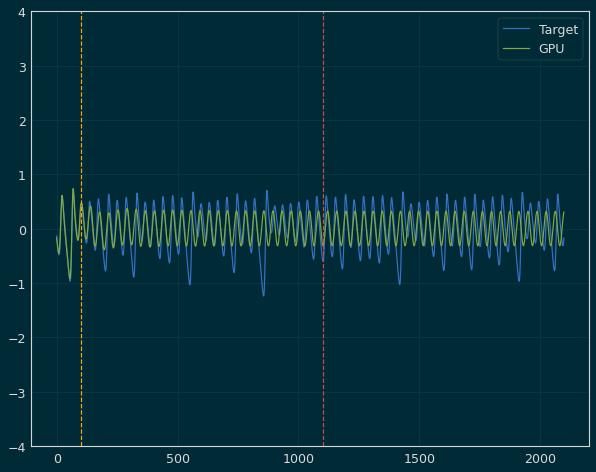

 Iter=30 a=0.037 sr=2.881 amp=0.070  ri=0.724 rr=0.178 loss=0.575727


Iter: 30 #### Diagnostic 0.575727   Time 7.27  Best 0.576 NRMSE 0.142 CD 0.434
Iter: 31 #### Diagnostic 1.543913   Time 6.46  Best 0.576 NRMSE 0.536 CD 1.008
Iter: 32 #### Diagnostic 1.091311   Time 5.28  Best 0.576 NRMSE 0.187 CD 0.905
Iter: 33 #### Diagnostic 1000.000000   Time 6.09  Best 0.576 NRMSE 1000.000 CD 0.994
Iter: 34 #### Diagnostic 1000.000000   Time 6.65  Best 0.576 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1.294387   Time 4.93  Best 0.576 NRMSE 0.240 CD 1.054
Iter: 36 #### Diagnostic 0.872809   Time 6.37  Best 0.576 NRMSE 0.205 CD 0.668
Iter: 37 #### Diagnostic 1000.000000   Time 7.20  Best 0.576 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 0.811654   Time 6.00  Best 0.576 NRMSE 0.191 CD 0.620
Iter: 39 #### Diagnostic 1.355908   Time 5.66  Best 0.576 NRMSE 0.265 CD 1.091
Iter: 40 #### Diagnostic 1.080214   Time 6.18  Best 0.576 NRMSE 0.184 CD 0.896
Iter: 41 #### Diagnostic 1.109275   Time 6.40 

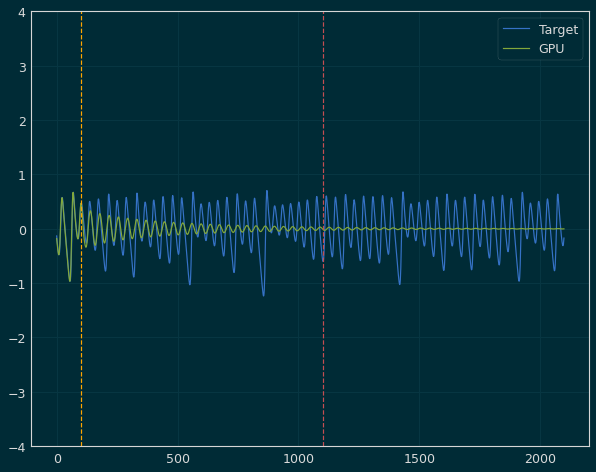

 Iter=22 a=0.715 sr=0.705 amp=0.159  ri=0.672 rr=2.005 loss=0.599701


Iter: 22 #### Diagnostic 0.599701   Time 5.97  Best 0.600 NRMSE 0.161 CD 0.438
Iter: 23 #### Diagnostic 1000.000000   Time 6.79  Best 0.600 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 6.34  Best 0.600 NRMSE 1000.000 CD 1.003
Iter: 25 #### Diagnostic 1.417521   Time 5.72  Best 0.600 NRMSE 0.392 CD 1.025
Iter: 26 #### Diagnostic 1.534539   Time 6.14  Best 0.600 NRMSE 0.536 CD 0.999
Iter: 27 #### Diagnostic 1000.000000   Time 7.55  Best 0.600 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 14.037209   Time 5.86  Best 0.600 NRMSE 13.143 CD 0.894
Iter: 29 #### Diagnostic 1000.000000   Time 6.21  Best 0.600 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 7.69  Best 0.600 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1.117713   Time 7.41  Best 0.600 NRMSE 0.185 CD 0.932
Iter: 32 #### Diagnostic 1.225103   Time 5.34  Best 0.600 NRMSE 0.197 CD 1.028
Iter: 33 #### Diagnostic 1.538408   

Iter: 19 #### Diagnostic 1000.000000   Time 6.76  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1.605047   Time 5.50  Best 1000.000 NRMSE 0.606 CD 0.999
Iter: 21 #### Diagnostic 1.040517   Time 5.23  Best 1000.000 NRMSE 0.183 CD 0.857
Iter: 22 #### Diagnostic 1000.000000   Time 7.16  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1.217243   Time 5.68  Best 1000.000 NRMSE 0.222 CD 0.996
Iter: 24 #### Diagnostic 1.429947   Time 5.20  Best 1000.000 NRMSE 0.438 CD 0.992
Iter: 25 #### Diagnostic 0.644105   Time 5.54  Best 1000.000 NRMSE 0.172 CD 0.472
Iter: 26 #### Diagnostic 1000.000000   Time 6.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 6.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 6.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.071707   Time 5.35  Best 1000.000 NRMSE 0.184 CD 0.888
Iter: 30 #### Diagnostic 1000.000000   Time 5.70  Best 1000.000 NRMSE 1000.000

Iter: 14 #### Diagnostic 1000.000000   Time 5.27  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 0.678647   Time 4.79  Best 1000.000 NRMSE 0.176 CD 0.502
Iter: 16 #### Diagnostic 1000.000000   Time 7.54  Best 1000.000 NRMSE 1000.000 CD nan


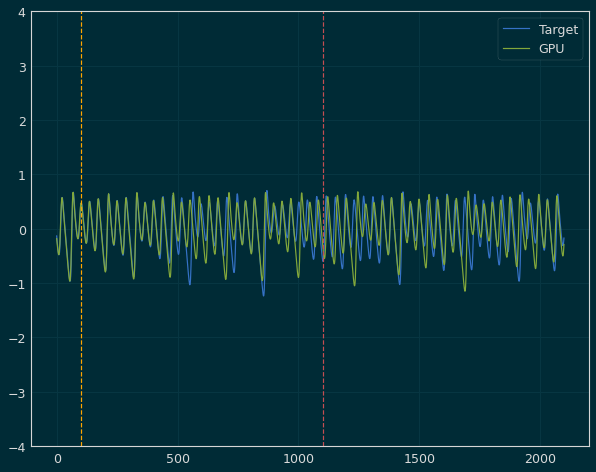

 Iter=17 a=0.282 sr=1.464 amp=0.893  ri=0.670 rr=0.865 loss=0.526635


Iter: 17 #### Diagnostic 0.526635   Time 5.80  Best 0.527 NRMSE 0.153 CD 0.373
Iter: 18 #### Diagnostic 1.009773   Time 5.05  Best 0.527 NRMSE 0.183 CD 0.827
Iter: 19 #### Diagnostic 1.547001   Time 6.05  Best 0.527 NRMSE 0.536 CD 1.011
Iter: 20 #### Diagnostic 1.065280   Time 5.08  Best 0.527 NRMSE 0.184 CD 0.881
Iter: 21 #### Diagnostic 1000.000000   Time 5.91  Best 0.527 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 0.678275   Time 7.23  Best 0.527 NRMSE 0.172 CD 0.506
Iter: 23 #### Diagnostic 1000.000000   Time 5.15  Best 0.527 NRMSE 1000.000 CD 0.999
Iter: 24 #### Diagnostic 1000.000000   Time 6.26  Best 0.527 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1.542370   Time 5.82  Best 0.527 NRMSE 0.536 CD 1.007
Iter: 26 #### Diagnostic 1000.000000   Time 6.83  Best 0.527 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 5.53  Best 0.527 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000  

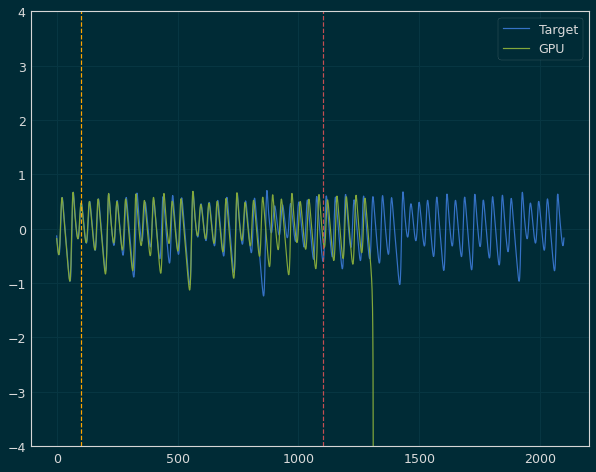

 Iter=7 a=0.311 sr=1.937 amp=0.811  ri=0.970 rr=3.990 loss=0.511071


Iter: 7 #### Diagnostic 0.511071   Time 5.33  Best 0.511 NRMSE 0.151 CD 0.360
Iter: 8 #### Diagnostic 0.908437   Time 6.47  Best 0.511 NRMSE 0.180 CD 0.729
Iter: 9 #### Diagnostic 1000.000000   Time 5.91  Best 0.511 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 5.44  Best 0.511 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1.201482   Time 5.34  Best 0.511 NRMSE 0.202 CD 1.000
Iter: 12 #### Diagnostic 1000.000000   Time 7.91  Best 0.511 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000000   Time 5.73  Best 0.511 NRMSE 1000.000 CD 1.000
Iter: 14 #### Diagnostic 1000.000000   Time 5.31  Best 0.511 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 6.37  Best 0.511 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 6.28  Best 0.511 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 7.01  Best 0.511 NRMSE 1572012473962.550 CD 0.999
Iter: 18 #### Diagn

Iter: 0 #### Diagnostic 1.508748   Time 5.83  Best 1000.000 NRMSE 0.508 CD 1.001
Iter: 1 #### Diagnostic 1000.000000   Time 5.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 5.76  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 7.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 0.996203   Time 5.71  Best 1000.000 NRMSE 0.182 CD 0.814
Iter: 5 #### Diagnostic 1000.000000   Time 6.13  Best 1000.000 NRMSE 1000.000 CD 0.995
Iter: 6 #### Diagnostic 1000.000000   Time 5.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 5.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 0.754674   Time 5.23  Best 1000.000 NRMSE 0.169 CD 0.586
Iter: 9 #### Diagnostic 1000.000000   Time 7.73  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1.536408   Time 5.51  Best 1000.000 NRMSE 0.536 CD 1.001
Iter: 11 #### Diagnostic 1000.000000   Time 5.41  Best 1000.000 NRMSE 1000.000

Iter: 97 #### Diagnostic 1000.000000   Time 5.49  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1.077143   Time 5.92  Best 1000.000 NRMSE 0.184 CD 0.893
Iter: 99 #### Diagnostic 1.198536   Time 5.30  Best 1000.000 NRMSE 0.220 CD 0.979

Best result = 0.6021652096114898
a = 0.03714899719480398
sr = 2.8805199282091567
amp = 0.07049883500355729
ri = 0.7238811678690714
rr = 0.17771174677320598
********** Size 400 -- Run 1 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 7.78  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000000   Time 6.74  Best 1000.000 NRMSE 1000.000 CD 0.998
Iter: 2 #### Diagnostic 1.083835   Time 6.01  Best 1000.000 NRMSE 0.184 CD 0.899
Iter: 3 #### Diagnostic 1000.000000   Time 5.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 5.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 7.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000000   Time 5

Iter: 92 #### Diagnostic 1.078670   Time 6.44  Best 1000.000 NRMSE 0.185 CD 0.894
Iter: 93 #### Diagnostic 1000.000000   Time 5.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1.264704   Time 5.86  Best 1000.000 NRMSE 0.196 CD 1.069
Iter: 95 #### Diagnostic 1000.000000   Time 5.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000000   Time 6.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1.114324   Time 5.11  Best 1000.000 NRMSE 0.207 CD 0.908
Iter: 98 #### Diagnostic 1000.000000   Time 6.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1000.000000   Time 6.13  Best 1000.000 NRMSE 1000.000 CD nan

Best result = 0.6813725248758691
a = 0.26990238613731193
sr = 1.5067866103635317
amp = 0.8059565645988673
ri = 0.9886389487803539
rr = 0.16737977126921752
********** Size 400 -- Run 2 ***********
Iter: 0 #### Diagnostic 1.329349   Time 6.30  Best 1000.000 NRMSE 0.245 CD 1.084
Iter: 1 #### Diagnostic 1.285115   Time 6.18  

Iter: 86 #### Diagnostic 1000.000000   Time 5.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1000.000000   Time 7.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000000   Time 7.37  Best 1000.000 NRMSE 1809002415.277 CD 1.012
Iter: 89 #### Diagnostic 1.540998   Time 5.91  Best 1000.000 NRMSE 0.536 CD 1.005
Iter: 90 #### Diagnostic 1000.000000   Time 5.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000000   Time 6.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000000   Time 4.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000000   Time 7.16  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1000.000000   Time 5.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1000.000000   Time 6.84  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000000   Time 6.18  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000000   Time 6.12  

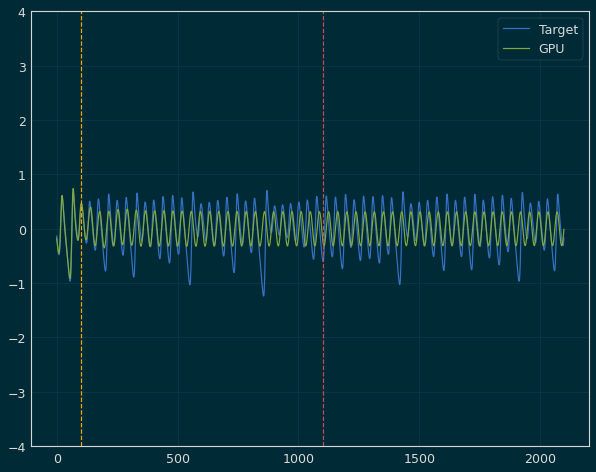

 Iter=38 a=0.032 sr=4.977 amp=0.059  ri=0.764 rr=1.435 loss=0.557098


Iter: 38 #### Diagnostic 0.557098   Time 5.32  Best 0.557 NRMSE 0.142 CD 0.415
Iter: 39 #### Diagnostic 1.076930   Time 6.28  Best 0.557 NRMSE 0.184 CD 0.893
Iter: 40 #### Diagnostic 1.080180   Time 7.37  Best 0.557 NRMSE 0.184 CD 0.896
Iter: 41 #### Diagnostic 1000.000000   Time 7.03  Best 0.557 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000000   Time 6.89  Best 0.557 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1000.000000   Time 5.13  Best 0.557 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000000   Time 6.88  Best 0.557 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 5.68  Best 0.557 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000000   Time 4.82  Best 0.557 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000000   Time 4.91  Best 0.557 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1.021685   Time 4.98  Best 0.557 NRMSE 0.183 CD 0.839
Iter: 49 #### Diagnostic 1.03533

Iter: 33 #### Diagnostic 0.969328   Time 4.96  Best 1000.000 NRMSE 0.182 CD 0.788
Iter: 34 #### Diagnostic 1.067955   Time 4.68  Best 1000.000 NRMSE 0.184 CD 0.884
Iter: 35 #### Diagnostic 1000.000000   Time 4.66  Best 1000.000 NRMSE 1000.000 CD 0.992
Iter: 36 #### Diagnostic 1.003676   Time 5.45  Best 1000.000 NRMSE 0.182 CD 0.822
Iter: 37 #### Diagnostic 1000.000000   Time 7.62  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000000   Time 5.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1.051782   Time 5.86  Best 1000.000 NRMSE 0.184 CD 0.868
Iter: 40 #### Diagnostic 1000.000000   Time 6.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000000   Time 4.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1.186942   Time 6.82  Best 1000.000 NRMSE 0.216 CD 0.971
Iter: 43 #### Diagnostic 1000.000000   Time 5.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000000   Time 5.82  Best 1000.000 NRMSE 10

Iter: 21 #### Diagnostic 1.045942   Time 7.73  Best 1000.000 NRMSE 0.192 CD 0.854
Iter: 22 #### Diagnostic 1000.000000   Time 5.80  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 6.27  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 5.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 6.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 6.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 4.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 5.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.561842   Time 5.76  Best 1000.000 NRMSE 0.536 CD 1.026
Iter: 30 #### Diagnostic 0.733689   Time 5.27  Best 1000.000 NRMSE 0.175 CD 0.558
Iter: 31 #### Diagnostic 1000.000000   Time 5.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1.092949   Time 7.24  Best 1000.000 NRMSE

Iter: 16 #### Diagnostic 1000.000000   Time 5.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1.065461   Time 5.11  Best 1000.000 NRMSE 0.184 CD 0.881
Iter: 18 #### Diagnostic 1000.000000   Time 5.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 5.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1.051144   Time 5.42  Best 1000.000 NRMSE 0.184 CD 0.868
Iter: 21 #### Diagnostic 1000.000000   Time 5.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 0.644438   Time 5.36  Best 1000.000 NRMSE 0.165 CD 0.479
Iter: 23 #### Diagnostic 1000.000000   Time 5.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1.634991   Time 6.36  Best 1000.000 NRMSE 0.536 CD 1.099
Iter: 25 #### Diagnostic 1.425465   Time 5.11  Best 1000.000 NRMSE 0.380 CD 1.045
Iter: 26 #### Diagnostic 1000.000000   Time 6.09  Best 1000.000 NRMSE 1000.000 CD 1.000
Iter: 27 #### Diagnostic 1000.000000   Time 5.71  Best 1000.000 NRMSE 10

Iter: 11 #### Diagnostic 1000.000000   Time 6.40  Best 1000.000 NRMSE 33549494627.563 CD 0.990
Iter: 12 #### Diagnostic 1000.000000   Time 5.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000000   Time 5.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1.080208   Time 5.48  Best 1000.000 NRMSE 0.184 CD 0.896
Iter: 15 #### Diagnostic 1000.000000   Time 7.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1.054113   Time 6.03  Best 1000.000 NRMSE 0.184 CD 0.870
Iter: 17 #### Diagnostic 1000.000000   Time 5.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 0.860331   Time 5.28  Best 1000.000 NRMSE 0.205 CD 0.656
Iter: 19 #### Diagnostic 1000.000000   Time 6.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000000   Time 4.92  Best 1000.000 NRMSE 1000.000 CD 1.001
Iter: 21 #### Diagnostic 1.046882   Time 6.21  Best 1000.000 NRMSE 0.184 CD 0.863
Iter: 22 #### Diagnostic 1000.000000   Time 5.85  Best 1000

Iter: 6 #### Diagnostic 1000.000000   Time 6.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 6.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 5.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000000   Time 5.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1.166321   Time 5.46  Best 1000.000 NRMSE 0.209 CD 0.957
Iter: 11 #### Diagnostic 1000.000000   Time 7.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000000   Time 6.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000000   Time 5.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000000   Time 5.56  Best 1000.000 NRMSE 1000.000 CD 0.994
Iter: 15 #### Diagnostic 1000.000000   Time 6.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 5.73  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1.374745   Time 5.12  Best 1000.000

Iter: 1 #### Diagnostic 1000.000000   Time 5.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 5.62  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 5.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 6.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 5.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000000   Time 5.32  Best 1000.000 NRMSE 13567298.347 CD 1.011
Iter: 7 #### Diagnostic 0.682919   Time 6.73  Best 1000.000 NRMSE 0.185 CD 0.498
Iter: 8 #### Diagnostic 0.888857   Time 4.92  Best 1000.000 NRMSE 0.179 CD 0.710
Iter: 9 #### Diagnostic 1000.000000   Time 6.18  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 5.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1.176958   Time 6.66  Best 1000.000 NRMSE 0.204 CD 0.973
Iter: 12 #### Diagnostic 1000.000000   Time 6.45  Best 1000.000 NRMSE

Iter: 98 #### Diagnostic 1000.000000   Time 5.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1.026100   Time 5.55  Best 1000.000 NRMSE 0.183 CD 0.843

Best result = 0.6829191716597687
a = 0.3113493629641517
sr = 1.9373518901313793
amp = 0.8112648939015601
ri = 0.9698845682931436
rr = 3.9901691322945982
Refined search bounds:

Alpha (0.01616030730267015, 0.5228582486146478)

Rho (1.6025829187464309, 6.418674593237222)

Gamma (0.030228980627375904, 0.5805106435418443)

r-in (0.3247994356898619, 1.2337377476719082)

r-res (0.3924704484928564, 3.0911859395762162)

End Refinement Run 4 Time 2959.013
********** Size 300 -- Run 0 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 6.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000000   Time 6.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 5.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 6.02  Best 1000.000 NRMSE 1000.000 CD 1.0

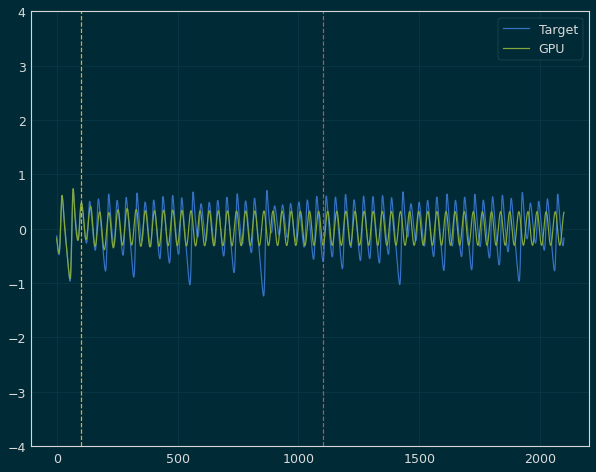

 Iter=30 a=0.037 sr=2.881 amp=0.070  ri=0.724 rr=0.178 loss=0.566740


Iter: 30 #### Diagnostic 0.566740   Time 6.30  Best 0.567 NRMSE 0.141 CD 0.426
Iter: 31 #### Diagnostic 0.816277   Time 6.67  Best 0.567 NRMSE 0.193 CD 0.623
Iter: 32 #### Diagnostic 1.090634   Time 5.37  Best 0.567 NRMSE 0.187 CD 0.904
Iter: 33 #### Diagnostic 1000.000000   Time 5.29  Best 0.567 NRMSE 1000.000 CD 0.999
Iter: 34 #### Diagnostic 1000.000000   Time 7.57  Best 0.567 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1.139079   Time 5.47  Best 0.567 NRMSE 0.220 CD 0.919
Iter: 36 #### Diagnostic 1000.000000   Time 5.51  Best 0.567 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1.545548   Time 8.71  Best 0.567 NRMSE 0.536 CD 1.010
Iter: 38 #### Diagnostic 1000.000000   Time 8.98  Best 0.567 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 0.780798   Time 5.49  Best 0.567 NRMSE 0.196 CD 0.585
Iter: 40 #### Diagnostic 1.083200   Time 5.00  Best 0.567 NRMSE 0.184 CD 0.899
Iter: 41 #### Diagnostic 1.106623   Time 7

Iter: 26 #### Diagnostic 1.510408   Time 5.14  Best 1000.000 NRMSE 0.518 CD 0.993
Iter: 27 #### Diagnostic 1000.000000   Time 5.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 6.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000000   Time 6.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 5.62  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1.116940   Time 6.37  Best 1000.000 NRMSE 0.185 CD 0.932
Iter: 32 #### Diagnostic 1.242970   Time 4.73  Best 1000.000 NRMSE 0.198 CD 1.045
Iter: 33 #### Diagnostic 1.538325   Time 6.14  Best 1000.000 NRMSE 0.536 CD 1.003
Iter: 34 #### Diagnostic 1.065231   Time 7.02  Best 1000.000 NRMSE 0.184 CD 0.882
Iter: 35 #### Diagnostic 1.041899   Time 7.29  Best 1000.000 NRMSE 0.183 CD 0.859
Iter: 36 #### Diagnostic 1.093444   Time 6.97  Best 1000.000 NRMSE 0.140 CD 0.953
Iter: 37 #### Diagnostic 1.537278   Time 6.54  Best 1000.000 NRMSE 0.536 CD 1.001


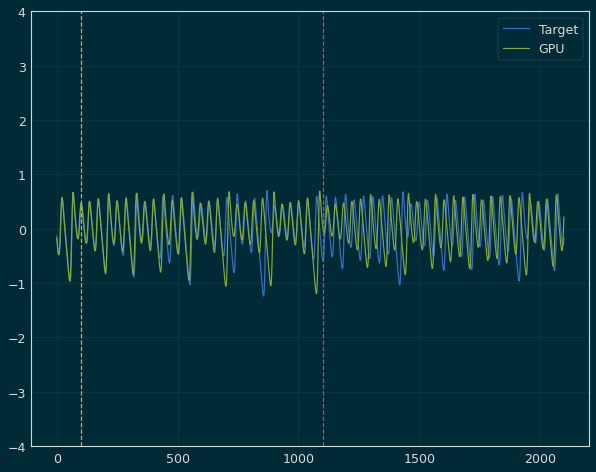

 Iter=62 a=0.706 sr=5.607 amp=0.238  ri=0.418 rr=0.894 loss=0.595656


Iter: 62 #### Diagnostic 0.595656   Time 7.32  Best 0.596 NRMSE 0.158 CD 0.438
Iter: 63 #### Diagnostic 1.186271   Time 5.54  Best 0.596 NRMSE 0.205 CD 0.981
Iter: 64 #### Diagnostic 1000.000000   Time 6.16  Best 0.596 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000000   Time 5.89  Best 0.596 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000000   Time 6.27  Best 0.596 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 5.14  Best 0.596 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 7.37  Best 0.596 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000000   Time 6.83  Best 0.596 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000000   Time 6.47  Best 0.596 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000000   Time 7.14  Best 0.596 NRMSE 1000.000 CD 0.999
Iter: 72 #### Diagnostic 1.493843   Time 6.17  Best 0.596 NRMSE 0.511 CD 0.983
Iter: 73 #### Diagnostic 1

Iter: 56 #### Diagnostic 1000.000000   Time 6.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000000   Time 5.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 5.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1.046489   Time 5.64  Best 1000.000 NRMSE 0.184 CD 0.863
Iter: 60 #### Diagnostic 1000.000000   Time 7.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 7.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 6.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1.081688   Time 5.76  Best 1000.000 NRMSE 0.184 CD 0.898
Iter: 64 #### Diagnostic 1000.000000   Time 5.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000000   Time 7.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1.246949   Time 5.15  Best 1000.000 NRMSE 0.249 CD 0.998
Iter: 67 #### Diagnostic 1.026992   Time 5.68  Best 1000.000 NRMSE

Iter: 51 #### Diagnostic 1000.000000   Time 5.41  Best 1000.000 NRMSE 1000.000 CD 0.992
Iter: 52 #### Diagnostic 1000.000000   Time 5.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000000   Time 5.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000000   Time 6.15  Best 1000.000 NRMSE 1000.000 CD 1.020
Iter: 55 #### Diagnostic 1000.000000   Time 5.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 0.965536   Time 6.64  Best 1000.000 NRMSE 0.180 CD 0.785
Iter: 57 #### Diagnostic 1.154974   Time 6.57  Best 1000.000 NRMSE 0.187 CD 0.968
Iter: 58 #### Diagnostic 1000.000000   Time 6.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000000   Time 5.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1.057972   Time 7.13  Best 1000.000 NRMSE 0.256 CD 0.802
Iter: 61 #### Diagnostic 1000.000000   Time 5.59  Best 1000.000 NRMSE 1000.000 CD 1.040
Iter: 62 #### Diagnostic 1.058402   Time 5.73  Best 1000.000

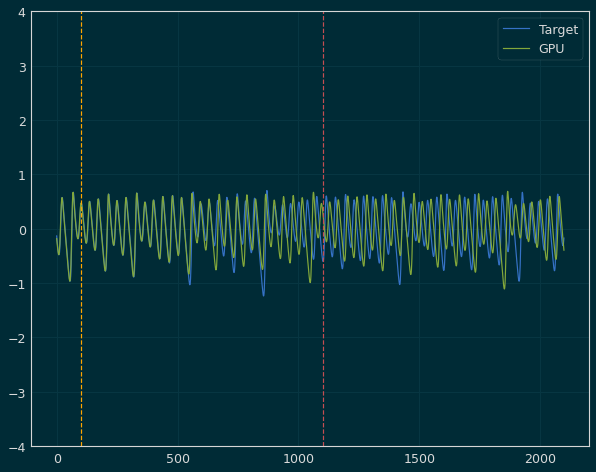

 Iter=3 a=0.527 sr=4.150 amp=0.657  ri=0.606 rr=0.196 loss=0.537301


Iter: 3 #### Diagnostic 0.537301   Time 7.22  Best 0.537 NRMSE 0.161 CD 0.377
Iter: 4 #### Diagnostic 1000.000000   Time 5.73  Best 0.537 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 6.75  Best 0.537 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000000   Time 5.43  Best 0.537 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1.218353   Time 5.98  Best 0.537 NRMSE 0.218 CD 1.000
Iter: 8 #### Diagnostic 0.888274   Time 5.71  Best 0.537 NRMSE 0.179 CD 0.709
Iter: 9 #### Diagnostic 1000.000000   Time 5.65  Best 0.537 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 4.87  Best 0.537 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1.180781   Time 7.39  Best 0.537 NRMSE 0.194 CD 0.986
Iter: 12 #### Diagnostic 1000.000000   Time 7.52  Best 0.537 NRMSE 1000.000 CD 1.001
Iter: 13 #### Diagnostic 1000.000000   Time 6.99  Best 0.537 NRMSE 1000.000 CD 0.975
Iter: 14 #### Diagnostic 1000.000000

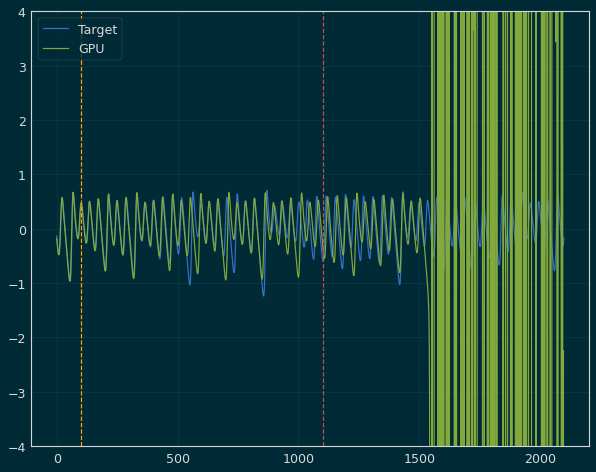

 Iter=88 a=0.643 sr=2.973 amp=0.714  ri=0.667 rr=4.086 loss=0.517181


Iter: 88 #### Diagnostic 0.517181   Time 8.52  Best 0.517 NRMSE 0.151 CD 0.367
Iter: 89 #### Diagnostic 1000.000000   Time 5.44  Best 0.517 NRMSE 1000.000 CD 0.994
Iter: 90 #### Diagnostic 1000.000000   Time 5.64  Best 0.517 NRMSE 1000.000 CD 1.005
Iter: 91 #### Diagnostic 1000.000000   Time 6.19  Best 0.517 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1.263587   Time 5.38  Best 0.517 NRMSE 0.212 CD 1.051
Iter: 93 #### Diagnostic 1.109728   Time 5.22  Best 0.517 NRMSE 0.191 CD 0.919
Iter: 94 #### Diagnostic 1.500866   Time 5.41  Best 0.517 NRMSE 0.239 CD 1.261
Iter: 95 #### Diagnostic 0.960131   Time 6.93  Best 0.517 NRMSE 0.182 CD 0.778
Iter: 96 #### Diagnostic 1000.000000   Time 5.52  Best 0.517 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000000   Time 7.02  Best 0.517 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1000.000000   Time 6.72  Best 0.517 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1.03827

Iter: 75 #### Diagnostic 0.980886   Time 6.18  Best 1000.000 NRMSE 0.181 CD 0.800
Iter: 76 #### Diagnostic 1000.000000   Time 5.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1.091111   Time 4.73  Best 1000.000 NRMSE 0.185 CD 0.906
Iter: 78 #### Diagnostic 1.140182   Time 5.83  Best 1000.000 NRMSE 0.186 CD 0.954
Iter: 79 #### Diagnostic 1000.000000   Time 5.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000000   Time 6.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1000.000000   Time 6.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1000.000000   Time 6.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1.190011   Time 5.27  Best 1000.000 NRMSE 0.197 CD 0.993
Iter: 84 #### Diagnostic 1000.000000   Time 6.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 0.662356   Time 5.42  Best 1000.000 NRMSE 0.169 CD 0.493
Iter: 86 #### Diagnostic 1000.000000   Time 5.52  Best 1000.000 NRMSE 1000

Iter: 70 #### Diagnostic 1000.000000   Time 6.49  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1.482492   Time 5.59  Best 1000.000 NRMSE 0.487 CD 0.995
Iter: 72 #### Diagnostic 1000.000000   Time 6.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000000   Time 4.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000000   Time 4.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000000   Time 5.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000000   Time 6.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1000.000000   Time 6.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1000.000000   Time 5.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1.532367   Time 7.71  Best 1000.000 NRMSE 0.536 CD 0.997
Iter: 80 #### Diagnostic 1000.000000   Time 5.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1000.000000   Time 7.08  Best 1000.00

Iter: 65 #### Diagnostic 1000.000000   Time 7.57  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1.282019   Time 6.93  Best 1000.000 NRMSE 0.252 CD 1.030
Iter: 67 #### Diagnostic 1.057694   Time 6.05  Best 1000.000 NRMSE 0.184 CD 0.874
Iter: 68 #### Diagnostic 1000.000000   Time 5.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1.213191   Time 5.18  Best 1000.000 NRMSE 0.207 CD 1.006
Iter: 70 #### Diagnostic 1.075955   Time 5.35  Best 1000.000 NRMSE 0.184 CD 0.892
Iter: 71 #### Diagnostic 1000.000000   Time 5.13  Best 1000.000 NRMSE 1000.000 CD 1.078
Iter: 72 #### Diagnostic 1.062863   Time 5.48  Best 1000.000 NRMSE 0.184 CD 0.879
Iter: 73 #### Diagnostic 1000.000000   Time 5.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000000   Time 5.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000000   Time 5.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1.101687   Time 4.62  Best 1000.000 NRMSE 0.185

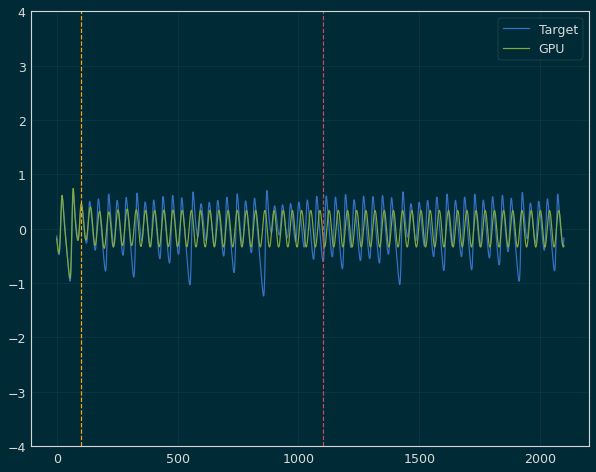

 Iter=38 a=0.032 sr=4.977 amp=0.059  ri=0.764 rr=1.435 loss=0.583925


Iter: 38 #### Diagnostic 0.583925   Time 5.84  Best 0.584 NRMSE 0.146 CD 0.438
Iter: 39 #### Diagnostic 1.075813   Time 5.82  Best 0.584 NRMSE 0.184 CD 0.892
Iter: 40 #### Diagnostic 1.083221   Time 5.40  Best 0.584 NRMSE 0.184 CD 0.899
Iter: 41 #### Diagnostic 1000.000000   Time 4.93  Best 0.584 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000000   Time 5.37  Best 0.584 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1000.000000   Time 6.36  Best 0.584 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000000   Time 5.49  Best 0.584 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 5.06  Best 0.584 NRMSE 1000.000 CD 1.033
Iter: 46 #### Diagnostic 1000.000000   Time 6.00  Best 0.584 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000000   Time 5.74  Best 0.584 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1.031268   Time 5.93  Best 0.584 NRMSE 0.183 CD 0.848
Iter: 49 #### Diagnostic 1.027

Iter: 34 #### Diagnostic 1.067393   Time 4.96  Best 1000.000 NRMSE 0.184 CD 0.883
Iter: 35 #### Diagnostic 1000.000000   Time 5.18  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 0.993336   Time 7.74  Best 1000.000 NRMSE 0.182 CD 0.811
Iter: 37 #### Diagnostic 1000.000000   Time 5.63  Best 1000.000 NRMSE 1000.000 CD 0.992
Iter: 38 #### Diagnostic 1000.000000   Time 4.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1.079174   Time 5.44  Best 1000.000 NRMSE 0.184 CD 0.895
Iter: 40 #### Diagnostic 1000.000000   Time 5.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 0.747960   Time 7.31  Best 1000.000 NRMSE 0.195 CD 0.553
Iter: 42 #### Diagnostic 1.337542   Time 5.30  Best 1000.000 NRMSE 0.232 CD 1.105
Iter: 43 #### Diagnostic 1000.000000   Time 5.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000000   Time 6.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1.141664   Time 5.98  Best 1000.000 NRMSE 0.194

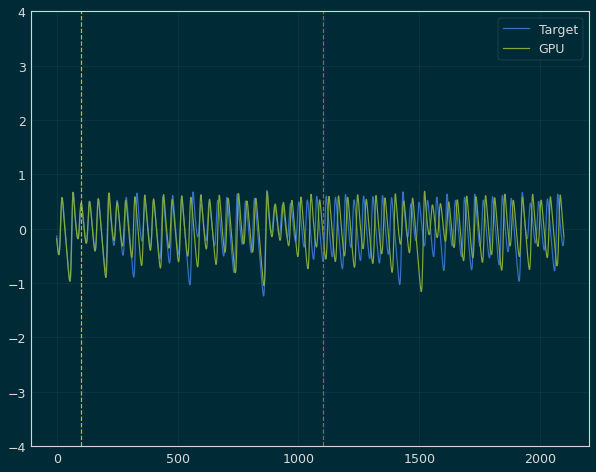

 Iter=91 a=0.499 sr=7.530 amp=0.212  ri=0.912 rr=4.779 loss=0.577650


Iter: 91 #### Diagnostic 0.577650   Time 6.24  Best 0.578 NRMSE 0.168 CD 0.410
Iter: 92 #### Diagnostic 1.342392   Time 6.00  Best 0.578 NRMSE 0.216 CD 1.126
Iter: 93 #### Diagnostic 1.039615   Time 5.24  Best 0.578 NRMSE 0.199 CD 0.841
Iter: 94 #### Diagnostic 1.097452   Time 5.32  Best 0.578 NRMSE 0.202 CD 0.896
Iter: 95 #### Diagnostic 0.963576   Time 6.15  Best 0.578 NRMSE 0.182 CD 0.782
Iter: 96 #### Diagnostic 1000.000000   Time 6.04  Best 0.578 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000000   Time 7.16  Best 0.578 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1000.000000   Time 7.04  Best 0.578 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1.033284   Time 5.89  Best 0.578 NRMSE 0.183 CD 0.850

Best result = 0.5776498850934436
a = 0.4988333873512395
sr = 7.530084884742864
amp = 0.21198161837610838
ri = 0.9117082660171554
rr = 4.7792045696453025

Best mn:0.032	 mn:0.499
New bounds mn--mx: 0.006--0

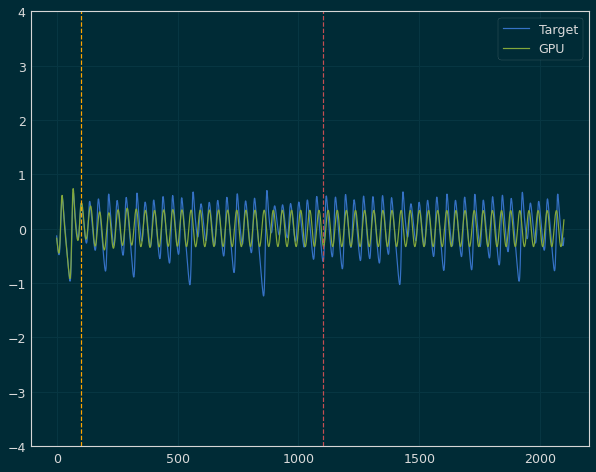

 Iter=30 a=0.037 sr=2.881 amp=0.070  ri=0.724 rr=0.178 loss=0.566981


Iter: 30 #### Diagnostic 0.566981   Time 5.38  Best 0.567 NRMSE 0.142 CD 0.425
Iter: 31 #### Diagnostic 0.884385   Time 6.47  Best 0.567 NRMSE 0.206 CD 0.679
Iter: 32 #### Diagnostic 1.090351   Time 7.28  Best 0.567 NRMSE 0.187 CD 0.904
Iter: 33 #### Diagnostic 1000.000000   Time 5.61  Best 0.567 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000000   Time 5.73  Best 0.567 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1.100460   Time 6.16  Best 0.567 NRMSE 0.214 CD 0.886
Iter: 36 #### Diagnostic 1000.000000   Time 6.55  Best 0.567 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 0.835782   Time 5.78  Best 0.567 NRMSE 0.205 CD 0.631
Iter: 38 #### Diagnostic 1.179931   Time 5.25  Best 0.567 NRMSE 0.225 CD 0.955
Iter: 39 #### Diagnostic 1000.000000   Time 6.28  Best 0.567 NRMSE 1000.000 CD 0.997
Iter: 40 #### Diagnostic 1.084160   Time 5.55  Best 0.567 NRMSE 0.184 CD 0.900
Iter: 41 #### Diagnostic 1.096700   Time 6

Iter: 26 #### Diagnostic 1000.000000   Time 4.83  Best 1000.000 NRMSE 1000.000 CD 1.001
Iter: 27 #### Diagnostic 1000.000000   Time 6.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 4.050289   Time 5.18  Best 1000.000 NRMSE 3.220 CD 0.830
Iter: 29 #### Diagnostic 1000.000000   Time 5.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 5.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1.117220   Time 4.90  Best 1000.000 NRMSE 0.185 CD 0.932
Iter: 32 #### Diagnostic 1.245262   Time 4.58  Best 1000.000 NRMSE 0.198 CD 1.047
Iter: 33 #### Diagnostic 1000.000000   Time 5.36  Best 1000.000 NRMSE 1000.000 CD 0.996
Iter: 34 #### Diagnostic 1.066411   Time 5.34  Best 1000.000 NRMSE 0.184 CD 0.883
Iter: 35 #### Diagnostic 1.013938   Time 5.22  Best 1000.000 NRMSE 0.183 CD 0.831
Iter: 36 #### Diagnostic 0.733521   Time 5.60  Best 1000.000 NRMSE 0.182 CD 0.551
Iter: 37 #### Diagnostic 1000.000000   Time 6.25  Best 1000.000 NRMSE 1000

Iter: 21 #### Diagnostic 1.031183   Time 5.35  Best 1000.000 NRMSE 0.183 CD 0.848
Iter: 22 #### Diagnostic 1000.000000   Time 5.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1.192718   Time 6.28  Best 1000.000 NRMSE 0.226 CD 0.967
Iter: 24 #### Diagnostic 1.542898   Time 6.04  Best 1000.000 NRMSE 0.536 CD 1.007
Iter: 25 #### Diagnostic 1000.000000   Time 6.75  Best 1000.000 NRMSE 2370943317660691456.000 CD 0.985
Iter: 26 #### Diagnostic 1000.000000   Time 5.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 5.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 5.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.072240   Time 7.27  Best 1000.000 NRMSE 0.184 CD 0.888
Iter: 30 #### Diagnostic 1000.000000   Time 4.97  Best 1000.000 NRMSE 1000.000 CD 0.971
Iter: 31 #### Diagnostic 1000.000000   Time 5.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1.181617   Time 6.75  Best

Iter: 16 #### Diagnostic 1000.000000   Time 5.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 0.754934   Time 4.64  Best 1000.000 NRMSE 0.191 CD 0.564
Iter: 18 #### Diagnostic 0.968655   Time 5.60  Best 1000.000 NRMSE 0.181 CD 0.787
Iter: 19 #### Diagnostic 1.535190   Time 7.15  Best 1000.000 NRMSE 0.536 CD 0.999
Iter: 20 #### Diagnostic 1.061003   Time 6.90  Best 1000.000 NRMSE 0.184 CD 0.877
Iter: 21 #### Diagnostic 1000.000000   Time 5.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 0.811045   Time 5.02  Best 1000.000 NRMSE 0.198 CD 0.613
Iter: 23 #### Diagnostic 1000.000000   Time 5.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 6.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 5.33  Best 1000.000 NRMSE 1000.000 CD 0.994
Iter: 26 #### Diagnostic 1000.000000   Time 5.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 5.85  Best 1000.000 NRMSE 10

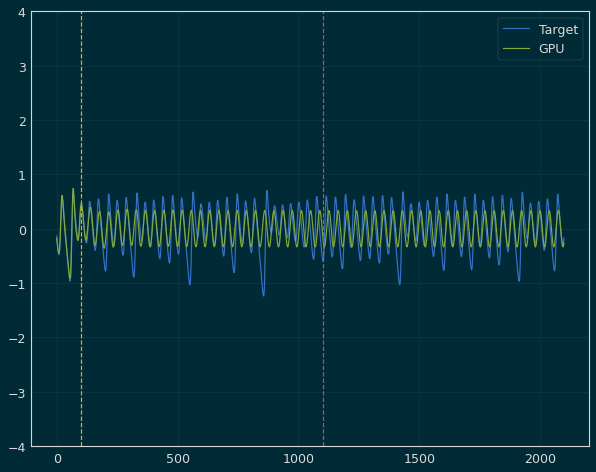

 Iter=38 a=0.032 sr=4.977 amp=0.059  ri=0.764 rr=1.435 loss=0.580863


Iter: 38 #### Diagnostic 0.580863   Time 5.92  Best 0.581 NRMSE 0.145 CD 0.436
Iter: 39 #### Diagnostic 1.080539   Time 5.88  Best 0.581 NRMSE 0.184 CD 0.896
Iter: 40 #### Diagnostic 1.086008   Time 6.99  Best 0.581 NRMSE 0.185 CD 0.901
Iter: 41 #### Diagnostic 1000.000000   Time 5.36  Best 0.581 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000000   Time 5.69  Best 0.581 NRMSE 1000.000 CD 0.997
Iter: 43 #### Diagnostic 1000.000000   Time 4.99  Best 0.581 NRMSE 1000.000 CD nan


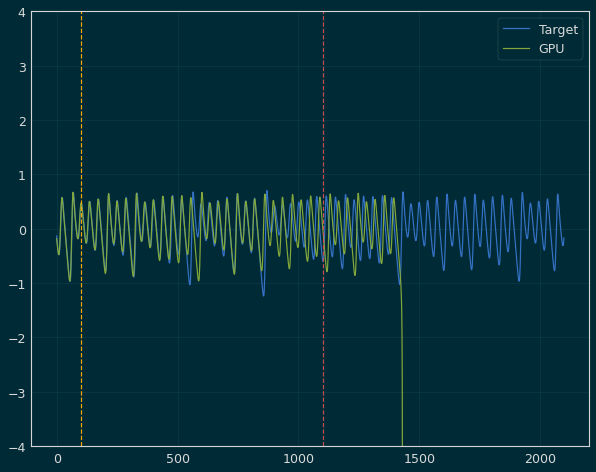

 Iter=44 a=0.580 sr=2.097 amp=0.690  ri=0.649 rr=4.377 loss=0.551872


Iter: 44 #### Diagnostic 0.551872   Time 6.39  Best 0.552 NRMSE 0.159 CD 0.392
Iter: 45 #### Diagnostic 1000.000000   Time 6.06  Best 0.552 NRMSE 1000.000 CD 1.068
Iter: 46 #### Diagnostic 1000.000000   Time 5.03  Best 0.552 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000000   Time 5.97  Best 0.552 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1.016397   Time 5.53  Best 0.552 NRMSE 0.183 CD 0.834
Iter: 49 #### Diagnostic 1.043879   Time 5.25  Best 0.552 NRMSE 0.184 CD 0.860
Iter: 50 #### Diagnostic 1000.000000   Time 5.92  Best 0.552 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000000   Time 4.60  Best 0.552 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000000   Time 6.54  Best 0.552 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000000   Time 5.49  Best 0.552 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1.532940   Time 5.29  Best 0.552 NRMSE 0.536 CD 0.997
Iter: 55 #### Diagnostic 1000.

Iter: 39 #### Diagnostic 1.058198   Time 4.91  Best 1000.000 NRMSE 0.184 CD 0.875
Iter: 40 #### Diagnostic 1000.000000   Time 5.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000000   Time 5.09  Best 1000.000 NRMSE 21255.694 CD 0.991
Iter: 42 #### Diagnostic 1.273128   Time 6.26  Best 1000.000 NRMSE 0.220 CD 1.053
Iter: 43 #### Diagnostic 1000.000000   Time 5.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000000   Time 4.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 0.973255   Time 5.69  Best 1000.000 NRMSE 0.181 CD 0.792
Iter: 46 #### Diagnostic 1.215715   Time 6.51  Best 1000.000 NRMSE 0.235 CD 0.981
Iter: 47 #### Diagnostic 1.168898   Time 6.67  Best 1000.000 NRMSE 0.211 CD 0.958
Iter: 48 #### Diagnostic 1000.000000   Time 5.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1.100239   Time 4.72  Best 1000.000 NRMSE 0.185 CD 0.915
Iter: 50 #### Diagnostic 1.247428   Time 5.69  Best 1000.000 NRMSE 0.197 CD

Iter: 27 #### Diagnostic 1000.000000   Time 5.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 6.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000000   Time 4.79  Best 1000.000 NRMSE 1000.000 CD 0.973


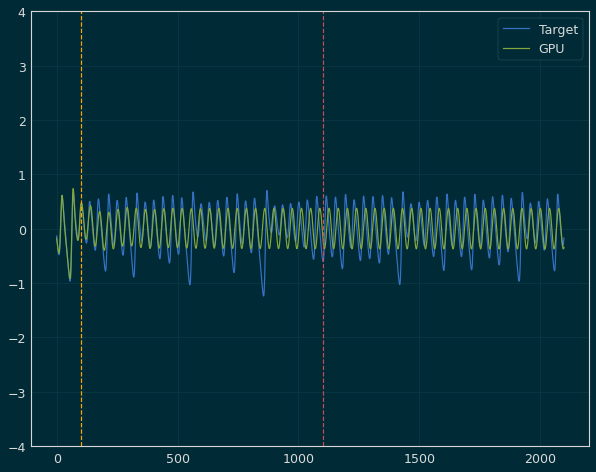

 Iter=30 a=0.037 sr=2.881 amp=0.070  ri=0.724 rr=0.178 loss=0.591117


Iter: 30 #### Diagnostic 0.591117   Time 6.40  Best 0.591 NRMSE 0.147 CD 0.444
Iter: 31 #### Diagnostic 1000.000000   Time 5.63  Best 0.591 NRMSE 1000.000 CD 0.994
Iter: 32 #### Diagnostic 1.090064   Time 5.08  Best 0.591 NRMSE 0.187 CD 0.903
Iter: 33 #### Diagnostic 1000.000000   Time 6.51  Best 0.591 NRMSE 1000.000 CD 1.012
Iter: 34 #### Diagnostic 1000.000000   Time 5.60  Best 0.591 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1.166143   Time 5.11  Best 0.591 NRMSE 0.227 CD 0.939
Iter: 36 #### Diagnostic 1000.000000   Time 5.35  Best 0.591 NRMSE 1000.000 CD nan
Iter: 37 #### Diagnostic 1000.000000   Time 5.40  Best 0.591 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 0.648542   Time 5.32  Best 0.591 NRMSE 0.175 CD 0.473
Iter: 39 #### Diagnostic 1.519646   Time 5.43  Best 0.591 NRMSE 0.520 CD 1.000
Iter: 40 #### Diagnostic 1.086136   Time 5.78  Best 0.591 NRMSE 0.185 CD 0.902
Iter: 41 #### Diagnostic 1.068939   

Iter: 27 #### Diagnostic 1.111549   Time 4.78  Best 1000.000 NRMSE 0.211 CD 0.901
Iter: 28 #### Diagnostic 11.707372   Time 4.99  Best 1000.000 NRMSE 10.737 CD 0.970
Iter: 29 #### Diagnostic 1000.000000   Time 5.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 4.68  Best 1000.000 NRMSE 142391106602923229184.000 CD 1.006
Iter: 31 #### Diagnostic 1.117006   Time 4.98  Best 1000.000 NRMSE 0.185 CD 0.932
Iter: 32 #### Diagnostic 1.243328   Time 4.35  Best 1000.000 NRMSE 0.198 CD 1.046
Iter: 33 #### Diagnostic 1.394358   Time 5.23  Best 1000.000 NRMSE 0.386 CD 1.009
Iter: 34 #### Diagnostic 1.056461   Time 4.61  Best 1000.000 NRMSE 0.183 CD 0.873
Iter: 35 #### Diagnostic 1.054247   Time 4.92  Best 1000.000 NRMSE 0.184 CD 0.871
Iter: 36 #### Diagnostic 0.729131   Time 4.55  Best 1000.000 NRMSE 0.183 CD 0.547
Iter: 37 #### Diagnostic 1000.000000   Time 5.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000000   Time 4.64  Best 1000.000 N

Iter: 22 #### Diagnostic 1000.000000   Time 5.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1.094833   Time 4.82  Best 1000.000 NRMSE 0.210 CD 0.885
Iter: 24 #### Diagnostic 1000.000000   Time 5.27  Best 1000.000 NRMSE 1000.000 CD 0.996
Iter: 25 #### Diagnostic 0.740278   Time 4.70  Best 1000.000 NRMSE 0.192 CD 0.548
Iter: 26 #### Diagnostic 1000.000000   Time 5.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 4.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 5.28  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.095901   Time 4.92  Best 1000.000 NRMSE 0.185 CD 0.911
Iter: 30 #### Diagnostic 1000.000000   Time 5.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000000   Time 4.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1.182109   Time 6.30  Best 1000.000 NRMSE 0.214 CD 0.968
Iter: 33 #### Diagnostic 0.989799   Time 5.17  Best 1000.000 NRMSE 0

Iter: 17 #### Diagnostic 0.815691   Time 4.91  Best 1000.000 NRMSE 0.196 CD 0.619
Iter: 18 #### Diagnostic 0.986222   Time 4.57  Best 1000.000 NRMSE 0.182 CD 0.805
Iter: 19 #### Diagnostic 1.547347   Time 4.77  Best 1000.000 NRMSE 0.536 CD 1.012
Iter: 20 #### Diagnostic 1.064295   Time 5.01  Best 1000.000 NRMSE 0.184 CD 0.880
Iter: 21 #### Diagnostic 1000.000000   Time 5.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 4.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 5.18  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 5.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 4.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 4.76  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 5.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 4.50  Best 1000.000 NRMSE 

Iter: 12 #### Diagnostic 1000.000000   Time 5.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000000   Time 5.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000000   Time 6.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 4.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 5.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 0.819380   Time 5.47  Best 1000.000 NRMSE 0.204 CD 0.616
Iter: 18 #### Diagnostic 1000.000000   Time 4.76  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 0.840176   Time 4.89  Best 1000.000 NRMSE 0.201 CD 0.639
Iter: 20 #### Diagnostic 1000.000000   Time 5.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000000   Time 4.76  Best 1000.000 NRMSE 1000.000 CD 1.014
Iter: 22 #### Diagnostic 1000.000000   Time 5.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 5.10  Best 1000.

Iter: 0 #### Diagnostic 1000.000000   Time 4.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000000   Time 5.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 5.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 5.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 0.995323   Time 5.16  Best 1000.000 NRMSE 0.182 CD 0.813
Iter: 5 #### Diagnostic 1000.000000   Time 4.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000000   Time 4.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 4.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 0.796191   Time 5.08  Best 1000.000 NRMSE 0.172 CD 0.624
Iter: 9 #### Diagnostic 1000.000000   Time 5.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 5.12  Best 1000.000 NRMSE 1000.000 CD 1.009
Iter: 11 #### Diagnostic 1000.000000   Time 4.65  Best 1000.000 NRMSE 

Iter: 97 #### Diagnostic 1000.000000   Time 5.02  Best 1000.000 NRMSE 1000.000 CD 0.991
Iter: 98 #### Diagnostic 1.070448   Time 5.78  Best 1000.000 NRMSE 0.184 CD 0.886
Iter: 99 #### Diagnostic 1.207451   Time 4.99  Best 1000.000 NRMSE 0.227 CD 0.981

Best result = 0.6048810704856022
a = 0.03714899719480398
sr = 2.8805199282091567
amp = 0.07049883500355729
ri = 0.7238811678690714
rr = 0.17771174677320598
********** Size 300 -- Run 1 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 4.61  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1.535729   Time 5.44  Best 1000.000 NRMSE 0.536 CD 1.000
Iter: 2 #### Diagnostic 1.081284   Time 5.21  Best 1000.000 NRMSE 0.184 CD 0.897
Iter: 3 #### Diagnostic 1000.000000   Time 5.29  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 5.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 4.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000000   Time 6.00 

Iter: 92 #### Diagnostic 1.079131   Time 6.21  Best 1000.000 NRMSE 0.185 CD 0.894
Iter: 93 #### Diagnostic 1000.000000   Time 4.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1.261519   Time 5.62  Best 1000.000 NRMSE 0.196 CD 1.066
Iter: 95 #### Diagnostic 1000.000000   Time 6.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000000   Time 5.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1.170245   Time 4.72  Best 1000.000 NRMSE 0.219 CD 0.951
Iter: 98 #### Diagnostic 1000.000000   Time 4.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1000.000000   Time 5.07  Best 1000.000 NRMSE 1000.000 CD nan

Best result = 0.6680567112839523
a = 0.7150072815807585
sr = 0.7050825340006261
amp = 0.1587803981135049
ri = 0.6721325871346834
rr = 2.004582537193211
********** Size 300 -- Run 2 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 4.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1.286008   Time 5.09 

Iter: 87 #### Diagnostic 1000.000000   Time 4.76  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000000   Time 5.16  Best 1000.000 NRMSE 5849358787627.060 CD 1.014
Iter: 89 #### Diagnostic 1000.000000   Time 4.82  Best 1000.000 NRMSE 1000.000 CD 1.002
Iter: 90 #### Diagnostic 1000.000000   Time 4.57  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000000   Time 4.44  Best 1000.000 NRMSE 1000.000 CD 1.000
Iter: 92 #### Diagnostic 1000.000000   Time 5.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000000   Time 4.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1000.000000   Time 4.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1000.000000   Time 4.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000000   Time 4.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000000   Time 5.79  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1000.000000   

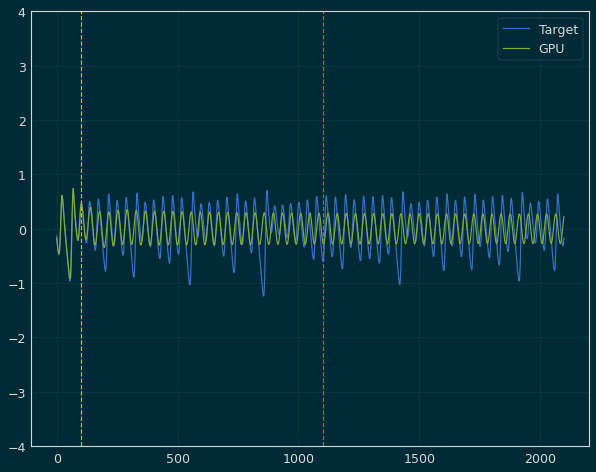

 Iter=38 a=0.032 sr=4.977 amp=0.059  ri=0.764 rr=1.435 loss=0.548223


Iter: 38 #### Diagnostic 0.548223   Time 5.05  Best 0.548 NRMSE 0.140 CD 0.408
Iter: 39 #### Diagnostic 1.078216   Time 5.57  Best 0.548 NRMSE 0.184 CD 0.894
Iter: 40 #### Diagnostic 1.084846   Time 5.26  Best 0.548 NRMSE 0.185 CD 0.900
Iter: 41 #### Diagnostic 1000.000000   Time 4.87  Best 0.548 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000000   Time 5.20  Best 0.548 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1000.000000   Time 5.06  Best 0.548 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000000   Time 5.10  Best 0.548 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 4.87  Best 0.548 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000000   Time 4.46  Best 0.548 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000000   Time 4.84  Best 0.548 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1.041095   Time 5.61  Best 0.548 NRMSE 0.183 CD 0.858
Iter: 49 #### Diagnostic 1.00902

Iter: 33 #### Diagnostic 0.948838   Time 4.81  Best 1000.000 NRMSE 0.181 CD 0.768
Iter: 34 #### Diagnostic 1.067977   Time 4.45  Best 1000.000 NRMSE 0.184 CD 0.884
Iter: 35 #### Diagnostic 1000.000000   Time 4.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1.016930   Time 5.02  Best 1000.000 NRMSE 0.182 CD 0.835
Iter: 37 #### Diagnostic 1000.000000   Time 6.62  Best 1000.000 NRMSE 1845458644119558.000 CD 1.006
Iter: 38 #### Diagnostic 1000.000000   Time 4.67  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1.066434   Time 4.58  Best 1000.000 NRMSE 0.184 CD 0.882
Iter: 40 #### Diagnostic 1000.000000   Time 4.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 0.663295   Time 4.84  Best 1000.000 NRMSE 0.180 CD 0.484
Iter: 42 #### Diagnostic 1.153536   Time 6.83  Best 1000.000 NRMSE 0.195 CD 0.958
Iter: 43 #### Diagnostic 1000.000000   Time 5.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000000   Time 5.03  Best 1000.000 

Iter: 21 #### Diagnostic 0.940637   Time 4.24  Best 1000.000 NRMSE 0.181 CD 0.759
Iter: 22 #### Diagnostic 1000.000000   Time 5.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 4.66  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 5.77  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 4.44  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 4.63  Best 1000.000 NRMSE 1000.000 CD 1.027
Iter: 27 #### Diagnostic 1000.000000   Time 4.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 5.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000000   Time 4.21  Best 1000.000 NRMSE 1000.000 CD 0.974
Iter: 30 #### Diagnostic 0.799076   Time 4.97  Best 1000.000 NRMSE 0.187 CD 0.612
Iter: 31 #### Diagnostic 1000.000000   Time 4.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1.093463   Time 4.56  Best 1000.0

Iter: 16 #### Diagnostic 1000.000000   Time 4.69  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1.064008   Time 4.72  Best 1000.000 NRMSE 0.184 CD 0.880
Iter: 18 #### Diagnostic 1000.000000   Time 5.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 4.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1.095933   Time 4.58  Best 1000.000 NRMSE 0.185 CD 0.911
Iter: 21 #### Diagnostic 1000.000000   Time 4.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 0.704417   Time 4.22  Best 1000.000 NRMSE 0.170 CD 0.534
Iter: 23 #### Diagnostic 1000.000000   Time 4.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 4.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 0.829609   Time 4.43  Best 1000.000 NRMSE 0.193 CD 0.636
Iter: 26 #### Diagnostic 1000.000000   Time 4.66  Best 1000.000 NRMSE 1000.000 CD 0.989
Iter: 27 #### Diagnostic 1.123969   Time 4.60  Best 1000.000 NRMSE 0

Iter: 11 #### Diagnostic 1000.000000   Time 5.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000000   Time 4.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000000   Time 4.79  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1.107310   Time 4.42  Best 1000.000 NRMSE 0.187 CD 0.920
Iter: 15 #### Diagnostic 1000.000000   Time 4.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1.076589   Time 5.25  Best 1000.000 NRMSE 0.184 CD 0.892
Iter: 17 #### Diagnostic 1000.000000   Time 5.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000000   Time 4.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 0.803191   Time 4.75  Best 1000.000 NRMSE 0.190 CD 0.613
Iter: 20 #### Diagnostic 1.479846   Time 4.63  Best 1000.000 NRMSE 0.486 CD 0.993
Iter: 21 #### Diagnostic 1.042160   Time 4.81  Best 1000.000 NRMSE 0.183 CD 0.859
Iter: 22 #### Diagnostic 1000.000000   Time 4.88  Best 1000.000 NRMSE 1000

Iter: 5 #### Diagnostic 1000.000000   Time 5.88  Best 1000.000 NRMSE 1000.000 CD 0.993
Iter: 6 #### Diagnostic 1000.000000   Time 4.65  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 5.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 1000.000000   Time 4.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000000   Time 4.47  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1.124080   Time 5.04  Best 1000.000 NRMSE 0.195 CD 0.929
Iter: 11 #### Diagnostic 1000.000000   Time 5.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000000   Time 5.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000000   Time 4.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000000   Time 4.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 4.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 4.73  Best 1000.0

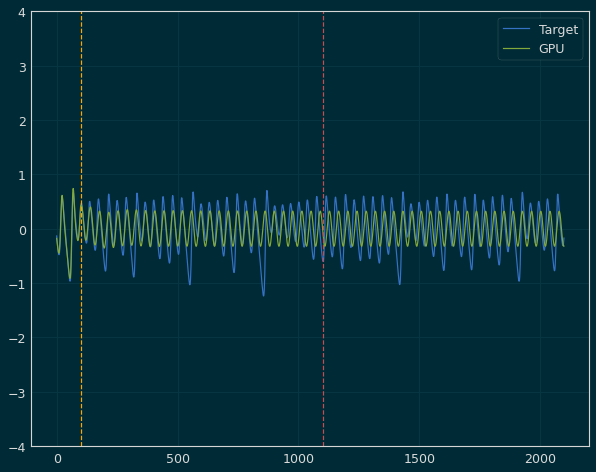

 Iter=38 a=0.032 sr=4.977 amp=0.059  ri=0.764 rr=1.435 loss=0.590106


Iter: 38 #### Diagnostic 0.590106   Time 5.21  Best 0.590 NRMSE 0.148 CD 0.442
Iter: 39 #### Diagnostic 1.079006   Time 4.38  Best 0.590 NRMSE 0.184 CD 0.895
Iter: 40 #### Diagnostic 1.074189   Time 4.15  Best 0.590 NRMSE 0.184 CD 0.890
Iter: 41 #### Diagnostic 1000.000000   Time 4.25  Best 0.590 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000000   Time 5.36  Best 0.590 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1000.000000   Time 4.97  Best 0.590 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1.042189   Time 4.30  Best 0.590 NRMSE 0.225 CD 0.817
Iter: 45 #### Diagnostic 1000.000000   Time 4.76  Best 0.590 NRMSE 1000.000 CD 1.038
Iter: 46 #### Diagnostic 1000.000000   Time 4.23  Best 0.590 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000000   Time 4.93  Best 0.590 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1.031363   Time 4.47  Best 0.590 NRMSE 0.183 CD 0.848
Iter: 49 #### Diagnostic 0.985751 

Iter: 34 #### Diagnostic 1.068378   Time 4.04  Best 1000.000 NRMSE 0.184 CD 0.884
Iter: 35 #### Diagnostic 1000.000000   Time 4.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 0.986244   Time 4.58  Best 1000.000 NRMSE 0.182 CD 0.804
Iter: 37 #### Diagnostic 1000.000000   Time 4.56  Best 1000.000 NRMSE 1000.000 CD 0.998
Iter: 38 #### Diagnostic 1000.000000   Time 4.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1.057583   Time 4.43  Best 1000.000 NRMSE 0.184 CD 0.874
Iter: 40 #### Diagnostic 1000.000000   Time 4.50  Best 1000.000 NRMSE 1000.000 CD 1.002
Iter: 41 #### Diagnostic 1000.000000   Time 4.79  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1.171874   Time 5.47  Best 1000.000 NRMSE 0.193 CD 0.979
Iter: 43 #### Diagnostic 1.539690   Time 5.13  Best 1000.000 NRMSE 0.536 CD 1.004
Iter: 44 #### Diagnostic 1000.000000   Time 5.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 0.996770   Time 4.60  Best 1000.000 NRMSE 0.1

Iter: 22 #### Diagnostic 1000.000000   Time 4.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 4.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 4.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 4.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 4.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 4.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 4.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000000   Time 4.73  Best 1000.000 NRMSE 1000.000 CD 0.972
Iter: 30 #### Diagnostic 0.780536   Time 4.44  Best 1000.000 NRMSE 0.183 CD 0.598
Iter: 31 #### Diagnostic 0.743625   Time 4.25  Best 1000.000 NRMSE 0.183 CD 0.560
Iter: 32 #### Diagnostic 1.092984   Time 4.73  Best 1000.000 NRMSE 0.187 CD 0.906
Iter: 33 #### Diagnostic 1000.000000   Time 4.47  Best 1000.000 

Iter: 17 #### Diagnostic 1.064087   Time 4.14  Best 1000.000 NRMSE 0.184 CD 0.880
Iter: 18 #### Diagnostic 1000.000000   Time 4.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 4.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1.079284   Time 4.55  Best 1000.000 NRMSE 0.184 CD 0.895
Iter: 21 #### Diagnostic 1000.000000   Time 4.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 0.822442   Time 4.55  Best 1000.000 NRMSE 0.175 CD 0.647
Iter: 23 #### Diagnostic 1000.000000   Time 4.80  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 4.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 4.86  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1.541653   Time 4.66  Best 1000.000 NRMSE 0.536 CD 1.006
Iter: 27 #### Diagnostic 1.238605   Time 4.57  Best 1000.000 NRMSE 0.232 CD 1.006
Iter: 28 #### Diagnostic 5.044665   Time 4.24  Best 1000.000 NRMSE 4.066 C

Iter: 12 #### Diagnostic 1000.000000   Time 5.82  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000000   Time 5.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1.194124   Time 5.79  Best 1000.000 NRMSE 0.192 CD 1.002
Iter: 15 #### Diagnostic 1000.000000   Time 5.83  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1.076999   Time 4.01  Best 1000.000 NRMSE 0.184 CD 0.893
Iter: 17 #### Diagnostic 1000.000000   Time 4.29  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000000   Time 4.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 4.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000000   Time 5.73  Best 1000.000 NRMSE 24052063722724940316672.000 CD 0.991
Iter: 21 #### Diagnostic 1.050715   Time 5.34  Best 1000.000 NRMSE 0.184 CD 0.867
Iter: 22 #### Diagnostic 1000.000000   Time 4.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1.154489   Time 4.12

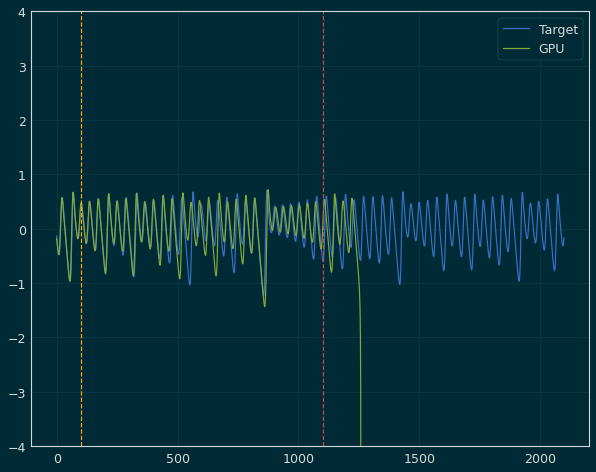

 Iter=24 a=0.277 sr=2.015 amp=0.898  ri=0.835 rr=0.732 loss=0.385538


Iter: 24 #### Diagnostic 0.385538   Time 4.59  Best 0.386 NRMSE 0.127 CD 0.258
Iter: 25 #### Diagnostic 0.708906   Time 5.08  Best 0.386 NRMSE 0.180 CD 0.529
Iter: 26 #### Diagnostic 1000.000000   Time 5.73  Best 0.386 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 5.97  Best 0.386 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 5.91  Best 0.386 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.193594   Time 4.90  Best 0.386 NRMSE 0.214 CD 0.980
Iter: 30 #### Diagnostic 1000.000000   Time 3.95  Best 0.386 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000000   Time 5.02  Best 0.386 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1.190535   Time 4.18  Best 0.386 NRMSE 0.223 CD 0.968
Iter: 33 #### Diagnostic 0.959046   Time 3.93  Best 0.386 NRMSE 0.181 CD 0.778
Iter: 34 #### Diagnostic 1000.000000   Time 4.47  Best 0.386 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000000

Iter: 20 #### Diagnostic 1.065600   Time 4.47  Best 1000.000 NRMSE 0.184 CD 0.881
Iter: 21 #### Diagnostic 1000.000000   Time 4.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 4.37  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 4.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1.276327   Time 4.07  Best 1000.000 NRMSE 0.264 CD 1.012
Iter: 25 #### Diagnostic 1000.000000   Time 4.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 0.672062   Time 4.57  Best 1000.000 NRMSE 0.172 CD 0.500
Iter: 27 #### Diagnostic 1000.000000   Time 4.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 5.87  Best 1000.000 NRMSE 1000.000 CD 0.992
Iter: 29 #### Diagnostic 1.007224   Time 5.76  Best 1000.000 NRMSE 0.183 CD 0.825
Iter: 30 #### Diagnostic 1000.000000   Time 4.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1000.000000   Time 4.81  Best 1000.000 NRMS

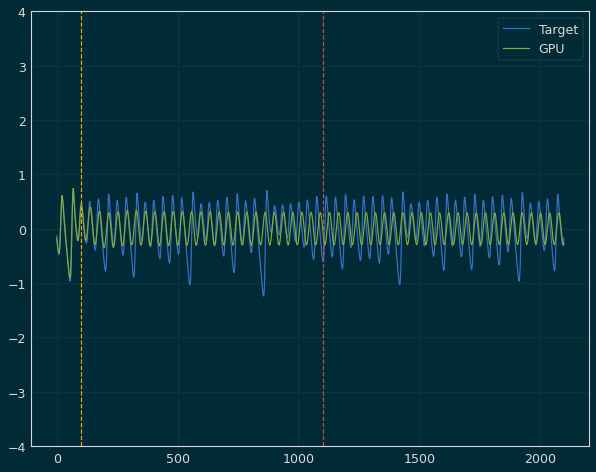

 Iter=38 a=0.032 sr=4.977 amp=0.059  ri=0.764 rr=1.435 loss=0.584722


Iter: 38 #### Diagnostic 0.584722   Time 4.52  Best 0.585 NRMSE 0.147 CD 0.437
Iter: 39 #### Diagnostic 1.079398   Time 4.15  Best 0.585 NRMSE 0.184 CD 0.895
Iter: 40 #### Diagnostic 1.074907   Time 4.15  Best 0.585 NRMSE 0.184 CD 0.891
Iter: 41 #### Diagnostic 1000.000000   Time 5.65  Best 0.585 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1.514052   Time 5.64  Best 0.585 NRMSE 0.519 CD 0.995
Iter: 43 #### Diagnostic 1000.000000   Time 4.97  Best 0.585 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000000   Time 4.48  Best 0.585 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 4.47  Best 0.585 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000000   Time 4.43  Best 0.585 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000000   Time 4.37  Best 0.585 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1.011218   Time 4.07  Best 0.585 NRMSE 0.183 CD 0.829
Iter: 49 #### Diagnostic 0.980090   

Iter: 34 #### Diagnostic 1.076082   Time 4.22  Best 1000.000 NRMSE 0.184 CD 0.892
Iter: 35 #### Diagnostic 1000.000000   Time 6.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 0.996028   Time 4.46  Best 1000.000 NRMSE 0.182 CD 0.814
Iter: 37 #### Diagnostic 1000.000000   Time 4.33  Best 1000.000 NRMSE 1000.000 CD 1.015
Iter: 38 #### Diagnostic 1000.000000   Time 4.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1.044248   Time 4.81  Best 1000.000 NRMSE 0.184 CD 0.861
Iter: 40 #### Diagnostic 1000.000000   Time 4.58  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000000   Time 4.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1.176258   Time 4.85  Best 1000.000 NRMSE 0.196 CD 0.981
Iter: 43 #### Diagnostic 1000.000000   Time 4.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000000   Time 4.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1.037900   Time 4.08  Best 1000.000 NRMSE 0

Iter: 22 #### Diagnostic 0.685489   Time 4.47  Best 1000.000 NRMSE 0.182 CD 0.504
Iter: 23 #### Diagnostic 1000.000000   Time 4.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 0.915001   Time 5.21  Best 1000.000 NRMSE 0.211 CD 0.704
Iter: 25 #### Diagnostic 1000.000000   Time 4.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 5.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 4.74  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 4.41  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000000   Time 4.83  Best 1000.000 NRMSE 1000.000 CD 0.973
Iter: 30 #### Diagnostic 0.660515   Time 4.76  Best 1000.000 NRMSE 0.161 CD 0.500
Iter: 31 #### Diagnostic 1000.000000   Time 5.52  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1.092245   Time 4.74  Best 1000.000 NRMSE 0.187 CD 0.905
Iter: 33 #### Diagnostic 1000.000000   Time 4.53  Best 1000.000 NRMS

Iter: 17 #### Diagnostic 1.066244   Time 4.33  Best 1000.000 NRMSE 0.184 CD 0.882
Iter: 18 #### Diagnostic 1000.000000   Time 4.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 4.72  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1.100432   Time 5.01  Best 1000.000 NRMSE 0.185 CD 0.915
Iter: 21 #### Diagnostic 1000.000000   Time 4.56  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 0.783534   Time 4.81  Best 1000.000 NRMSE 0.175 CD 0.609
Iter: 23 #### Diagnostic 1000.000000   Time 4.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1.537299   Time 4.71  Best 1000.000 NRMSE 0.536 CD 1.001


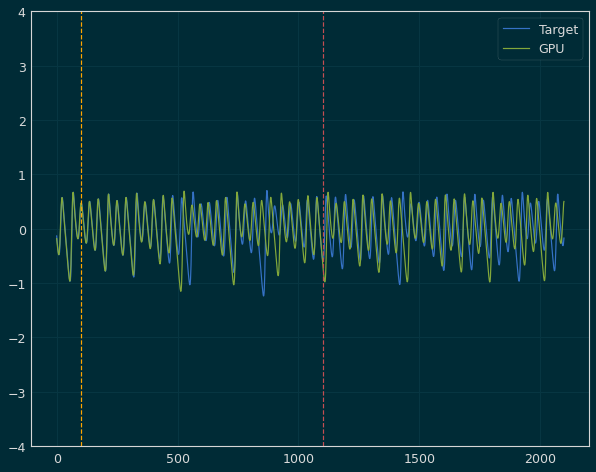

 Iter=25 a=0.712 sr=3.122 amp=0.537  ri=0.439 rr=0.095 loss=0.583582


Iter: 25 #### Diagnostic 0.583582   Time 4.91  Best 0.584 NRMSE 0.157 CD 0.427
Iter: 26 #### Diagnostic 1000.000000   Time 5.28  Best 0.584 NRMSE 1000.000 CD 0.985
Iter: 27 #### Diagnostic 1.227393   Time 4.74  Best 0.584 NRMSE 0.218 CD 1.010
Iter: 28 #### Diagnostic 6.286157   Time 4.25  Best 0.584 NRMSE 5.374 CD 0.913
Iter: 29 #### Diagnostic 1000.000000   Time 5.37  Best 0.584 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 5.70  Best 0.584 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1.116156   Time 4.89  Best 0.584 NRMSE 0.185 CD 0.931
Iter: 32 #### Diagnostic 1.215012   Time 4.19  Best 0.584 NRMSE 0.197 CD 1.018
Iter: 33 #### Diagnostic 1000.000000   Time 4.24  Best 0.584 NRMSE 1000.000 CD 1.081
Iter: 34 #### Diagnostic 1.059132   Time 4.96  Best 0.584 NRMSE 0.184 CD 0.876
Iter: 35 #### Diagnostic 0.990430   Time 4.93  Best 0.584 NRMSE 0.182 CD 0.808
Iter: 36 #### Diagnostic 1000.000000   T

Iter: 22 #### Diagnostic 1000.000000   Time 4.72  Best 1000.000 NRMSE 1000.000 CD 0.991
Iter: 23 #### Diagnostic 1.233720   Time 4.23  Best 1000.000 NRMSE 0.222 CD 1.012
Iter: 24 #### Diagnostic 1000.000000   Time 4.30  Best 1000.000 NRMSE 558318.341 CD 1.005
Iter: 25 #### Diagnostic 0.656809   Time 4.66  Best 1000.000 NRMSE 0.178 CD 0.479
Iter: 26 #### Diagnostic 0.881240   Time 4.59  Best 1000.000 NRMSE 0.209 CD 0.673
Iter: 27 #### Diagnostic 1000.000000   Time 4.53  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 4.46  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.167868   Time 4.67  Best 1000.000 NRMSE 0.201 CD 0.966
Iter: 30 #### Diagnostic 0.636222   Time 5.31  Best 1000.000 NRMSE 0.171 CD 0.466
Iter: 31 #### Diagnostic 1000.000000   Time 4.18  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1.136202   Time 4.06  Best 1000.000 NRMSE 0.206 CD 0.930
Iter: 33 #### Diagnostic 0.949565   Time 4.73  Best 1000.000 NRMSE 0.181

Iter: 16 #### Diagnostic 1000.000000   Time 4.52  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 0.687677   Time 4.68  Best 1000.000 NRMSE 0.181 CD 0.507
Iter: 18 #### Diagnostic 0.983420   Time 4.26  Best 1000.000 NRMSE 0.182 CD 0.802
Iter: 19 #### Diagnostic 1000.000000   Time 4.52  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1.061055   Time 4.26  Best 1000.000 NRMSE 0.184 CD 0.877
Iter: 21 #### Diagnostic 1000.000000   Time 4.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 0.760041   Time 4.44  Best 1000.000 NRMSE 0.194 CD 0.566
Iter: 23 #### Diagnostic 1000.000000   Time 4.37  Best 1000.000 NRMSE 1000.000 CD 1.002
Iter: 24 #### Diagnostic 1000.000000   Time 4.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1.481152   Time 4.35  Best 1000.000 NRMSE 0.477 CD 1.004
Iter: 26 #### Diagnostic 1000.000000   Time 4.70  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 5.20  Best 1000.000 NRMSE 10

Iter: 11 #### Diagnostic 1.166933   Time 4.32  Best 1000.000 NRMSE 0.193 CD 0.974
Iter: 12 #### Diagnostic 1000.000000   Time 4.49  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000000   Time 4.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000000   Time 4.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 4.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 4.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 4.30  Best 1000.000 NRMSE 1000.000 CD 0.991
Iter: 18 #### Diagnostic 1000.000000   Time 4.59  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 4.30  Best 1000.000 NRMSE 33229.607 CD 1.005
Iter: 20 #### Diagnostic 1000.000000   Time 4.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1000.000000   Time 4.14  Best 1000.000 NRMSE 1000.000 CD 1.001
Iter: 22 #### Diagnostic 1000.000000   Time 5.85  B

Iter: 0 #### Diagnostic 1.508724   Time 4.03  Best 1000.000 NRMSE 0.508 CD 1.001
Iter: 1 #### Diagnostic 1000.000000   Time 4.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 4.75  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 4.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1.008872   Time 4.74  Best 1000.000 NRMSE 0.182 CD 0.827
Iter: 5 #### Diagnostic 1000.000000   Time 4.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000000   Time 4.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 4.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 0.789496   Time 4.20  Best 1000.000 NRMSE 0.172 CD 0.618
Iter: 9 #### Diagnostic 1000.000000   Time 4.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 4.06  Best 1000.000 NRMSE 1000.000 CD 1.002
Iter: 11 #### Diagnostic 1000.000000   Time 4.57  Best 1000.000 NRMSE 5785

Iter: 97 #### Diagnostic 1000.000000   Time 5.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1.066932   Time 5.73  Best 1000.000 NRMSE 0.184 CD 0.883
Iter: 99 #### Diagnostic 1.209757   Time 5.93  Best 1000.000 NRMSE 0.228 CD 0.982

Best result = 0.7800836638370418
a = 0.553968284790046
sr = 3.020500917015245
amp = 0.4648572594291303
ri = 0.9555820730468593
rr = 3.6815484738016866
********** Size 200 -- Run 1 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 3.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000000   Time 4.08  Best 1000.000 NRMSE 1000.000 CD 0.992
Iter: 2 #### Diagnostic 1.071925   Time 4.45  Best 1000.000 NRMSE 0.184 CD 0.888
Iter: 3 #### Diagnostic 1000.000000   Time 4.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 4.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 4.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000000   Time 5.13  

Iter: 91 #### Diagnostic 1.510877   Time 5.90  Best 1000.000 NRMSE 0.522 CD 0.989
Iter: 92 #### Diagnostic 1.103807   Time 5.75  Best 1000.000 NRMSE 0.185 CD 0.919
Iter: 93 #### Diagnostic 1000.000000   Time 5.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1.266893   Time 5.95  Best 1000.000 NRMSE 0.196 CD 1.071
Iter: 95 #### Diagnostic 1000.000000   Time 6.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000000   Time 5.50  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 0.818185   Time 5.65  Best 1000.000 NRMSE 0.173 CD 0.646
Iter: 98 #### Diagnostic 1000.000000   Time 5.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1000.000000   Time 4.68  Best 1000.000 NRMSE 1000.000 CD nan

Best result = 0.7118228486139027
a = 0.7119448375249606
sr = 3.121749603781045
amp = 0.5374354805675614
ri = 0.43939816582062674
rr = 0.09532868262854027
********** Size 200 -- Run 2 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 4.5

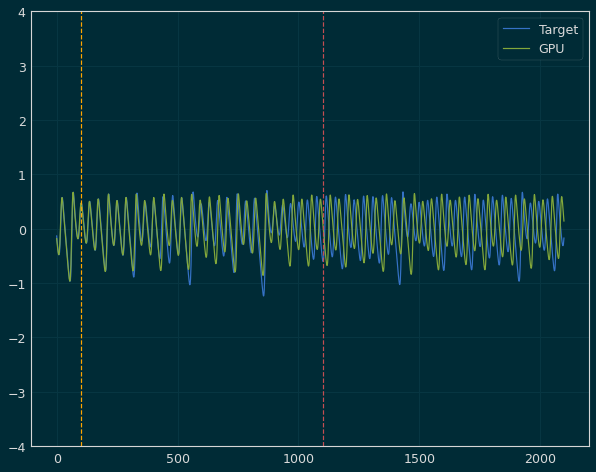

 Iter=18 a=0.881 sr=6.405 amp=0.351  ri=0.773 rr=4.483 loss=0.535696


Iter: 18 #### Diagnostic 0.535696   Time 4.31  Best 0.536 NRMSE 0.163 CD 0.373
Iter: 19 #### Diagnostic 1000.000000   Time 4.27  Best 0.536 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000000   Time 5.08  Best 0.536 NRMSE 2744536507915945772006244352.000 CD 1.102
Iter: 21 #### Diagnostic 1.146751   Time 5.48  Best 0.536 NRMSE 0.201 CD 0.945
Iter: 22 #### Diagnostic 1000.000000   Time 5.60  Best 0.536 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1.133070   Time 5.77  Best 0.536 NRMSE 0.216 CD 0.917
Iter: 24 #### Diagnostic 0.704970   Time 5.76  Best 0.536 NRMSE 0.187 CD 0.518
Iter: 25 #### Diagnostic 6.006716   Time 4.89  Best 0.536 NRMSE 4.944 CD 1.062
Iter: 26 #### Diagnostic 1000.000000   Time 4.16  Best 0.536 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 4.51  Best 0.536 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 4.18  Best 0.536 NRMSE 1000.000 CD nan
Iter: 29 #

Iter: 15 #### Diagnostic 1000.000000   Time 4.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 4.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 4.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 0.970150   Time 4.21  Best 1000.000 NRMSE 0.181 CD 0.789
Iter: 19 #### Diagnostic 1000.000000   Time 4.31  Best 1000.000 NRMSE 1000.000 CD 1.071
Iter: 20 #### Diagnostic 1.068319   Time 5.15  Best 1000.000 NRMSE 0.184 CD 0.884
Iter: 21 #### Diagnostic 1000.000000   Time 4.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 1000.000000   Time 4.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 4.13  Best 1000.000 NRMSE 1000.000 CD 0.990
Iter: 24 #### Diagnostic 1000.000000   Time 4.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1.543917   Time 4.07  Best 1000.000 NRMSE 0.536 CD 1.008
Iter: 26 #### Diagnostic 1000.000000   Time 4.42  Best 1000.00

Iter: 10 #### Diagnostic 1000.000000   Time 4.57  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1.143584   Time 4.07  Best 1000.000 NRMSE 0.186 CD 0.958
Iter: 12 #### Diagnostic 1.543554   Time 4.30  Best 1000.000 NRMSE 0.536 CD 1.008
Iter: 13 #### Diagnostic 1000.000000   Time 4.85  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1.262717   Time 4.09  Best 1000.000 NRMSE 0.247 CD 1.016
Iter: 15 #### Diagnostic 1000.000000   Time 4.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1000.000000   Time 4.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 4.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000000   Time 4.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 4.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000000   Time 4.25  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1.490508   Time 4.01  Best 1000.000 NRMSE

Iter: 0 #### Diagnostic 1.428588   Time 4.22  Best 1000.000 NRMSE 0.401 CD 1.027
Iter: 1 #### Diagnostic 1000.000000   Time 4.32  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 4.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 4.28  Best 1000.000 NRMSE 1000.000 CD 1.001
Iter: 4 #### Diagnostic 1.023422   Time 4.05  Best 1000.000 NRMSE 0.183 CD 0.841
Iter: 5 #### Diagnostic 1000.000000   Time 4.53  Best 1000.000 NRMSE 1000.000 CD 0.998
Iter: 6 #### Diagnostic 1000.000000   Time 4.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 4.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 0.788196   Time 4.30  Best 1000.000 NRMSE 0.172 CD 0.616
Iter: 9 #### Diagnostic 1000.000000   Time 4.33  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 4.09  Best 1000.000 NRMSE 1000.000 CD 0.982
Iter: 11 #### Diagnostic 1000.000000   Time 4.04  Best 1000.000 NRMSE 

Iter: 97 #### Diagnostic 1000.000000   Time 4.16  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1.053519   Time 4.25  Best 1000.000 NRMSE 0.184 CD 0.870
Iter: 99 #### Diagnostic 1.208599   Time 5.02  Best 1000.000 NRMSE 0.227 CD 0.982

Best result = 0.6913727827474595
a = 0.03714899719480398
sr = 2.8805199282091567
amp = 0.07049883500355729
ri = 0.7238811678690714
rr = 0.17771174677320598
********** Size 200 -- Run 1 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 4.26  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000000   Time 4.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1.071474   Time 5.47  Best 1000.000 NRMSE 0.184 CD 0.887
Iter: 3 #### Diagnostic 1000.000000   Time 5.55  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 5.57  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 5.96  Best 1000.000 NRMSE 1000.000 CD 1.001
Iter: 6 #### Diagnostic 1000.000000   Time 5

Iter: 92 #### Diagnostic 1.105099   Time 4.64  Best 1000.000 NRMSE 0.185 CD 0.920
Iter: 93 #### Diagnostic 1000.000000   Time 4.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1.263545   Time 4.18  Best 1000.000 NRMSE 0.195 CD 1.068
Iter: 95 #### Diagnostic 1000.000000   Time 4.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000000   Time 4.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 0.650733   Time 4.19  Best 1000.000 NRMSE 0.155 CD 0.496
Iter: 98 #### Diagnostic 1000.000000   Time 4.18  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1000.000000   Time 4.28  Best 1000.000 NRMSE 1000.000 CD nan

Best result = 0.6101970896172272
a = 0.6922579433926206
sr = 5.436926378278631
amp = 0.23836077133509745
ri = 0.5350706250458971
rr = 2.708519922005769
********** Size 200 -- Run 2 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 4.38  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1.296339   Time 4.24 

Iter: 87 #### Diagnostic 1000.000000   Time 4.15  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000000   Time 4.32  Best 1000.000 NRMSE 262748081552.809 CD 1.012
Iter: 89 #### Diagnostic 1000.000000   Time 4.66  Best 1000.000 NRMSE 1000.000 CD 1.000
Iter: 90 #### Diagnostic 1000.000000   Time 4.68  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000000   Time 5.64  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000000   Time 4.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000000   Time 4.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1000.000000   Time 4.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 1000.000000   Time 5.31  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000000   Time 4.42  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000000   Time 5.48  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1000.000000   Tim

Iter: 81 #### Diagnostic 0.685602   Time 4.63  Best 1000.000 NRMSE 0.173 CD 0.512
Iter: 82 #### Diagnostic 1.064712   Time 4.61  Best 1000.000 NRMSE 0.184 CD 0.881
Iter: 83 #### Diagnostic 1000.000000   Time 5.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1000.000000   Time 4.35  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1000.000000   Time 4.45  Best 1000.000 NRMSE 1000.000 CD 1.000
Iter: 86 #### Diagnostic 1000.000000   Time 5.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 0.996417   Time 5.09  Best 1000.000 NRMSE 0.182 CD 0.814
Iter: 88 #### Diagnostic 1000.000000   Time 4.34  Best 1000.000 NRMSE 1000.000 CD 0.990
Iter: 89 #### Diagnostic 1.051254   Time 4.52  Best 1000.000 NRMSE 0.184 CD 0.867
Iter: 90 #### Diagnostic 1.528684   Time 4.41  Best 1000.000 NRMSE 0.528 CD 1.001
Iter: 91 #### Diagnostic 1.170473   Time 4.34  Best 1000.000 NRMSE 0.187 CD 0.984
Iter: 92 #### Diagnostic 1.023352   Time 4.53  Best 1000.000 NRMSE 0.183 C

Iter: 75 #### Diagnostic 1000.000000   Time 4.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1.544045   Time 4.51  Best 1000.000 NRMSE 0.536 CD 1.008
Iter: 77 #### Diagnostic 1.165549   Time 4.23  Best 1000.000 NRMSE 0.190 CD 0.976
Iter: 78 #### Diagnostic 1000.000000   Time 4.39  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 0.762499   Time 5.42  Best 1000.000 NRMSE 0.198 CD 0.564
Iter: 80 #### Diagnostic 1.072319   Time 5.36  Best 1000.000 NRMSE 0.184 CD 0.889
Iter: 81 #### Diagnostic 1000.000000   Time 4.54  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1000.000000   Time 4.45  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1000.000000   Time 4.34  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1.101884   Time 4.41  Best 1000.000 NRMSE 0.185 CD 0.917
Iter: 85 #### Diagnostic 1000.000000   Time 4.63  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1.535801   Time 4.46  Best 1000.000 NRMSE 0.536 C

Iter: 67 #### Diagnostic 1000.000000   Time 4.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 0.897918   Time 4.04  Best 1000.000 NRMSE 0.179 CD 0.719
Iter: 69 #### Diagnostic 1.061855   Time 4.03  Best 1000.000 NRMSE 0.184 CD 0.878
Iter: 70 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000000   Time 4.93  Best 1000.000 NRMSE 26499214742886524.000 CD 0.991
Iter: 72 #### Diagnostic 1000.000000   Time 4.43  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000000   Time 4.40  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000000   Time 4.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 0.977925   Time 4.45  Best 1000.000 NRMSE 0.182 CD 0.796
Iter: 76 #### Diagnostic 1000.000000   Time 4.36  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1.054724   Time 4.11  Best 1000.000 NRMSE 0.184 CD 0.871
Iter: 78 #### Diagnostic 1.069163   Time 4.28  Best 100

Iter: 62 #### Diagnostic 1000.000000   Time 4.23  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1.044769   Time 4.08  Best 1000.000 NRMSE 0.183 CD 0.861
Iter: 64 #### Diagnostic 1000.000000   Time 3.95  Best 1000.000 NRMSE 11361461251946010624.000 CD 1.000
Iter: 65 #### Diagnostic 1000.000000   Time 4.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000000   Time 4.16  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 4.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 3.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000000   Time 4.81  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000000   Time 5.39  Best 1000.000 NRMSE 1000.000 CD 1.001
Iter: 71 #### Diagnostic 1000.000000   Time 5.51  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000000   Time 4.11  Best 1000.000 NRMSE 6541865699060724269056.000 CD 1.009
Iter: 73 #### Diag

Iter: 56 #### Diagnostic 1.174252   Time 4.21  Best 1000.000 NRMSE 0.218 CD 0.956
Iter: 57 #### Diagnostic 1000.000000   Time 4.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 4.09  Best 1000.000 NRMSE 1568628251446269956940722997506867200.000 CD 1.000
Iter: 59 #### Diagnostic 1.054482   Time 3.95  Best 1000.000 NRMSE 0.184 CD 0.871
Iter: 60 #### Diagnostic 1000.000000   Time 3.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 3.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 3.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1.054325   Time 3.84  Best 1000.000 NRMSE 0.183 CD 0.871
Iter: 64 #### Diagnostic 1000.000000   Time 3.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000000   Time 3.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1.094592   Time 3.91  Best 1000.000 NRMSE 0.252 CD 0.842
Iter: 67 #### Diagnostic 0.920880  

Iter: 51 #### Diagnostic 1000.000000   Time 3.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000000   Time 3.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000000   Time 3.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000000   Time 4.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000000   Time 3.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 0.939161   Time 4.08  Best 1000.000 NRMSE 0.179 CD 0.761
Iter: 57 #### Diagnostic 1.176610   Time 3.96  Best 1000.000 NRMSE 0.187 CD 0.989
Iter: 58 #### Diagnostic 1000.000000   Time 3.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000000   Time 3.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1.502726   Time 3.88  Best 1000.000 NRMSE 0.516 CD 0.986
Iter: 61 #### Diagnostic 1000.000000   Time 3.99  Best 1000.000 NRMSE 1000.000 CD 1.009
Iter: 62 #### Diagnostic 1.149512   Time 3.90  Best 1000.000 NRM

Iter: 45 #### Diagnostic 1.057324   Time 5.07  Best 1000.000 NRMSE 0.184 CD 0.873
Iter: 46 #### Diagnostic 1.146992   Time 4.36  Best 1000.000 NRMSE 0.220 CD 0.927
Iter: 47 #### Diagnostic 1.064907   Time 4.09  Best 1000.000 NRMSE 0.184 CD 0.881
Iter: 48 #### Diagnostic 1000.000000   Time 3.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1.065937   Time 3.97  Best 1000.000 NRMSE 0.184 CD 0.882
Iter: 50 #### Diagnostic 1.209914   Time 4.57  Best 1000.000 NRMSE 0.190 CD 1.020
Iter: 51 #### Diagnostic 1.145636   Time 4.58  Best 1000.000 NRMSE 0.190 CD 0.956
Iter: 52 #### Diagnostic 1.423218   Time 3.88  Best 1000.000 NRMSE 0.292 CD 1.131
Iter: 53 #### Diagnostic 1000.000000   Time 4.24  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1.496393   Time 4.47  Best 1000.000 NRMSE 0.282 CD 1.215
Iter: 55 #### Diagnostic 1000.000000   Time 4.60  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000000   Time 3.93  Best 1000.000 NRMSE 1000.000 CD nan


Iter: 38 #### Diagnostic 0.918370   Time 3.91  Best 1000.000 NRMSE 0.210 CD 0.708
Iter: 39 #### Diagnostic 1.359072   Time 3.93  Best 1000.000 NRMSE 0.355 CD 1.004
Iter: 40 #### Diagnostic 1.097694   Time 3.99  Best 1000.000 NRMSE 0.185 CD 0.913
Iter: 41 #### Diagnostic 1.097280   Time 4.24  Best 1000.000 NRMSE 0.185 CD 0.913
Iter: 42 #### Diagnostic 1.077749   Time 4.09  Best 1000.000 NRMSE 0.184 CD 0.893
Iter: 43 #### Diagnostic 1000.000000   Time 4.21  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000000   Time 4.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 0.731231   Time 4.14  Best 1000.000 NRMSE 0.187 CD 0.544
Iter: 46 #### Diagnostic 1000.000000   Time 4.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000000   Time 4.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1000.000000   Time 4.08  Best 1000.000 NRMSE 1000.000

Iter: 33 #### Diagnostic 1000.000000   Time 4.12  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1.001296   Time 4.00  Best 1000.000 NRMSE 0.182 CD 0.819
Iter: 35 #### Diagnostic 1.037069   Time 3.89  Best 1000.000 NRMSE 0.183 CD 0.854
Iter: 36 #### Diagnostic 0.841723   Time 3.87  Best 1000.000 NRMSE 0.234 CD 0.608
Iter: 37 #### Diagnostic 1000.000000   Time 3.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 38 #### Diagnostic 1000.000000   Time 4.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1000.000000   Time 4.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 1000.000000   Time 4.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000000   Time 4.30  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1.097322   Time 5.48  Best 1000.000 NRMSE 0.185 CD 0.913
Iter: 43 #### Diagnostic 0.740932   Time 4.91  Best 1000.000 NRMSE 0.192 CD 0.549
Iter: 44 #### Diagnostic 1.113395   Time 4.20  Best 1000.000 NRMSE 0.185 C

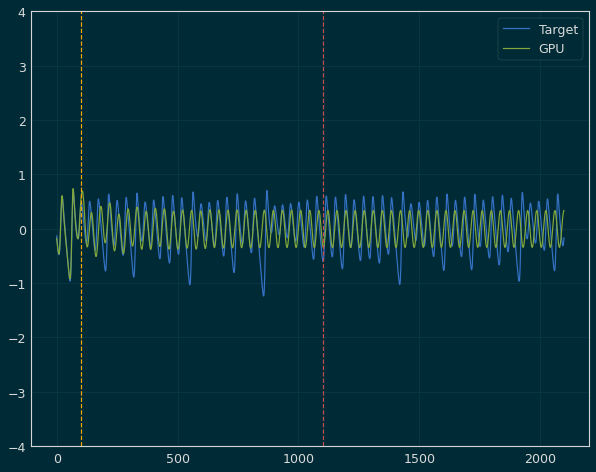

 Iter=97 a=0.033 sr=2.272 amp=0.417  ri=0.210 rr=4.437 loss=0.594418


Iter: 97 #### Diagnostic 0.594418   Time 4.36  Best 0.594 NRMSE 0.151 CD 0.444
Iter: 98 #### Diagnostic 1000.000000   Time 3.99  Best 0.594 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1000.000000   Time 4.03  Best 0.594 NRMSE 1000.000 CD nan

Best result = 0.594417679024008
a = 0.03296368901436439
sr = 2.2718190151653133
amp = 0.41706003360837945
ri = 0.21004232789289917
rr = 4.437127441822249
********** Size 100 -- Run 2 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 4.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1.299946   Time 3.97  Best 1000.000 NRMSE 0.195 CD 1.104
Iter: 2 #### Diagnostic 1000.000000   Time 4.07  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 3.91  Best 1000.000 NRMS

Iter: 91 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000000   Time 3.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 1000.000000   Time 3.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 1000.000000   Time 3.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 95 #### Diagnostic 0.754959   Time 4.08  Best 1000.000 NRMSE 0.190 CD 0.565
Iter: 96 #### Diagnostic 1000.000000   Time 4.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000000   Time 4.20  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1000.000000   Time 3.95  Best 1000.000 NRMSE 1000.000 CD 1.001
Iter: 99 #### Diagnostic 1000.000000   Time 3.91  Best 1000.000 NRMSE 1000.000 CD nan

Best result = 0.7549593295254633
a = 0.8089033257869287
sr = 1.9855280033588256
amp = 0.9095920405692465
ri = 0.517602624142771
rr = 2.603362162998719
********** Size 100 -- Run 3 ***********
Iter: 0 #### Diagnostic 1.215638   

Iter: 86 #### Diagnostic 1000.000000   Time 3.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1.047970   Time 3.93  Best 1000.000 NRMSE 0.183 CD 0.865
Iter: 88 #### Diagnostic 1000.000000   Time 4.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1.058998   Time 3.97  Best 1000.000 NRMSE 0.184 CD 0.875
Iter: 90 #### Diagnostic 1000.000000   Time 3.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1.167718   Time 3.93  Best 1000.000 NRMSE 0.187 CD 0.981
Iter: 92 #### Diagnostic 1.087299   Time 3.98  Best 1000.000 NRMSE 0.185 CD 0.903
Iter: 93 #### Diagnostic 1000.000000   Time 3.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 94 #### Diagnostic 0.738916   Time 3.94  Best 1000.000 NRMSE 0.192 CD 0.547
Iter: 95 #### Diagnostic 1.238382   Time 3.93  Best 1000.000 NRMSE 0.216 CD 1.023
Iter: 96 #### Diagnostic 1000.000000   Time 3.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000000   Time 4.02  Best 1000.000 NRMSE 1000.000

Iter: 81 #### Diagnostic 1000.000000   Time 4.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 82 #### Diagnostic 1000.000000   Time 3.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 83 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1.188987   Time 3.91  Best 1000.000 NRMSE 0.209 CD 0.980
Iter: 85 #### Diagnostic 1000.000000   Time 4.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 86 #### Diagnostic 1000.000000   Time 3.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1.537299   Time 3.95  Best 1000.000 NRMSE 0.536 CD 1.001
Iter: 88 #### Diagnostic 1000.000000   Time 3.92  Best 1000.000 NRMSE 880151163115713499936157893394432.000 CD 1.000
Iter: 89 #### Diagnostic 1000.000000   Time 4.13  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1000.000000   Time 3.95  Best 1000.000 NRMSE 1000.000 CD 1.000
Iter: 91 #### Diagnostic 0.759265   Time 3.95  Best 1000.000 NRMSE 0.192 CD 0.568
Iter: 92 #### Diagnostic 0.642555

Iter: 69 #### Diagnostic 1.030839   Time 3.96  Best 1000.000 NRMSE 0.183 CD 0.848
Iter: 70 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000000   Time 3.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000000   Time 3.98  Best 1000.000 NRMSE 220503767436329315767844601856.000 CD 1.005
Iter: 73 #### Diagnostic 1000.000000   Time 4.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000000   Time 4.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1.063624   Time 3.95  Best 1000.000 NRMSE 0.184 CD 0.879
Iter: 76 #### Diagnostic 1000.000000   Time 3.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 77 #### Diagnostic 1.058679   Time 3.95  Best 1000.000 NRMSE 0.184 CD 0.875
Iter: 78 #### Diagnostic 1.077502   Time 4.14  Best 1000.000 NRMSE 0.184 CD 0.893
Iter: 79 #### Diagnostic 1000.000000   Time 3.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1000.000000   Tim

Iter: 64 #### Diagnostic 0.842978   Time 4.03  Best 1000.000 NRMSE 0.207 CD 0.636
Iter: 65 #### Diagnostic 1000.000000   Time 4.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 4.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 3.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1000.000000   Time 4.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000000   Time 4.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000000   Time 4.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000000   Time 4.19  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000000   Time 3.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1.528096   Time 3.94  Best 1000.000 NRMSE 0.528 CD 1.000
Iter: 75 #### Diagnostic 1000.000000   Time 4.07  Best 1000.00

Iter: 58 #### Diagnostic 1000.000000   Time 4.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1.053943   Time 4.04  Best 1000.000 NRMSE 0.184 CD 0.870
Iter: 60 #### Diagnostic 1000.000000   Time 3.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 4.14  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 3.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1.000162   Time 3.95  Best 1000.000 NRMSE 0.182 CD 0.818
Iter: 64 #### Diagnostic 1000.000000   Time 4.11  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000000   Time 4.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 66 #### Diagnostic 1.201748   Time 3.98  Best 1000.000 NRMSE 0.240 CD 0.962
Iter: 67 #### Diagnostic 0.996854   Time 3.94  Best 1000.000 NRMSE 0.182 CD 0.815
Iter: 68 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 69 #### Diagnostic 1.006830   Time 3.96  Best 1000.000 NRMSE 0.1

Iter: 52 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000000   Time 3.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000000   Time 4.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 0.837609   Time 3.97  Best 1000.000 NRMSE 0.174 CD 0.663
Iter: 57 #### Diagnostic 1.191148   Time 3.96  Best 1000.000 NRMSE 0.188 CD 1.004
Iter: 58 #### Diagnostic 1000.000000   Time 3.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000000   Time 4.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000000   Time 4.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 3.98  Best 1000.000 NRMSE 1000.000 CD 0.901
Iter: 62 #### Diagnostic 1.159808   Time 4.01  Best 1000.000 NRMSE 0.187 CD 0.973
Iter: 63 #### Diagnostic 1000.000000   Time 4.02  Best 1000.000 

Iter: 47 #### Diagnostic 1.157301   Time 3.97  Best 1000.000 NRMSE 0.192 CD 0.966
Iter: 48 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1.062352   Time 4.00  Best 1000.000 NRMSE 0.184 CD 0.879
Iter: 50 #### Diagnostic 1.180620   Time 4.02  Best 1000.000 NRMSE 0.188 CD 0.992
Iter: 51 #### Diagnostic 1.139072   Time 3.99  Best 1000.000 NRMSE 0.190 CD 0.949
Iter: 52 #### Diagnostic 1.415761   Time 4.02  Best 1000.000 NRMSE 0.292 CD 1.124
Iter: 53 #### Diagnostic 1.103744   Time 3.97  Best 1000.000 NRMSE 0.196 CD 0.908
Iter: 54 #### Diagnostic 1.218561   Time 4.03  Best 1000.000 NRMSE 0.220 CD 0.999
Iter: 55 #### Diagnostic 1000.000000   Time 3.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000000   Time 3.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1.079202   Time 3.98  Best 1000.000 NRMSE 0.184 CD 0.895


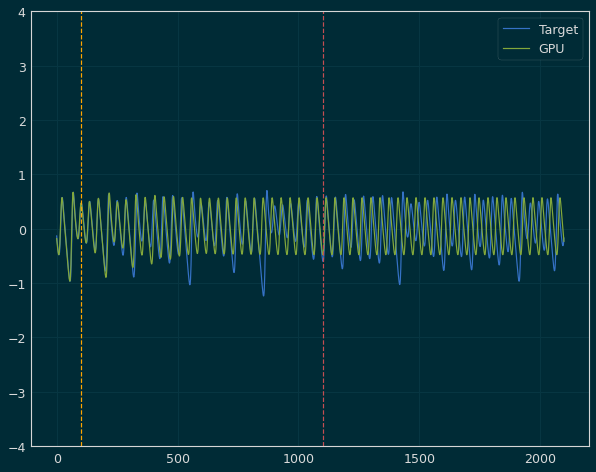

 Iter=22 a=0.434 sr=4.189 amp=0.306  ri=0.924 rr=3.764 loss=0.489295


Iter: 22 #### Diagnostic 0.489295   Time 4.29  Best 0.489 NRMSE 0.142 CD 0.347
Iter: 23 #### Diagnostic 1000.000000   Time 4.00  Best 0.489 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 4.01  Best 0.489 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 3.96  Best 0.489 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 3.92  Best 0.489 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 3.96  Best 0.489 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 3.94  Best 0.489 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000000   Time 3.98  Best 0.489 NRMSE 1000.000 CD 0.981
Iter: 30 #### Diagnostic 0.791374   Time 3.91  Best 0.489 NRMSE 0.183 CD 0.608
Iter: 31 #### Diagnostic 0.810555   Time 3.97  Best 0.489 NRMSE 0.201 CD 0.610
Iter: 32 #### Diagnostic 1.104352   Time 3.97  Best 0.489 NRMSE 0.188 CD 0.916
Iter: 33 #### Diagnostic 1.181

Iter: 19 #### Diagnostic 1000.000000   Time 4.27  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1.127457   Time 3.93  Best 1000.000 NRMSE 0.186 CD 0.942
Iter: 21 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 0.852118   Time 3.90  Best 1000.000 NRMSE 0.178 CD 0.675
Iter: 23 #### Diagnostic 1000.000000   Time 3.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 3.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 0.717292   Time 3.90  Best 1000.000 NRMSE 0.185 CD 0.532
Iter: 26 #### Diagnostic 0.935937   Time 3.95  Best 1000.000 NRMSE 0.218 CD 0.718
Iter: 27 #### Diagnostic 1.229918   Time 3.90  Best 1000.000 NRMSE 0.211 CD 1.019
Iter: 28 #### Diagnostic 1000.000000   Time 3.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000000   Time 3.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 30 #### Diagnostic 1000.000000   Time 3.95  Best 1000.000 NRMSE 1000

Iter: 14 #### Diagnostic 1.140265   Time 3.96  Best 1000.000 NRMSE 0.195 CD 0.945
Iter: 15 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 16 #### Diagnostic 1.104984   Time 4.02  Best 1000.000 NRMSE 0.185 CD 0.920
Iter: 17 #### Diagnostic 1000.000000   Time 3.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1.545698   Time 3.99  Best 1000.000 NRMSE 0.536 CD 1.010
Iter: 19 #### Diagnostic 1.644969   Time 4.45  Best 1000.000 NRMSE 0.295 CD 1.350
Iter: 20 #### Diagnostic 0.707814   Time 3.97  Best 1000.000 NRMSE 0.184 CD 0.524
Iter: 21 #### Diagnostic 1.048455   Time 3.97  Best 1000.000 NRMSE 0.184 CD 0.865
Iter: 22 #### Diagnostic 1000.000000   Time 4.08  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1.292305   Time 4.02  Best 1000.000 NRMSE 0.223 CD 1.070
Iter: 24 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 892103607.181 CD 1.001
Iter: 25 #### Diagnostic 1000.000000   Time 3.92  Best 1000.000 NRMSE 1000.

Iter: 9 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1.146574   Time 3.91  Best 1000.000 NRMSE 0.209 CD 0.938
Iter: 11 #### Diagnostic 1000.000000   Time 3.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000000   Time 3.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000000   Time 3.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000000   Time 3.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 0.698626   Time 3.95  Best 1000.000 NRMSE 0.184 CD 0.514
Iter: 16 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1000.000000   Time 3.95  Best 1000.000 NRMSE 100423464.285 CD 1.004
Iter: 18 #### Diagnostic 0.966840   Time 3.88  Best 1000.000 NRMSE 0.181 CD 0.786
Iter: 19 #### Diagnostic 1000.000000   Time 3.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1.070595   Time 3.94  Best 1000.000

Iter: 4 #### Diagnostic 1000.000000   Time 3.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000000   Time 4.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 3.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 0.991546   Time 3.96  Best 1000.000 NRMSE 0.182 CD 0.809
Iter: 9 #### Diagnostic 1000.000000   Time 3.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 3.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1.129113   Time 3.95  Best 1000.000 NRMSE 0.189 CD 0.940
Iter: 12 #### Diagnostic 1000.000000   Time 3.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000000   Time 4.03  Best 1000.000 NRMSE 2635182648.844 CD 1.000
Iter: 14 #### Diagnostic 1000.000000   Time 3.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 15 #### Diagnostic 1000.000000   Time 3.97  Best 1000.

Iter: 0 #### Diagnostic 1000.000000   Time 4.00  Best 1000.000 NRMSE 26383439707358789298601418817536.000 CD 1.045
Iter: 1 #### Diagnostic 1000.000000   Time 3.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1000.000000   Time 4.00  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 3 #### Diagnostic 1000.000000   Time 3.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1.039546   Time 4.01  Best 1000.000 NRMSE 0.183 CD 0.857
Iter: 5 #### Diagnostic 1000.000000   Time 4.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 0.634352   Time 3.98  Best 1000.000 NRMSE 0.169 CD 0.465
Iter: 7 #### Diagnostic 1000.000000   Time 3.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 8 #### Diagnostic 0.907965   Time 3.99  Best 1000.000 NRMSE 0.181 CD 0.727
Iter: 9 #### Diagnostic 1000.000000   Time 3.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 1000.000 CD 1.008
Iter: 11 #### Diagnostic 1000.000000   Time 

Iter: 96 #### Diagnostic 1000.000000   Time 3.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1.221801   Time 3.93  Best 1000.000 NRMSE 0.208 CD 1.014
Iter: 99 #### Diagnostic 1.209633   Time 3.95  Best 1000.000 NRMSE 0.228 CD 0.982

Best result = 0.6343523349342644
a = 0.6216608769903409
sr = 3.540337471798625
amp = 0.8977654131610842
ri = 0.07002371401214173
rr = 2.5326205135029767
********** Size 100 -- Run 1 ***********
Iter: 0 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 1 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1.044674   Time 3.87  Best 1000.000 NRMSE 0.183 CD 0.861
Iter: 3 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 3.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 3.96 

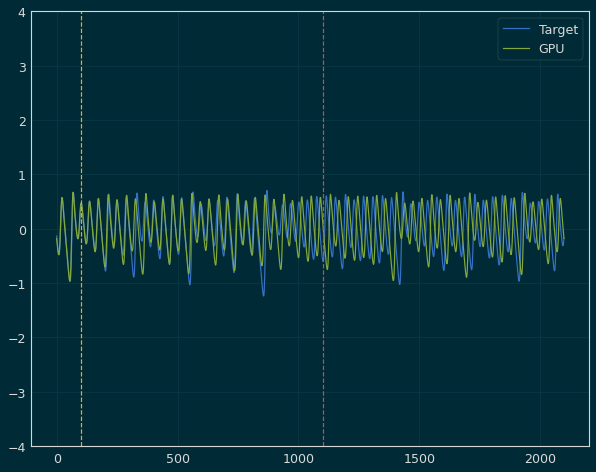

 Iter=54 a=0.460 sr=3.909 amp=0.424  ri=0.677 rr=0.258 loss=0.588919


Iter: 54 #### Diagnostic 0.588919   Time 4.33  Best 0.589 NRMSE 0.168 CD 0.421
Iter: 55 #### Diagnostic 1000.000000   Time 4.08  Best 0.589 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000000   Time 4.06  Best 0.589 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1.105415   Time 3.92  Best 0.589 NRMSE 0.185 CD 0.921
Iter: 58 #### Diagnostic 1000.000000   Time 4.03  Best 0.589 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1000.000000   Time 3.96  Best 0.589 NRMSE 1000.000 CD 0.998
Iter: 60 #### Diagnostic 1000.000000   Time 3.96  Best 0.589 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 3.94  Best 0.589 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1.519308   Time 3.99  Best 0.589 NRMSE 0.508 CD 1.011
Iter: 63 #### Diagnostic 1.094723   Time 3.99  Best 0.589 NRMSE 0.186 CD 0.909
Iter: 64 #### Diagnostic 1000.000000   Time 3.95  Best 0.589 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.

Iter: 49 #### Diagnostic 1.063064   Time 3.92  Best 1000.000 NRMSE 0.183 CD 0.880
Iter: 50 #### Diagnostic 1000.000000   Time 3.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000000   Time 4.00  Best 1000.000 NRMSE 5901827446016530432.000 CD 1.082
Iter: 52 #### Diagnostic 1000.000000   Time 3.95  Best 1000.000 NRMSE 1000.000 CD 0.998
Iter: 53 #### Diagnostic 1.005551   Time 3.89  Best 1000.000 NRMSE 0.182 CD 0.824
Iter: 54 #### Diagnostic 1.111380   Time 4.07  Best 1000.000 NRMSE 0.185 CD 0.926
Iter: 55 #### Diagnostic 1.059395   Time 4.21  Best 1000.000 NRMSE 0.183 CD 0.876
Iter: 56 #### Diagnostic 1000.000000   Time 3.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000000   Time 4.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1.545642   Time 3.96  Best 1000.000 NRMSE 0.536 CD 1.010
Iter: 59 #### Diagnostic 1.054719   Time 3.97  Best 1000.000 NRMSE 0.184 CD 0.871
Iter: 60 #### Diagnostic 1000.000000   Time 3.96  Best 1000

Iter: 44 #### Diagnostic 0.789055   Time 4.00  Best 1000.000 NRMSE 0.202 CD 0.587
Iter: 45 #### Diagnostic 1000.000000   Time 3.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 0.904917   Time 3.94  Best 1000.000 NRMSE 0.199 CD 0.706
Iter: 47 #### Diagnostic 1000.000000   Time 3.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1.004304   Time 3.96  Best 1000.000 NRMSE 0.182 CD 0.822
Iter: 49 #### Diagnostic 0.953236   Time 3.92  Best 1000.000 NRMSE 0.181 CD 0.772
Iter: 50 #### Diagnostic 1000.000000   Time 3.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000000   Time 3.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000000   Time 3.90  Best 1000.000 NRMSE 1000.000 CD 0.995
Iter: 55 #### Diagnostic 1000.000000   Time 3.93  Best 1000.000 NRMS

Iter: 38 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 39 #### Diagnostic 1.164060   Time 3.97  Best 1000.000 NRMSE 0.191 CD 0.974
Iter: 40 #### Diagnostic 1000.000000   Time 3.98  Best 1000.000 NRMSE 105870971096975835136.000 CD 0.947
Iter: 41 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1.062221   Time 4.19  Best 1000.000 NRMSE 0.184 CD 0.879
Iter: 43 #### Diagnostic 1000.000000   Time 3.99  Best 1000.000 NRMSE 1000.000 CD 1.000
Iter: 44 #### Diagnostic 1000.000000   Time 3.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1.024545   Time 3.91  Best 1000.000 NRMSE 0.183 CD 0.841
Iter: 46 #### Diagnostic 1.196361   Time 3.95  Best 1000.000 NRMSE 0.231 CD 0.965
Iter: 47 #### Diagnostic 1.071257   Time 3.96  Best 1000.000 NRMSE 0.184 CD 0.887
Iter: 48 #### Diagnostic 1000.000000   Time 3.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 49 #### Diagnostic 1.061942   Time 4.05  Best 1

Iter: 26 #### Diagnostic 1000.000000   Time 3.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1.135361   Time 3.95  Best 1000.000 NRMSE 0.224 CD 0.911
Iter: 28 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1000.000000   Time 3.89  Best 1000.000 NRMSE 751209068621.066 CD 0.976
Iter: 30 #### Diagnostic 0.906389   Time 4.03  Best 1000.000 NRMSE 0.196 CD 0.710
Iter: 31 #### Diagnostic 0.782389   Time 3.98  Best 1000.000 NRMSE 0.195 CD 0.588
Iter: 32 #### Diagnostic 1.106965   Time 3.93  Best 1000.000 NRMSE 0.188 CD 0.919
Iter: 33 #### Diagnostic 1.544030   Time 3.89  Best 1000.000 NRMSE 0.536 CD 1.008
Iter: 34 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD 0.992
Iter: 35 #### Diagnostic 1.188453   Time 3.98  Best 1000.000 NRMSE 0.205 CD 0.983
Iter: 36 #### Diagnostic 0.806629   Time 3.94  Best 1000.000 NRMSE 0.204 CD 0.603
Iter: 37 #### Diagnostic 1.118081   Time 3.90  Best 1000.000 NRMSE 0.2

Iter: 21 #### Diagnostic 0.887431   Time 3.89  Best 1000.000 NRMSE 0.214 CD 0.673
Iter: 22 #### Diagnostic 0.848838   Time 3.91  Best 1000.000 NRMSE 0.177 CD 0.672
Iter: 23 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 1000.000 CD 1.001
Iter: 24 #### Diagnostic 1000.000000   Time 3.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 3.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 3.93  Best 1000.000 NRMSE 120199090744.441 CD 0.992
Iter: 27 #### Diagnostic 1.059540   Time 3.90  Best 1000.000 NRMSE 0.184 CD 0.876
Iter: 28 #### Diagnostic 1000.000000   Time 3.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 1.445898   Time 3.94  Best 1000.000 NRMSE 0.339 CD 1.107
Iter: 30 #### Diagnostic 1000.000000   Time 3.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 31 #### Diagnostic 1.107663   Time 3.88  Best 1000.000 NRMSE 0.185 CD 0.923
Iter: 32 #### Diagnostic 1.083030   Time 3.90  Best 1000.000 N

Iter: 16 #### Diagnostic 1.106778   Time 3.95  Best 1000.000 NRMSE 0.185 CD 0.922
Iter: 17 #### Diagnostic 1000.000000   Time 3.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 18 #### Diagnostic 1000.000000   Time 3.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 3.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1000.000000   Time 3.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1.044404   Time 3.95  Best 1000.000 NRMSE 0.183 CD 0.861
Iter: 22 #### Diagnostic 1000.000000   Time 3.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1.227419   Time 3.95  Best 1000.000 NRMSE 0.221 CD 1.007
Iter: 24 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 4.04  Best 1000.000 NRMSE 1000.000 CD 1.002
Iter: 26 #### Diagnostic 1000.000000   Time 3.90  Best 1000.000 NRMSE 13818680942525952294912.000 CD 0.985
Iter: 27 #### Diagnostic 1000.000000   Time

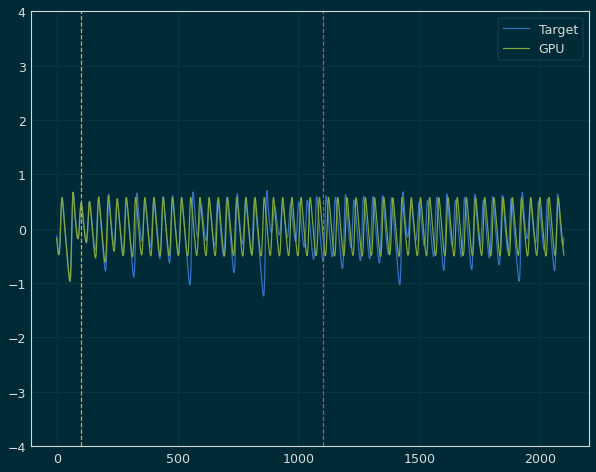

 Iter=68 a=0.527 sr=4.263 amp=0.539  ri=0.718 rr=2.048 loss=0.593584


Iter: 68 #### Diagnostic 0.593584   Time 4.43  Best 0.594 NRMSE 0.161 CD 0.432
Iter: 69 #### Diagnostic 0.950727   Time 3.94  Best 0.594 NRMSE 0.180 CD 0.770
Iter: 70 #### Diagnostic 1.103803   Time 3.94  Best 0.594 NRMSE 0.185 CD 0.919
Iter: 71 #### Diagnostic 1000.000000   Time 3.91  Best 0.594 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1.116162   Time 3.95  Best 0.594 NRMSE 0.185 CD 0.931
Iter: 73 #### Diagnostic 1000.000000   Time 3.93  Best 0.594 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000000   Time 3.94  Best 0.594 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000000   Time 3.93  Best 0.594 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1.078027   Time 3.93  Best 0.594 NRMSE 0.184 CD 0.894
Iter: 77 #### Diagnostic 1.041134   Time 3.94  Best 0.594 NRMSE 0.187 CD 0.854
Iter: 78 #### Diagnostic 1000.000000   Time 3.93  Best 0.594 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1000.000000   T

Iter: 63 #### Diagnostic 1000.000000   Time 3.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1.501335   Time 3.96  Best 1000.000 NRMSE 0.504 CD 0.997
Iter: 65 #### Diagnostic 1.100156   Time 3.93  Best 1000.000 NRMSE 0.184 CD 0.916
Iter: 66 #### Diagnostic 1000.000000   Time 3.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1.273609   Time 3.95  Best 1000.000 NRMSE 0.206 CD 1.068
Iter: 68 #### Diagnostic 1.119772   Time 3.95  Best 1000.000 NRMSE 0.232 CD 0.888
Iter: 69 #### Diagnostic 1000.000000   Time 3.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1.105804   Time 3.89  Best 1000.000 NRMSE 0.240 CD 0.866
Iter: 71 #### Diagnostic 1000.000000   Time 4.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1.150331   Time 3.97  Best 1000.000 NRMSE 0.218 CD 0.933
Iter: 73 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000000   Time 3.93  Best 1000.000 NRMSE 1000.000

Iter: 59 #### Diagnostic 1000.000000   Time 3.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 3.95  Best 1000.000 NRMSE 1000.000 CD 1.000
Iter: 63 #### Diagnostic 1000.000000   Time 3.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD 1.027
Iter: 65 #### Diagnostic 1.141515   Time 3.94  Best 1000.000 NRMSE 0.186 CD 0.956
Iter: 66 #### Diagnostic 1000.000000   Time 3.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 4.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1.463350   Time 3.95  Best 1000.000 NRMSE 0.486 CD 0.977
Iter: 69 #### Diagnostic 1000.000000   Time 3.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000000   Time 3.95  Best 100

Iter: 47 #### Diagnostic 1.516059   Time 3.93  Best 1000.000 NRMSE 0.489 CD 1.027
Iter: 48 #### Diagnostic 0.674995   Time 3.93  Best 1000.000 NRMSE 0.179 CD 0.496
Iter: 49 #### Diagnostic 1000.000000   Time 3.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 50 #### Diagnostic 1000.000000   Time 3.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1.130669   Time 3.93  Best 1000.000 NRMSE 0.185 CD 0.946
Iter: 54 #### Diagnostic 1.111781   Time 3.90  Best 1000.000 NRMSE 0.185 CD 0.927
Iter: 55 #### Diagnostic 0.936016   Time 3.94  Best 1000.000 NRMSE 0.181 CD 0.755
Iter: 56 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 0.708999   Time 3.92  Best 1000.000 NRMSE 0.188 CD 0.521
Iter: 58 #### Diagnostic 1000.000000   Time 3.92  Best 1000.000 NRMSE 1000.000

Iter: 42 #### Diagnostic 1.110028   Time 3.96  Best 1000.000 NRMSE 0.185 CD 0.925
Iter: 43 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1.103741   Time 3.96  Best 1000.000 NRMSE 0.185 CD 0.919
Iter: 45 #### Diagnostic 0.996165   Time 4.01  Best 1000.000 NRMSE 0.182 CD 0.814
Iter: 46 #### Diagnostic 1.029817   Time 3.97  Best 1000.000 NRMSE 0.183 CD 0.847
Iter: 47 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 1.087431   Time 3.95  Best 1000.000 NRMSE 0.185 CD 0.903
Iter: 49 #### Diagnostic 1.082794   Time 3.90  Best 1000.000 NRMSE 0.194 CD 0.889
Iter: 50 #### Diagnostic 1.189641   Time 3.92  Best 1000.000 NRMSE 0.204 CD 0.986
Iter: 51 #### Diagnostic 1.448809   Time 4.03  Best 1000.000 NRMSE 0.436 CD 1.013
Iter: 52 #### Diagnostic 1.057492   Time 3.93  Best 1000.000 NRMSE 0.180 CD 0.877
Iter: 53 #### Diagnostic 1000.000000   Time 4.09  Best 1000.000 NRMSE 1000.000 CD nan
Iter

Iter: 37 #### Diagnostic 1.039148   Time 3.89  Best 1000.000 NRMSE 0.183 CD 0.856
Iter: 38 #### Diagnostic 1.262676   Time 3.92  Best 1000.000 NRMSE 0.231 CD 1.032
Iter: 39 #### Diagnostic 1000.000000   Time 3.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 40 #### Diagnostic 0.983079   Time 3.93  Best 1000.000 NRMSE 0.181 CD 0.802
Iter: 41 #### Diagnostic 1000.000000   Time 3.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1000.000000   Time 3.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 43 #### Diagnostic 1.214923   Time 3.88  Best 1000.000 NRMSE 0.196 CD 1.019
Iter: 44 #### Diagnostic 1.103636   Time 3.93  Best 1000.000 NRMSE 0.204 CD 0.900
Iter: 45 #### Diagnostic 1000.000000   Time 3.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 46 #### Diagnostic 1000.000000   Time 3.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1.054941   Time 3.88  Best 1000.000 NRMSE 0.184 CD 0.871
Iter: 48 #### Diagnostic 1.108013   Time 3.94  Best 1000.000 NRMSE 0.218 CD 0.

Iter: 32 #### Diagnostic 1.180728   Time 3.92  Best 1000.000 NRMSE 0.216 CD 0.965
Iter: 33 #### Diagnostic 1000.000000   Time 3.87  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 34 #### Diagnostic 1000.000000   Time 3.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 35 #### Diagnostic 1000.000000   Time 3.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 36 #### Diagnostic 1.535801   Time 3.94  Best 1000.000 NRMSE 0.536 CD 1.000
Iter: 37 #### Diagnostic 1.149988   Time 3.89  Best 1000.000 NRMSE 0.186 CD 0.964
Iter: 38 #### Diagnostic 0.927153   Time 3.93  Best 1000.000 NRMSE 0.202 CD 0.725
Iter: 39 #### Diagnostic 1.080587   Time 3.94  Best 1000.000 NRMSE 0.184 CD 0.896
Iter: 40 #### Diagnostic 1.070594   Time 3.89  Best 1000.000 NRMSE 0.184 CD 0.887
Iter: 41 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1.158162   Time 3.89  Best 1000.000 NRMSE 0.196 CD 0.962
Iter: 43 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 1000.000 CD 

Iter: 27 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 2662172310248720695296.000 CD 1.001
Iter: 28 #### Diagnostic 1000.000000   Time 3.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 0.736618   Time 3.91  Best 1000.000 NRMSE 0.189 CD 0.547
Iter: 30 #### Diagnostic 1.177487   Time 3.92  Best 1000.000 NRMSE 0.216 CD 0.961
Iter: 31 #### Diagnostic 1000.000000   Time 3.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 32 #### Diagnostic 1.169314   Time 3.92  Best 1000.000 NRMSE 0.193 CD 0.976
Iter: 33 #### Diagnostic 0.970028   Time 3.87  Best 1000.000 NRMSE 0.182 CD 0.788
Iter: 34 #### Diagnostic 1.108965   Time 3.91  Best 1000.000 NRMSE 0.185 CD 0.924
Iter: 35 #### Diagnostic 1.339695   Time 3.91  Best 1000.000 NRMSE 0.294 CD 1.046
Iter: 36 #### Diagnostic 1.001764   Time 3.93  Best 1000.000 NRMSE 0.183 CD 0.819
Iter: 37 #### Diagnostic 1000.000000   Time 3.87  Best 1000.000 NRMSE 1000.000 CD 1.001
Iter: 38 #### Diagnostic 1000.000000   Time 3.93  Best 1000.

Iter: 19 #### Diagnostic 1.092436   Time 3.95  Best 1000.000 NRMSE 0.188 CD 0.905
Iter: 20 #### Diagnostic 1000.000000   Time 4.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 21 #### Diagnostic 1.198485   Time 3.94  Best 1000.000 NRMSE 0.189 CD 1.009
Iter: 22 #### Diagnostic 1000.000000   Time 3.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 23 #### Diagnostic 1000.000000   Time 3.98  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 3.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 25 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 26 #### Diagnostic 1000.000000   Time 3.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 27 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 28 #### Diagnostic 1000.000000   Time 3.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 29 #### Diagnostic 917.436868   Time 4.69  Best 1000.000 NRMSE 916.517 CD 0.920
Iter: 30 #### Diagnostic 0.756527   Time 3.95  Best 1000.000 N

Iter: 13 #### Diagnostic 1000.000000   Time 3.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1.061931   Time 3.95  Best 1000.000 NRMSE 0.184 CD 0.878
Iter: 15 #### Diagnostic 1.059213   Time 3.91  Best 1000.000 NRMSE 0.184 CD 0.875
Iter: 16 #### Diagnostic 1000.000000   Time 3.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 17 #### Diagnostic 1.073819   Time 3.94  Best 1000.000 NRMSE 0.184 CD 0.890
Iter: 18 #### Diagnostic 1000.000000   Time 3.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1000.000000   Time 3.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 20 #### Diagnostic 1.107791   Time 3.92  Best 1000.000 NRMSE 0.185 CD 0.923
Iter: 21 #### Diagnostic 1000.000000   Time 3.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 22 #### Diagnostic 0.983477   Time 3.93  Best 1000.000 NRMSE 0.182 CD 0.801
Iter: 23 #### Diagnostic 1000.000000   Time 3.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 24 #### Diagnostic 1000.000000   Time 3.93  Best 1000.000 NRMSE 1000

Iter: 8 #### Diagnostic 1000.000000   Time 3.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000000   Time 3.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1000.000000   Time 3.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 11 #### Diagnostic 1000.000000   Time 3.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 13 #### Diagnostic 1000.000000   Time 3.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1.217511   Time 3.94  Best 1000.000 NRMSE 0.226 CD 0.992
Iter: 15 #### Diagnostic 1.460281   Time 3.93  Best 1000.000 NRMSE 0.426 CD 1.034
Iter: 16 #### Diagnostic 1.108299   Time 3.95  Best 1000.000 NRMSE 0.185 CD 0.923
Iter: 17 #### Diagnostic 670.170205   Time 3.98  Best 1000.000 NRMSE 669.127 CD 1.044
Iter: 18 #### Diagnostic 1000.000000   Time 3.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 19 #### Diagnostic 1.385041   Time 3.92  Best 1000.000 NRMSE 0

Iter: 3 #### Diagnostic 1000.000000   Time 3.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1000.000000   Time 3.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 6 #### Diagnostic 1000.000000   Time 3.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1.113108   Time 3.95  Best 1000.000 NRMSE 0.186 CD 0.927
Iter: 8 #### Diagnostic 1000.000000   Time 4.01  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 9 #### Diagnostic 1000.000000   Time 3.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 10 #### Diagnostic 1.225609   Time 3.93  Best 1000.000 NRMSE 0.214 CD 1.012
Iter: 11 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 12 #### Diagnostic 1.183811   Time 4.03  Best 1000.000 NRMSE 0.204 CD 0.980
Iter: 13 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 14 #### Diagnostic 1000.000000   Time 3.90  Best 1000.000 NRMSE 100

Iter: 99 #### Diagnostic 1.563518   Time 3.93  Best 1000.000 NRMSE 0.276 CD 1.287

Best result = 0.6875599706040074
a = 0.162178059848963
sr = 2.9372216635364055
amp = 0.9649866768909994
ri = 0.7299468244760233
rr = 3.6404927085492305
********** Size 50 -- Run 4 ***********
Iter: 0 #### Diagnostic 1.161144   Time 3.94  Best 1000.000 NRMSE 0.189 CD 0.972
Iter: 1 #### Diagnostic 1000.000000   Time 4.05  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 2 #### Diagnostic 1.203471   Time 3.92  Best 1000.000 NRMSE 0.213 CD 0.991
Iter: 3 #### Diagnostic 1000.000000   Time 3.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 4 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 5 #### Diagnostic 1.266233   Time 3.88  Best 1000.000 NRMSE 0.253 CD 1.013
Iter: 6 #### Diagnostic 1000.000000   Time 3.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 7 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 23870205.610 CD 0.994
Iter: 8 #### Diagnostic 1.040466   Time 3.92  Best 

Iter: 94 #### Diagnostic 1.088449   Time 3.92  Best 1000.000 NRMSE 0.186 CD 0.903
Iter: 95 #### Diagnostic 1.090623   Time 3.95  Best 1000.000 NRMSE 0.185 CD 0.905
Iter: 96 #### Diagnostic 1000.000000   Time 3.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 97 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 98 #### Diagnostic 1000.000000   Time 3.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 99 #### Diagnostic 1.051223   Time 3.97  Best 1000.000 NRMSE 0.184 CD 0.867

Best result = 0.7236925971853343
a = 0.2892889115628314
sr = 3.68074610949851
amp = 0.7291575497618261
ri = 0.8389185414634677
rr = 3.7380166207183443
Refined search bounds:

Alpha (0.06604712414691605, 1)

Rho (0.533062223755631, 13.796435013800677)

Gamma (0.06750834048436488, 1.731450064359284)

r-in (0.08991368997909986, 1.9330982098118987)

r-res (0.25618207290266704, 7.929513656124002)

End Refinement Run 2 Time 1988.933
********** Size 50 -- Run 0 ***********
Iter: 0 #### Diagnostic 

Iter: 85 #### Diagnostic 1.528523   Time 3.94  Best 1000.000 NRMSE 0.536 CD 0.993
Iter: 86 #### Diagnostic 1000.000000   Time 3.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 87 #### Diagnostic 1000.000000   Time 3.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000000   Time 3.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1000.000000   Time 3.93  Best 1000.000 NRMSE 1000.000 CD 0.992
Iter: 90 #### Diagnostic 1.292706   Time 3.92  Best 1000.000 NRMSE 0.225 CD 1.068
Iter: 91 #### Diagnostic 1000.000000   Time 3.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 92 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 93 #### Diagnostic 0.983782   Time 3.93  Best 1000.000 NRMSE 0.182 CD 0.802
Iter: 94 #### Diagnostic 1.127626   Time 3.88  Best 1000.000 NRMSE 0.185 CD 0.942
Iter: 95 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 96 #### Diagnostic 1000.000000   Time 4.02  Best 1000.000 NRMS

Iter: 80 #### Diagnostic 1000.000000   Time 3.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 81 #### Diagnostic 1000.000000   Time 3.88  Best 1000.000 NRMSE 1000.000 CD 1.003
Iter: 82 #### Diagnostic 1000.000000   Time 3.92  Best 1000.000 NRMSE 1000.000 CD 1.000
Iter: 83 #### Diagnostic 0.956684   Time 3.91  Best 1000.000 NRMSE 0.180 CD 0.776
Iter: 84 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 85 #### Diagnostic 1.038296   Time 3.90  Best 1000.000 NRMSE 0.184 CD 0.855
Iter: 86 #### Diagnostic 1000.000000   Time 3.93  Best 1000.000 NRMSE 209875090328142.438 CD 0.998
Iter: 87 #### Diagnostic 1000.000000   Time 3.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 88 #### Diagnostic 1000.000000   Time 3.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 89 #### Diagnostic 1000.000000   Time 3.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 90 #### Diagnostic 1000.000000   Time 3.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 91 #### Diagnostic 1000.000000   Time 3

Iter: 75 #### Diagnostic 1000.000000   Time 3.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1.084811   Time 3.95  Best 1000.000 NRMSE 0.184 CD 0.900
Iter: 77 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 78 #### Diagnostic 1000.000000   Time 4.03  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 79 #### Diagnostic 1000.000000   Time 4.17  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1.041776   Time 3.94  Best 1000.000 NRMSE 0.184 CD 0.858
Iter: 81 #### Diagnostic 1000.000000   Time 3.92  Best 1000.000 NRMSE 1000.000 CD 0.996
Iter: 82 #### Diagnostic 1.010318   Time 3.93  Best 1000.000 NRMSE 0.183 CD 0.827
Iter: 83 #### Diagnostic 1000.000000   Time 3.89  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 84 #### Diagnostic 1.152166   Time 3.92  Best 1000.000 NRMSE 0.194 CD 0.958
Iter: 85 #### Diagnostic 1.151645   Time 3.93  Best 1000.000 NRMSE 0.186 CD 0.965
Iter: 86 #### Diagnostic 1000.000000   Time 3.92  Best 1000.000 NRMSE 10

Iter: 70 #### Diagnostic 1.013971   Time 3.97  Best 1000.000 NRMSE 0.182 CD 0.832
Iter: 71 #### Diagnostic 1000.000000   Time 3.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1000.000000   Time 3.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 74 #### Diagnostic 1000.000000   Time 3.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000000   Time 3.91  Best 1000.000 NRMSE 1000.000 CD 1.001
Iter: 77 #### Diagnostic 1.127676   Time 3.94  Best 1000.000 NRMSE 0.189 CD 0.939
Iter: 78 #### Diagnostic 1.306838   Time 4.50  Best 1000.000 NRMSE 0.240 CD 1.067
Iter: 79 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 80 #### Diagnostic 1.213655   Time 3.90  Best 1000.000 NRMSE 0.222 CD 0.992
Iter: 81 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMS

Iter: 65 #### Diagnostic 1.156475   Time 3.93  Best 1000.000 NRMSE 0.186 CD 0.970
Iter: 66 #### Diagnostic 1000.000000   Time 3.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 67 #### Diagnostic 1000.000000   Time 3.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 68 #### Diagnostic 1000.000000   Time 3.98  Best 1000.000 NRMSE 1000.000 CD 1.004
Iter: 69 #### Diagnostic 1000.000000   Time 3.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 70 #### Diagnostic 1000.000000   Time 3.91  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 71 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 72 #### Diagnostic 1000.000000   Time 3.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 73 #### Diagnostic 1.061494   Time 3.94  Best 1000.000 NRMSE 0.183 CD 0.878
Iter: 74 #### Diagnostic 1000.000000   Time 3.88  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 75 #### Diagnostic 1000.000000   Time 3.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 76 #### Diagnostic 1000.000000   Time 3.94  Best 1000.

Iter: 57 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 1000.000 CD nan


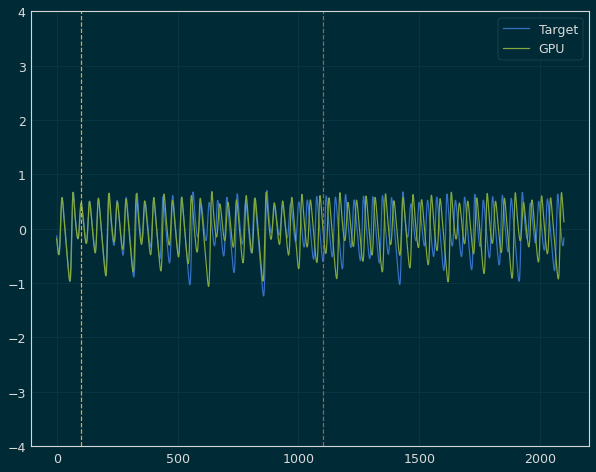

 Iter=58 a=0.714 sr=2.195 amp=0.826  ri=0.794 rr=0.844 loss=0.575843


Iter: 58 #### Diagnostic 0.575843   Time 4.34  Best 0.576 NRMSE 0.166 CD 0.410
Iter: 59 #### Diagnostic 1000.000000   Time 3.96  Best 0.576 NRMSE 1000.000 CD nan
Iter: 60 #### Diagnostic 0.943501   Time 3.90  Best 0.576 NRMSE 0.209 CD 0.735
Iter: 61 #### Diagnostic 1000.000000   Time 3.95  Best 0.576 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 3.93  Best 0.576 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1000.000000   Time 3.94  Best 0.576 NRMSE 1000.000 CD nan
Iter: 64 #### Diagnostic 1000.000000   Time 3.89  Best 0.576 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1.083128   Time 3.93  Best 0.576 NRMSE 0.184 CD 0.899
Iter: 66 #### Diagnostic 1.194380   Time 3.90  Best 0.576 NRMSE 0.205 CD 0.990
Iter: 67 #### Diagnostic 1000.000000   Time 3.94  Best 0.576 NRMSE 1000.000 CD 1.015
Iter: 68 #### Diagnostic 1.021595   Time 3.89  Best 0.576 NRMSE 0.183 CD 0.839
Iter: 69 #### Diagnostic 1.161701 

Iter: 54 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 56 #### Diagnostic 1000.000000   Time 4.10  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1.112548   Time 3.91  Best 1000.000 NRMSE 0.185 CD 0.928
Iter: 58 #### Diagnostic 1.220937   Time 3.98  Best 1000.000 NRMSE 0.217 CD 1.004
Iter: 59 #### Diagnostic 1.161804   Time 3.95  Best 1000.000 NRMSE 0.197 CD 0.965
Iter: 60 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 61 #### Diagnostic 1000.000000   Time 3.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 62 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 63 #### Diagnostic 1.094824   Time 3.90  Best 1000.000 NRMSE 0.185 CD 0.910
Iter: 64 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 65 #### Diagnostic 1000.000000   Time 3.97  Best 1000.000 NRMSE 

Iter: 49 #### Diagnostic 1.083410   Time 3.98  Best 1000.000 NRMSE 0.184 CD 0.899
Iter: 50 #### Diagnostic 1000.000000   Time 3.99  Best 1000.000 NRMSE 1000.000 CD 1.001
Iter: 51 #### Diagnostic 1000.000000   Time 3.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000000   Time 3.99  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 0.995992   Time 3.95  Best 1000.000 NRMSE 0.181 CD 0.815
Iter: 54 #### Diagnostic 1.104157   Time 3.96  Best 1000.000 NRMSE 0.185 CD 0.919
Iter: 55 #### Diagnostic 0.937304   Time 3.91  Best 1000.000 NRMSE 0.181 CD 0.756
Iter: 56 #### Diagnostic 1000.000000   Time 3.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 57 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 58 #### Diagnostic 1000.000000   Time 3.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 59 #### Diagnostic 1.037110   Time 3.89  Best 1000.000 NRMSE 0.184 CD 0.854
Iter: 60 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 10

Iter: 44 #### Diagnostic 1000.000000   Time 3.93  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1000.000000   Time 3.95  Best 1000.000 NRMSE 1000.000 CD 1.001
Iter: 46 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 47 #### Diagnostic 1000.000000   Time 3.96  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 48 #### Diagnostic 0.977998   Time 3.90  Best 1000.000 NRMSE 0.182 CD 0.796
Iter: 49 #### Diagnostic 0.941361   Time 4.32  Best 1000.000 NRMSE 0.181 CD 0.761
Iter: 50 #### Diagnostic 1000.000000   Time 3.92  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 51 #### Diagnostic 1000.000000   Time 4.04  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 52 #### Diagnostic 1000.000000   Time 3.94  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 53 #### Diagnostic 1000.000000   Time 3.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 54 #### Diagnostic 1000.000000   Time 3.97  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 55 #### Diagnostic 1000.000000   Time 3.93  Best 1000.

Iter: 39 #### Diagnostic 1.053392   Time 3.89  Best 1000.000 NRMSE 0.183 CD 0.870
Iter: 40 #### Diagnostic 1000.000000   Time 4.02  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 41 #### Diagnostic 1000.000000   Time 4.06  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 42 #### Diagnostic 1.067880   Time 4.04  Best 1000.000 NRMSE 0.183 CD 0.884
Iter: 43 #### Diagnostic 1000.000000   Time 3.90  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 44 #### Diagnostic 1000.000000   Time 3.95  Best 1000.000 NRMSE 1000.000 CD nan
Iter: 45 #### Diagnostic 1.087121   Time 3.97  Best 1000.000 NRMSE 0.184 CD 0.903
Iter: 46 #### Diagnostic 0.986490   Time 3.94  Best 1000.000 NRMSE 0.191 CD 0.796
Iter: 47 #### Diagnostic 1.087809   Time 3.92  Best 1000.000 NRMSE 0.184 CD 0.904
Iter: 48 #### Diagnostic 1.389208   Time 3.95  Best 1000.000 NRMSE 0.267 CD 1.122
Iter: 49 #### Diagnostic 1.074800   Time 4.10  Best 1000.000 NRMSE 0.184 CD 0.891
Iter: 50 #### Diagnostic 1.110403   Time 4.11  Best 1000.000 NRMSE 0.185 CD 0.925


In [5]:
CALLS = 100
s = torch.torch.from_numpy(signal).cuda(DEVICE).type(dtype)
# Skipped 1000
size = [900,800,700,600,500,400,300,200,100,50]
rand_state = [11,37,3,24,91]

for N in size:
    min_a, max_a = .001, 1.
    min_sr, max_sr = .001, 8.
    min_g, max_g = .001, 1.
    min_ri, max_ri = .001, 1.
    min_rr, max_rr = .001, 5.
    space = [Real(min_a, max_a, name='a'),
                     Real(min_sr, max_sr, name='sr'),
                     Real(min_g, max_g, name='amp'), 
                     Real(min_ri, max_ri, name='ri'),
                     Real(min_rr, max_rr, name='rr')
                    ]
    for ref in range(5):
        start = time.time()
        alphas = []
        rhos = []
        gammas = []
        inScales = []
        resScales = []
        
        for rn in range(5):
            running_error = 1000
            counter = 0 
            print(f'********** Size {N} -- Run {rn} ***********')
            result_gp = gp_minimize(loop,
                                    space,
                                    n_calls=CALLS,
                                    random_state=rand_state[rn],
                                    n_jobs=-1,
                                    n_initial_points=100)
            print(f'\nBest result = {result_gp.fun}')
            names = ['a','sr','amp','ri','rr']
            for i in range(len(space)):
                print(f'{names[i]} = {result_gp.x[i]}')
                
        min_a, max_a   = resize_spaces(min_a, max_a,
                                       np.array(alphas),
                                       isAlpha=True)
        min_sr, max_sr = resize_spaces(min_sr, max_sr, np.array(rhos))
        min_g, max_g   = resize_spaces(min_g, max_g, np.array(gammas))
        min_ri, max_ri = resize_spaces(min_ri, max_ri, np.array(inScales))
        min_rr, max_rr = resize_spaces(min_rr, max_rr, np.array(resScales))
        print('Refined search bounds:\n')
        print(f'Alpha ({min_a}, {max_a})\n')
        print(f'Rho ({min_sr}, {max_sr})\n')
        print(f'Gamma ({min_g}, {max_g})\n')
        print(f'r-in ({min_ri}, {max_ri})\n')
        print(f'r-res ({min_rr}, {max_rr})\n')
        end = time.time()-start
        print(f'End Refinement Run {ref} Time {end:.3f}')

## End Model

In [ ]:
def rank_curve(cplus, tols):
    rank_tols = []
    for i in tols:
        rank_tols.append(rca.rank(cplus, i))
    return np.array(rank_tols)

iteration = [12,63,2,33,11,63,11,11,9,14,26,50,11,26,63,11,40,5,63,16]

size = [1000,950,900,850,800,750,700,650,600,550,500,
        450,400,350,300,250,200,150,100,50]

In [ ]:
TOLS = [1/10**(x) for x in range(0,20)]
mm_ranks = []
for ctr,N in zip(iteration,size):
    fn_mats = f'./MultiModelX/Mats/Lx_it{ctr}_{N}_Wnet.npy'
    fn_params = f'./MultiModelX/Params/Lx_it{ctr}_{N}_InstanceParams.npy'
    p = np.load(fn_params, allow_pickle=True)
    a,g = p[0],p[2]

    Wr, Wi = rca.get_mats(fn_mats, K, N)
    xeq = np.zeros((N,1))
    ueq = np.zeros((K,1))
    A = rca.leaky_jacobian(xeq, ueq, a, g, Wi, Wr)
    B = rca.partial_u(xeq, ueq, a, g, Wi, Wr)

    Cplus = np.nan_to_num(rca.reachable_matrix(A, B),0,0,0)
    spec = np.linalg.eigvals(Cplus)
    evs= np.abs(spec)
    Cplus = Cplus/np.max(evs)
    rkc = rank_curve(Cplus,TOLS)
    v = np.argmax(np.gradient(rkc))-1
    ave_rank = (rkc[v]+rkc[v+1])/2
    print(f'Pair: iter {ctr} size {N} argmax {v} {v+1} tol {TOLS[v]} ave {ave_rank}')
    #plt.plot(ave_rank)
    #plt.vlines(v,0,N)
    #plt.show()
    #plt.close
    mm_ranks.append(ave_rank)
    
np.save('./MultiModelX/Lx_MMranks',mm_ranks)

In [ ]:
large = np.load('./MultiModelX/Lx_MMranks.npy')
plt.plot(large)
plt.show()

In [ ]:
minmax = np.max(signal[:TRAINLENGTH+TEST])-np.min(signal[:TRAINLENGTH+TEST])
err_list = []
for ctr,N in zip(iteration,size):
    pred = np.load(f'./MultiModelX/Preds/Lx_it{ctr}_{N}_Preds.npy', allow_pickle=True)
    rmse = mean_squared_error(signal[TRAINLENGTH:TRAINLENGTH+TEST],pred[TRAINLENGTH:TRAINLENGTH+TEST],
                               squared=False, multioutput='raw_values')
    print(rmse/minmax)
    err_list.append(rmse/minmax)
np.save('./MultiModelX/Lx_mm_errors',np.array(err_list))

plt.plot(err_list)
plt.show()

In [ ]:
minmax